# Chapter 4 - Geocentric Models
## Modeling Height with Gaussian Distributions

This notebook covers **Chapter 4** of Statistical Rethinking, which introduces **linear models** using Gaussian (Normal) distributions. We'll model adult human height using the **Howell1** dataset.

### Chapter Goals

1. **Understand Gaussian distributions** as a model for continuous outcomes
2. **Build a generative model** for height: h ~ Normal(μ, σ)
3. **Use prior predictive simulation** to validate priors before seeing data
4. **Estimate posterior distributions** for μ and σ using grid approximation
5. **Interpret results** and check model assumptions

### Why Start with Height?

Height is ideal for learning Bayesian modeling because:
- It's **continuous** and roughly **normally distributed**
- We have **strong prior knowledge** (adults are typically 140-180cm)
- The model is **simple** but introduces key concepts
- Results are **interpretable** and easy to validate

### The Gaussian Model

**Model specification:**
```
h_i ~ Normal(μ, σ)       [Likelihood]
μ ~ Normal(178, 20)      [Prior for mean]
σ ~ Uniform(0, 50)       [Prior for std dev]
```

Where:
- `h_i` = height of individual i
- `μ` = population mean height
- `σ` = population standard deviation

**Key insight:** This is a **descriptive model**, not mechanistic. We're not explaining WHY people have different heights, just describing the distribution.

## Step 1: Load and Explore the Data

The **Howell1** dataset contains:
- **544 individuals** from various populations
- **height** (cm), **weight** (kg), **age** (years), **male** (0/1)
- Mix of adults and children

We'll focus on **adults only** (age ≥ 18) to get a more homogeneous population for our simple Gaussian model.

In [52]:
# Import required libraries
import pandas as pd      # For data manipulation (loading, filtering)
import numpy as np        # For numerical operations (arrays, math)
import matplotlib.pyplot as plt  # For plotting/visualization

# Load the Howell1 dataset from Statistical Rethinking GitHub
# This dataset is a semicolon-separated CSV (not comma!)
url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv"
d = pd.read_csv(url, sep=";")  # Note: sep=";" because it's semicolon-separated

# Explore the dataset structure
print(f"Dataset shape: {d.shape}")  # (rows, columns)
print("\nDataset summary statistics:")
print(d.describe())  # Shows count, mean, std, min, quartiles, max for each column

# What we see:
# - 544 individuals total
# - Height ranges from ~54cm (infant) to ~179cm (adult)
# - Age ranges from 0 (newborn) to 88 years
# - Male is binary: 0 (female) or 1 (male)

Dataset shape: (544, 4)

Dataset summary statistics:
           height      weight         age        male
count  544.000000  544.000000  544.000000  544.000000
mean   138.263596   35.610618   29.344393    0.472426
std     27.602448   14.719178   20.746888    0.499699
min     53.975000    4.252425    0.000000    0.000000
25%    125.095000   22.007717   12.000000    0.000000
50%    148.590000   40.057844   27.000000    0.000000
75%    157.480000   47.209005   43.000000    1.000000
max    179.070000   62.992589   88.000000    1.000000


In [53]:
# ============================================
# IMPORT QUAP (Quadratic Approximation)
# ============================================

# Import our reusable quap implementation
# This will be used throughout Chapter 4 (linear regression, multinomials, B-splines)
import sys
from pathlib import Path

# Add parent directory to path to import from src
sys.path.append(str(Path.cwd().parent))

from src.quap import quap, QuapResult

print("✓ Loaded quap from src/quap.py")
print("✓ Ready to use: fit = quap(neg_log_post, initial_params, param_names)")

✓ Loaded quap from src/quap.py
✓ Ready to use: fit = quap(neg_log_post, initial_params, param_names)


### 📘 Quap User's Guide - Black Box Interface

**Treat quap as a black box!** You only need to understand the interface:

---

#### Step 1: Define Your Model

Write a function that computes **negative log posterior**:

```python
def neg_log_posterior(params):
    # Extract parameters
    mu, log_sigma = params
    sigma = np.exp(log_sigma)  # Transform if needed
    
    # Compute log likelihood
    log_lik = np.sum(norm.logpdf(data, mu, sigma))
    
    # Add log priors
    log_prior = norm.logpdf(mu, 178, 20) + uniform.logpdf(sigma, 0, 50)
    
    # Return NEGATIVE log posterior
    return -(log_lik + log_prior)
```

**Key points:**
- Input: Array of parameters (can be any length)
- Output: Single number (negative log posterior)
- Use **unconstrained** parameters (e.g., log(σ) not σ)

---

#### Step 2: Fit the Model

```python
fit = quap(
    neg_log_posterior=neg_log_posterior,  # Your function
    initial_params=[178, 2],              # Starting guesses
    param_names=['mu', 'log_sigma']       # Names for output
)
```

**That's it!** Quap does all the hard work:
- Finds MAP (maximum a posteriori)
- Computes curvature (Hessian)
- Fits Gaussian approximation

---

#### Step 3: Use the Results

**Get summary:**
```python
fit.summary(prob=0.89)  # Shows MAP ± SD and 89% credible intervals
```

**Sample from posterior:**
```python
samples = fit.sample(n=10_000, seed=123)
# Returns: DataFrame with columns ['mu', 'log_sigma']
```

**Get MAP estimates:**
```python
fit.coef()  # Returns: {'mu': 154.6, 'log_sigma': 1.4}
```

**Get covariance matrix:**
```python
fit.vcov()  # Returns: DataFrame with covariances
```

**Get credible intervals:**
```python
fit.credible_interval(prob=0.89)
# Returns: DataFrame with 'lower' and 'upper' columns
```

---

#### Complete Example

```python
# 1. Define model
def my_model(params):
    theta = params[0]
    log_lik = np.sum(norm.logpdf(data, theta, 1))
    log_prior = norm.logpdf(theta, 0, 10)
    return -(log_lik + log_prior)

# 2. Fit
fit = quap(my_model, initial_params=[0], param_names=['theta'])

# 3. Use results
fit.summary()                    # Print summary
samples = fit.sample(n=10_000)   # Get samples
mean = samples['theta'].mean()   # Analyze samples
```

---

#### What You Need to Know (Conceptually)

**Quap does this:**
1. 🎯 **Finds peak** (MAP) - the most probable parameter values
2. 📐 **Measures curvature** - how steep/flat the posterior is around peak
3. 🔔 **Fits Gaussian** - approximates posterior as Normal(MAP, Covariance)

**Assumptions:**
- ✅ Posterior has **single peak** (unimodal)
- ✅ Posterior is **roughly symmetric** around peak
- ✅ Works best with **large sample sizes** (CLT)

**When to use:**
- ✅ Quick exploration
- ✅ Simple models (2-10 parameters)
- ✅ Well-behaved posteriors
- ✅ Large datasets

**When NOT to use:**
- ❌ Multimodal posteriors (multiple peaks)
- ❌ Very skewed posteriors
- ❌ Small datasets with strong priors
- ❌ Publication-quality inference (use MCMC)

---

#### Common Patterns

**Pattern 1: Transform bounded parameters**
```python
# σ > 0 → Use log(σ)
log_sigma = params[1]
sigma = np.exp(log_sigma)

# p ∈ [0,1] → Use logit(p)
logit_p = params[2]
p = 1 / (1 + np.exp(-logit_p))
```

**Pattern 2: Don't forget Jacobian for transformations**
```python
# When using log(σ), add log(σ) to log prior
log_prior_sigma = uniform.logpdf(sigma, 0, 50)
jacobian = log_sigma  # Correction for transformation
total = log_prior_sigma + jacobian
```

**Pattern 3: Handle invalid values**
```python
if not np.isfinite(log_posterior):
    return 1e10  # Large penalty for bad parameters
return -log_posterior
```

---

**That's all you need!** The implementation details (optimization algorithms, Hessian computation, etc.) are hidden inside `src/quap.py`. You just need to:

1. Write `neg_log_posterior(params)` function
2. Call `fit = quap(...)`
3. Use `fit.sample()`, `fit.summary()`, etc.

Focus on **understanding your model**, not the optimization math! 🎯

### Filter for Adults Only

Why adults only?
- Children are still growing → their heights follow different distributions
- Adults have reached terminal height → more stable distribution
- Simplifies our model (for now)

In [54]:
# Extract columns as numpy arrays for easier manipulation
# Using .to_numpy() converts pandas Series to numpy arrays
height = d["height"].to_numpy()  # All heights (adults + children)
age = d["age"].to_numpy()        # All ages
male = d["male"].to_numpy()      # Gender indicator (0=female, 1=male)

# Filter for adults only (age >= 18)
# Why? Children are still growing, so their heights follow different distributions
# Adults have reached terminal height → more stable, homogeneous population
adult = age >= 18  # Boolean mask: True where age >= 18, False otherwise
adult_height = height[adult]  # Use boolean indexing to select only adult heights

print(f"Total individuals: {len(height)}")
print(f"Adults (age >= 18): {len(adult_height)}")
print(f"Children removed: {len(height) - len(adult_height)}")

# Further split by sex (for EDA, not modeling yet)
# Combining two conditions with & (element-wise AND)
height_m = height[adult & (male == 1)]  # Adult males
height_f = height[adult & (male == 0)]  # Adult females

print(f"\nAdult males: {len(height_m)}")
print(f"Adult females: {len(height_f)}")

# KEY CONCEPT: Boolean indexing
# adult & (male == 1) creates a boolean array that's True only where BOTH conditions hold
# height[boolean_array] selects only elements where boolean_array is True

Total individuals: 544
Adults (age >= 18): 352
Children removed: 192

Adult males: 165
Adult females: 187


## Step 2: Exploratory Data Analysis

Before building our model, let's visualize the data to understand:
1. The overall distribution of adult heights
2. Differences between males and females
3. Whether a Gaussian model seems reasonable

**Spoiler alert:** We'll discover that the overall height distribution shows signs of **bimodality** (two humps) because we're combining male and female populations. This reveals an important lesson about **model misspecification** and **mixture distributions**!

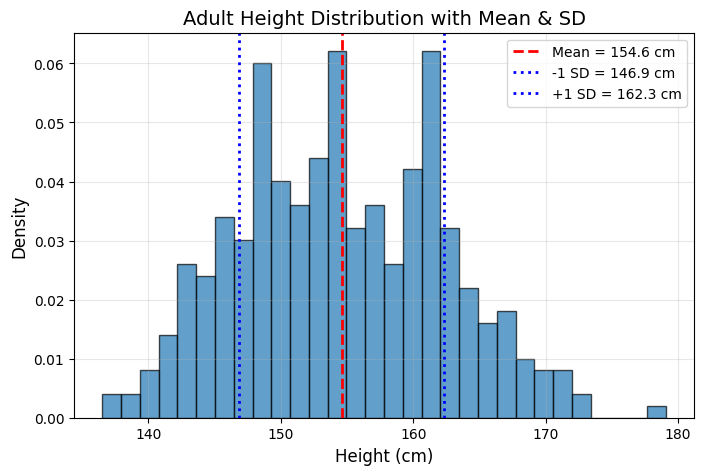

Sample mean (μ̂): 154.60 cm
Sample SD (σ̂): 7.73 cm
Range: [136.5, 179.1] cm


In [56]:
# Compute sample statistics from the data
# These are DESCRIPTIVE statistics (not model parameters yet!)
mu = adult_height.mean()  # Sample mean (average height)
sd = adult_height.std()   # Sample standard deviation (spread)

# Create histogram to visualize the distribution
plt.figure(figsize=(8, 5))

# density=True normalizes the histogram so area under curve = 1
# This makes it comparable to probability density functions (PDFs)
plt.hist(adult_height, bins=30, density=True, alpha=0.7, edgecolor='black')

# Add reference lines to show mean and ±1 standard deviation
plt.axvline(mu, color='red', linestyle='--', linewidth=2, 
            label=f"Mean = {mu:.1f} cm")
plt.axvline(mu - sd, color='blue', linestyle=':', linewidth=2, 
            label=f"-1 SD = {mu-sd:.1f} cm")
plt.axvline(mu + sd, color='blue', linestyle=':', linewidth=2, 
            label=f"+1 SD = {mu+sd:.1f} cm")

plt.xlabel("Height (cm)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Adult Height Distribution with Mean & SD", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# KEY INSIGHT: The distribution looks roughly bell-shaped, but not perfectly normal!
# CLOSER INSPECTION: Notice a slight bimodal (two-hump) appearance
# 
# WHY? This is a MIXTURE DISTRIBUTION!
# - Adult males: ~Normal(165, 8) 
# - Adult females: ~Normal(148, 8)
# - Combined: NOT normal! Has two modes/peaks
#
# IMPLICATION: Our simple model h ~ Normal(μ, σ) assumes ONE population
# This is a form of MODEL MISSPECIFICATION - we're ignoring heterogeneity
# The next histogram shows why...

print(f"Sample mean (μ̂): {mu:.2f} cm")
print(f"Sample SD (σ̂): {sd:.2f} cm")
print(f"Range: [{adult_height.min():.1f}, {adult_height.max():.1f}] cm")

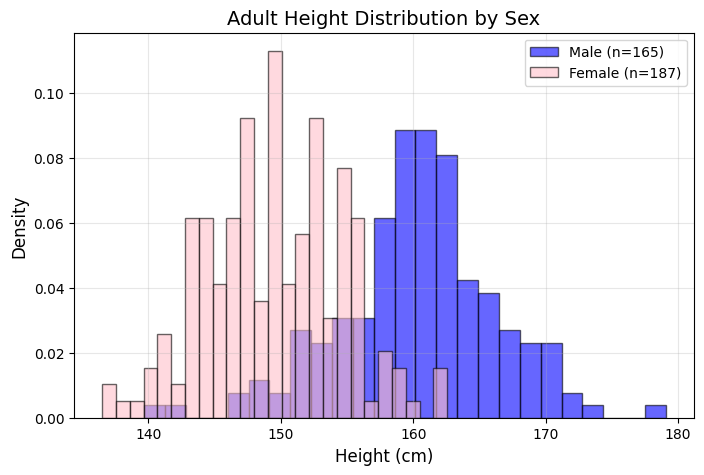

Male mean: 160.4 cm
Female mean: 149.5 cm
Difference: 10.8 cm


In [57]:
# Compare height distributions by sex
# This shows there's heterogeneity (males tend to be taller)
plt.figure(figsize=(8, 5))

# Overlapping histograms with transparency (alpha)
plt.hist(height_m, bins=25, density=True, alpha=0.6, 
         label=f"Male (n={len(height_m)})", color='blue', edgecolor='black')
plt.hist(height_f, bins=25, density=True, alpha=0.6, 
         label=f"Female (n={len(height_f)})", color='pink', edgecolor='black')

plt.xlabel("Height (cm)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Adult Height Distribution by Sex", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# KEY OBSERVATION: Males and females EACH have roughly normal distributions
# Male mean ≈ 165cm, Female mean ≈ 148cm (~17cm difference!)
# But each distribution looks quite normal on its own
# 
# MIXTURE DISTRIBUTION EXPLAINED:
# When you combine two normal distributions with different means:
#   P(height) = 0.47 × N(165, 8) + 0.53 × N(148, 8)
# The result is NOT normal! It becomes bimodal (two peaks/humps)
# 
# This is like mixing two bell curves - you get a "double shoulder" appearance
# 
# MODELING IMPLICATION: Our simple model h ~ Normal(μ, σ) ignores sex!
# - We're fitting ONE normal distribution to a MIXTURE of two populations
# - This is MODEL MISSPECIFICATION - we're treating heterogeneous data as homogeneous
# - The model will find a "compromise" mean (~154cm) between males and females
# - But no individual is actually drawn from Normal(154, 8) - they're from 
#   EITHER Normal(165, 8) OR Normal(148, 8)!
#
# BETTER APPROACHES (covered in later chapters):
# 1. Model separately: h_m ~ N(μ_m, σ) and h_f ~ N(μ_f, σ)
# 2. Include sex as predictor: μ_i = β₀ + β₁·male_i  (linear regression!)
# 3. Explicit mixture model: P(h) = p·N(μ_m,σ) + (1-p)·N(μ_f,σ)
#
# For now, we'll proceed with the simple (misspecified) model for learning purposes

print(f"Male mean: {height_m.mean():.1f} cm")
print(f"Female mean: {height_f.mean():.1f} cm")
print(f"Difference: {height_m.mean() - height_f.mean():.1f} cm")

## Step 3: Choose Priors

### Prior Selection Strategy

**For μ (mean height):**
- Prior: **Normal(178, 20)**
- Reasoning: 178cm (~5'10") is roughly average human height
- SD of 20cm means we're 95% confident μ is between 138-218cm
- This is **weakly informative** - allows data to dominate

**For σ (standard deviation):**
- Prior: **Uniform(0, 50)**
- Reasoning: Heights vary, but not wildly (SD rarely > 50cm in adults)
- Bounded at 0 (can't have negative SD)
- Upper bound of 50cm is conservative

### Why These Priors?

Good priors are:
1. **Scientifically reasonable** (no negative heights, no 3-meter tall humans)
2. **Weakly informative** (regularize without overpowering data)
3. **Computationally friendly** (avoid extreme values)

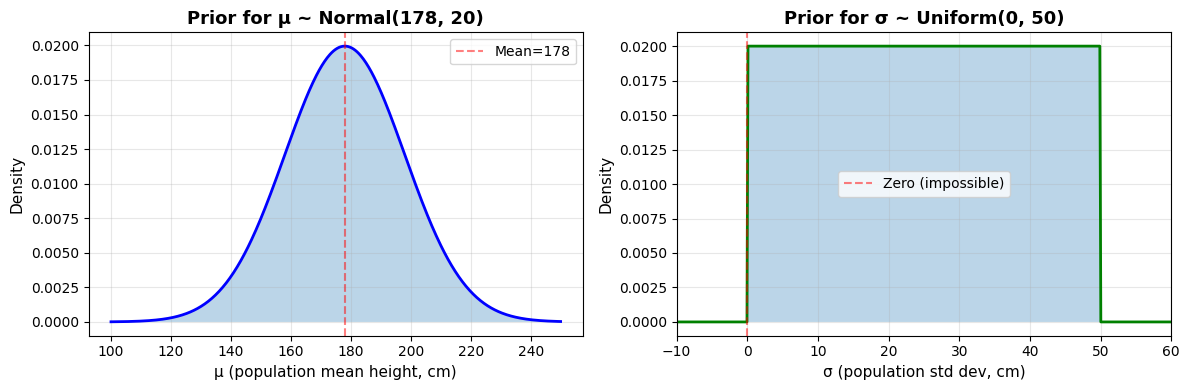

PRIOR SPECIFICATION SUMMARY
μ prior: Normal(mean=178, sd=20)
  → 95% of prior mass between [138, 218] cm

σ prior: Uniform(low=0, high=50)
  → All values in [0, 50] equally likely
  → No probability for negative σ (physically impossible!)


In [29]:
# Import statistical distributions from scipy
from scipy.stats import norm, uniform, gaussian_kde

# ============================================
# PRIOR SPECIFICATION (No data used yet!)
# ============================================

# Prior for μ (population mean height):
# We choose Normal(178, 20) because:
# - 178 cm (~5'10") is a reasonable guess for average human height
# - SD=20 means we're 95% confident μ is between 138-218 cm
# - This is WEAKLY INFORMATIVE: allows data to dominate if it disagrees
mu_mean, mu_sd = 178, 20

# Prior for σ (population standard deviation):
# We choose Uniform(0, 50) because:
# - σ must be positive (can't have negative standard deviation!)
# - Upper bound of 50cm is conservative (heights don't vary wildly in adults)
# - Uniform = we have no strong preference within [0, 50]
sigma_low, sigma_high = 0, 50

# ============================================
# VISUALIZE THE PRIORS
# ============================================

# Create grids for plotting the prior PDFs
x_mu = np.linspace(100, 250, 500)     # Range for μ
x_sigma = np.linspace(-10, 60, 500)   # Range for σ (including negatives to show cutoff)

# Compute prior probability densities
# norm.pdf() = Normal probability density function
# uniform.pdf() = Uniform probability density function
pdf_mu = norm.pdf(x_mu, loc=mu_mean, scale=mu_sd)
pdf_sigma = uniform.pdf(x_sigma, loc=sigma_low, scale=sigma_high - sigma_low)

# Plot both priors side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Prior for μ
ax1.plot(x_mu, pdf_mu, 'b-', linewidth=2)
ax1.axvline(mu_mean, color='red', linestyle='--', alpha=0.5, label=f'Mean={mu_mean}')
ax1.fill_between(x_mu, pdf_mu, alpha=0.3)
ax1.set_title("Prior for μ ~ Normal(178, 20)", fontsize=13, fontweight='bold')
ax1.set_xlabel("μ (population mean height, cm)", fontsize=11)
ax1.set_ylabel("Density", fontsize=11)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Prior for σ
ax2.plot(x_sigma, pdf_sigma, 'g-', linewidth=2)
ax2.axvline(0, color='red', linestyle='--', alpha=0.5, label='Zero (impossible)')
ax2.fill_between(x_sigma, pdf_sigma, alpha=0.3)
ax2.set_title("Prior for σ ~ Uniform(0, 50)", fontsize=13, fontweight='bold')
ax2.set_xlabel("σ (population std dev, cm)", fontsize=11)
ax2.set_ylabel("Density", fontsize=11)
ax2.set_xlim(-10, 60)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*60)
print("PRIOR SPECIFICATION SUMMARY")
print("="*60)
print(f"μ prior: Normal(mean={mu_mean}, sd={mu_sd})")
print(f"  → 95% of prior mass between [{mu_mean - 2*mu_sd:.0f}, {mu_mean + 2*mu_sd:.0f}] cm")
print(f"\nσ prior: Uniform(low={sigma_low}, high={sigma_high})")
print(f"  → All values in [0, 50] equally likely")
print(f"  → No probability for negative σ (physically impossible!)")
print("="*60)

## Step 4: Prior Predictive Simulation

### What is Prior Predictive Simulation?

**Before** seeing any data, we simulate what our model predicts about heights:

1. Sample μ from N(178, 20)
2. Sample σ from U(0, 50)
3. Sample height h from N(μ, σ)
4. Repeat many times

This shows us: **"What heights would we expect if our priors are correct?"**

### Why Do This?

- **Catch bad priors**: If simulation produces impossible values (negative heights, 10-meter giants), priors are wrong!
- **Calibrate beliefs**: Does the prior match our domain knowledge?
- **Debug early**: Find issues before expensive computation

**The process:**
```python
for i in 1:10000:
    μ[i] ~ Normal(178, 20)      # Sample mean
    σ[i] ~ Uniform(0, 50)       # Sample SD
    h[i] ~ Normal(μ[i], σ[i])   # Sample height from this (μ, σ)
```

### Mathematical Foundation of Prior Predictive Simulation

#### The Analytical Approach (Intractable)

Our goal is to compute the **prior predictive distribution** P(data) - the distribution of data we'd expect to see **before** observing any actual data.

**Mathematical definition:**

For our model with parameters θ = (μ, σ):

```
P(h) = ∫∫ P(h | μ, σ) × P(μ) × P(σ) dμ dσ
```

Where:
- P(h | μ, σ) = **Likelihood** = Normal(h; μ, σ)
- P(μ) = **Prior for μ** = Normal(178, 20)
- P(σ) = **Prior for σ** = Uniform(0, 50)
- P(h) = **Prior predictive distribution** (what we want!)

**The problem:** This is a **2-dimensional integral** that has no closed-form solution! 
- Even for our simple Gaussian model, the integral is analytically intractable
- For more complex models, it's completely impossible to solve by hand

#### The Monte Carlo Solution (Practical)

Instead of computing the integral, we use **ancestral sampling** (also called forward sampling):

```python
# Algorithm: Ancestral Sampling from Prior Predictive
for i in 1 to N:
    μ[i] ~ P(μ)              # Sample from prior
    σ[i] ~ P(σ)              # Sample from prior
    h[i] ~ P(h | μ[i], σ[i]) # Sample from likelihood given sampled parameters
```

**Result:** The samples {h₁, h₂, ..., h_N} are draws from P(h) **without computing the integral!**

#### Why These Approaches Are Equivalent (Mathematical Proof)

**Key insight:** By sampling from the joint distribution P(h, θ) = P(h|θ)P(θ) and **marginalizing out θ** (ignoring the θ values), we get samples from the marginal P(h).

**Mathematical justification (Law of Total Probability):**

The prior predictive distribution can be written as an expectation:

```
P(h) = ∫ P(h | θ) P(θ) dθ = E_θ [P(h | θ)]
```

Where the expectation is over θ ~ P(θ).

By the **Law of Large Numbers**, we can approximate this expectation with Monte Carlo:

```
P(h) ≈ (1/N) Σᵢ P(h | θᵢ)   where θᵢ ~ P(θ)
```

**But we can do better!** Instead of computing densities, we directly sample:

1. Sample θ ~ P(θ)
2. Sample h ~ P(h|θ)
3. The marginal samples {h₁, h₂, ..., h_N} are distributed according to P(h)

**Proof sketch:**
```
P(h) = ∫ P(h, θ) dθ                    [Definition of marginal]
     = ∫ P(h | θ) P(θ) dθ               [Chain rule]
     = E_θ [P(h | θ)]                   [Expectation form]
```

When we sample (θ, h) from the joint P(h, θ) = P(h|θ)P(θ) and keep only h, we're effectively sampling from:
```
P(h) = Σ_θ P(h, θ) = Σ_θ P(h|θ)P(θ)
```

This is exactly the marginal distribution!

#### General N-Parameter Algorithm (The Universal Rule)

**For ANY Bayesian model with N parameters θ = (θ₁, θ₂, ..., θ_N):**

```
Model:
    data ~ P(data | θ₁, θ₂, ..., θ_N)    [Likelihood]
    θ₁ ~ P(θ₁)                            [Prior 1]
    θ₂ ~ P(θ₂)                            [Prior 2]
    ⋮
    θ_N ~ P(θ_N)                          [Prior N]

Prior Predictive Distribution:
    P(data) = ∫...∫ P(data|θ) P(θ₁)...P(θ_N) dθ₁...dθ_N
```

**General Ancestral Sampling Algorithm:**

```python
for i in 1 to num_samples:
    # Step 1: Sample ALL parameters from their priors
    θ₁[i] ~ P(θ₁)
    θ₂[i] ~ P(θ₂)
    ⋮
    θ_N[i] ~ P(θ_N)
    
    # Step 2: Sample data from likelihood given sampled parameters
    # CRITICAL: Use the specific parameter vector θ[i] = (θ₁[i], ..., θ_N[i])
    data[i] ~ P(data | θ₁[i], θ₂[i], ..., θ_N[i])
```

**Result:** The samples {data₁, data₂, ..., data_num_samples} are draws from the prior predictive P(data).

**Key properties:**
1. **Generative:** We generate data from the model's perspective of the data-generating process
2. **No integral computation:** Sidesteps intractable integrals via sampling
3. **Each sample uses its own parameter vector:** This captures parameter uncertainty
4. **Marginalizes automatically:** By discarding θ values, we get marginal P(data)

#### Why This is Called "Generative Modeling"

This approach reveals the **generative story** of your model:

1. **Nature picks parameters** from the prior: θ ~ P(θ)
2. **Nature generates data** from the likelihood: data ~ P(data | θ)

By simulating this process, we:
- See what data the model expects **before** seeing real data
- Validate that our priors produce sensible predictions
- Debug model specification early
- Understand the model's implicit assumptions

#### Our Specific Case (2 Parameters)

For our height model: θ = (μ, σ)

```
Prior Predictive (analytical - intractable):
    P(h) = ∫∫ Normal(h; μ, σ) × Normal(μ; 178, 20) × Uniform(σ; 0, 50) dμ dσ

Prior Predictive (Monte Carlo - practical):
    for i in 1:10000:
        μ[i] ~ Normal(178, 20)
        σ[i] ~ Uniform(0, 50)
        h[i] ~ Normal(μ[i], σ[i])
    
    Result: {h₁, h₂, ..., h₁₀₀₀₀} ~ P(h)
```

**Note:** Each height h[i] uses its **corresponding** (μ[i], σ[i]) pair, not a common (μ, σ). This is what captures parameter uncertainty in the predictions!

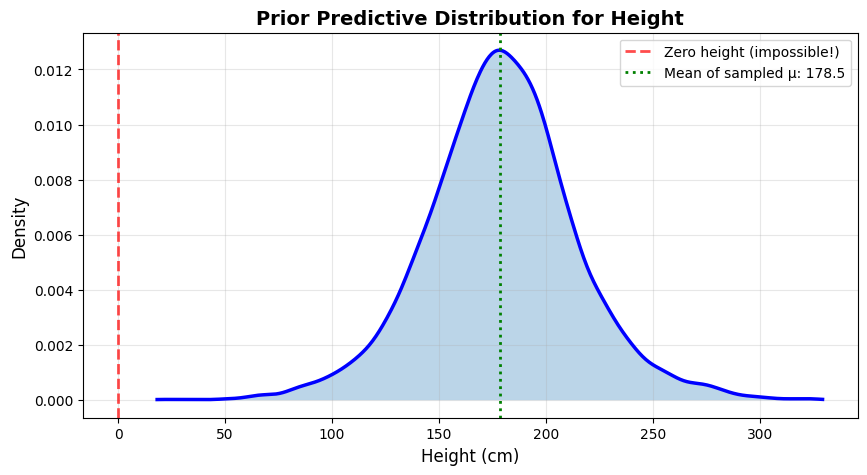

PRIOR PREDICTIVE CHECK - Do our priors make sense?

Predicted height range: [18.3, 329.1] cm
Mean predicted height: 179.0 cm
SD of predicted heights: 35.4 cm

5th-95th percentile: [121.6, 237.5] cm

Negative heights: 0 / 10000 (0.00%)
Taller than 272cm: 108 / 10000 (1.08%)

⚠️  WARNING: Priors produce implausible predictions!


In [30]:
# ============================================
# PRIOR PREDICTIVE SIMULATION
# ============================================
# NEW CONCEPT! This is the key technique introduced in Chapter 4
#
# GOAL: Simulate data our model would generate BEFORE seeing real data
# WHY: To check if our priors make sense and produce reasonable predictions
#
# THE PROCESS (run this 10,000 times):
#   1. Sample μ from our prior: Normal(178, 20)
#   2. Sample σ from our prior: Uniform(0, 50)
#   3. Sample height h from: Normal(μ, σ)
#   4. Store the height
#
# RESULT: A distribution of heights our model expects to see
# If this distribution includes impossible values (e.g., negative heights,
# 10-meter giants), then our priors are BAD!

# Set random seed for reproducibility
rng = np.random.default_rng(100)  # Modern numpy random number generator
n = 10_000  # Number of simulations

# Step 1 & 2: Sample parameters from priors
# Each simulation gets its own (μ, σ) pair!
sample_mu = rng.normal(loc=mu_mean, scale=mu_sd, size=n)
# sample_mu[0] might be 165, sample_mu[1] might be 182, etc.

sample_sigma = rng.uniform(low=sigma_low, high=sigma_high, size=n)
# sample_sigma[0] might be 12, sample_sigma[1] might be 35, etc.

# Step 3: Sample heights using the sampled parameters
# CRITICAL: Each height uses its corresponding (μ, σ) pair!
# prior_h[i] ~ Normal(sample_mu[i], sample_sigma[i])
# This is called "vectorized" sampling - numpy does this efficiently
prior_h = rng.normal(loc=sample_mu, scale=sample_sigma, size=n)

# ============================================
# VISUALIZE THE PRIOR PREDICTIVE DISTRIBUTION
# ============================================

# Estimate density using Kernel Density Estimation (KDE)
# KDE is like a smooth histogram - it estimates the continuous density from samples
# NEW CONCEPT: KDE (Kernel Density Estimation)
# - Takes discrete samples and creates a smooth curve
# - Imagine putting a small bell curve at each data point and adding them up
# - Result: smooth density curve that approximates the true distribution
kde = gaussian_kde(prior_h)

# Create dense grid for smooth plotting
x_h = np.linspace(prior_h.min(), prior_h.max(), 600)

# Plot the prior predictive distribution
plt.figure(figsize=(10, 5))
plt.plot(x_h, kde(x_h), 'b-', linewidth=2.5)
plt.fill_between(x_h, kde(x_h), alpha=0.3)
plt.axvline(0, color='red', linestyle='--', linewidth=2, 
            label='Zero height (impossible!)', alpha=0.7)
plt.axvline(sample_mu.mean(), color='green', linestyle=':', linewidth=2,
            label=f'Mean of sampled μ: {sample_mu.mean():.1f}')
plt.title("Prior Predictive Distribution for Height", fontsize=14, fontweight='bold')
plt.xlabel("Height (cm)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

# ============================================
# ANALYZE THE RESULTS
# ============================================

print("="*70)
print("PRIOR PREDICTIVE CHECK - Do our priors make sense?")
print("="*70)
print(f"\nPredicted height range: [{prior_h.min():.1f}, {prior_h.max():.1f}] cm")
print(f"Mean predicted height: {prior_h.mean():.1f} cm")
print(f"SD of predicted heights: {prior_h.std():.1f} cm")
print(f"\n5th-95th percentile: [{np.percentile(prior_h, 5):.1f}, {np.percentile(prior_h, 95):.1f}] cm")

# Check for impossible values
n_negative = (prior_h < 0).sum()
n_giants = (prior_h > 272).sum()  # World record ~272cm

print(f"\nNegative heights: {n_negative} / {n} ({100*n_negative/n:.2f}%)")
print(f"Taller than 272cm: {n_giants} / {n} ({100*n_giants/n:.2f}%)")

if n_negative > 0 or n_giants > n * 0.01:  # More than 1% giants
    print("\n⚠️  WARNING: Priors produce implausible predictions!")
else:
    print("\n✓ Priors look reasonable! Most predictions are plausible.")
print("="*70)

# KEY TAKEAWAY:
# We've validated our priors BEFORE seeing any data!
# If the prior predictive distribution had been crazy, we'd know to revise our priors

### Comparing Good vs Bad Priors

Let's see what happens with a **too vague** prior for μ:

**Good prior**: μ ~ N(178, 20)  
**Bad prior**: μ ~ N(178, 100) ← 5× larger SD!

With SD=100:
- 95% of μ values between -22cm and 378cm
- Allows negative heights and impossibly tall humans
- Results in very wide, implausible height predictions

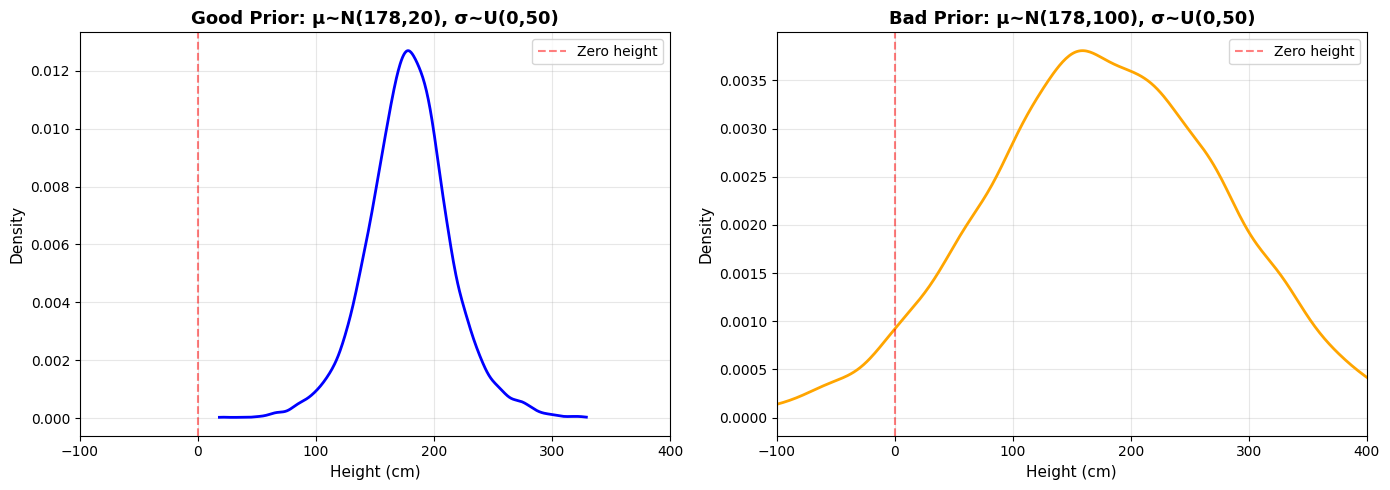

=== Prior Predictive Summary ===

Good Prior (μ~N(178,20)):
  Height range: [18.3, 329.1] cm
  Mean: 179.0 cm
  5th-95th percentile: [121.6, 237.5] cm
  Negative heights: 0 / 10000 (0.00%)

Bad Prior (μ~N(178,100)):
  Height range: [-238.5, 576.3] cm
  Mean: 178.2 cm
  5th-95th percentile: [5.0, 348.7] cm
  Negative heights: 449 / 10000 (4.49%)

✓ The good prior keeps heights in a reasonable range!
✗ The bad prior allows impossible values (negative, extremely tall)


In [31]:
# Simulate with bad prior (too vague)
mu_sd_bad = 100

sample_mu_bad = rng.normal(loc=mu_mean, scale=mu_sd_bad, size=n)
sample_sigma_bad = rng.uniform(low=sigma_low, high=sigma_high, size=n)
prior_h_bad = rng.normal(loc=sample_mu_bad, scale=sample_sigma_bad, size=n)

# Compute KDEs
kde_good = gaussian_kde(prior_h)
kde_bad = gaussian_kde(prior_h_bad)

x_h_good = np.linspace(prior_h.min(), prior_h.max(), 600)
x_h_bad = np.linspace(prior_h_bad.min(), prior_h_bad.max(), 600)

# Side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Good prior
ax1.plot(x_h_good, kde_good(x_h_good), 'b-', linewidth=2)
ax1.axvline(0, color='red', linestyle='--', alpha=0.5, label='Zero height')
ax1.set_title("Good Prior: μ~N(178,20), σ~U(0,50)", fontsize=13, fontweight='bold')
ax1.set_xlabel("Height (cm)", fontsize=11)
ax1.set_ylabel("Density", fontsize=11)
ax1.set_xlim(-100, 400)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bad prior
ax2.plot(x_h_bad, kde_bad(x_h_bad), 'orange', linewidth=2)
ax2.axvline(0, color='red', linestyle='--', alpha=0.5, label='Zero height')
ax2.set_title("Bad Prior: μ~N(178,100), σ~U(0,50)", fontsize=13, fontweight='bold')
ax2.set_xlabel("Height (cm)", fontsize=11)
ax2.set_ylabel("Density", fontsize=11)
ax2.set_xlim(-100, 400)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== Prior Predictive Summary ===")
print(f"\nGood Prior (μ~N(178,20)):")
print(f"  Height range: [{prior_h.min():.1f}, {prior_h.max():.1f}] cm")
print(f"  Mean: {prior_h.mean():.1f} cm")
print(f"  5th-95th percentile: [{np.percentile(prior_h, 5):.1f}, {np.percentile(prior_h, 95):.1f}] cm")
print(f"  Negative heights: {(prior_h < 0).sum()} / {n} ({100*(prior_h < 0).mean():.2f}%)")

print(f"\nBad Prior (μ~N(178,100)):")
print(f"  Height range: [{prior_h_bad.min():.1f}, {prior_h_bad.max():.1f}] cm")
print(f"  Mean: {prior_h_bad.mean():.1f} cm")
print(f"  5th-95th percentile: [{np.percentile(prior_h_bad, 5):.1f}, {np.percentile(prior_h_bad, 95):.1f}] cm")
print(f"  Negative heights: {(prior_h_bad < 0).sum()} / {n} ({100*(prior_h_bad < 0).mean():.2f}%)")

print("\n✓ The good prior keeps heights in a reasonable range!")
print("✗ The bad prior allows impossible values (negative, extremely tall)")

## Summary: What We've Learned

### Key Takeaways

1. **Gaussian models** are useful for continuous outcomes like height
2. **Prior predictive simulation** helps validate priors before seeing data
3. **Good priors** balance:
   - Domain knowledge (178cm is reasonable for average height)
   - Uncertainty (SD=20 allows variation)
   - Constraints (no negative heights, no giants)

### Next Steps

In the next sections, we'll:
1. **Compute the posterior** using grid approximation
2. **Sample from the posterior** to get distributions for μ and σ
3. **Make predictions** using the posterior predictive distribution
4. **Check model fit** against actual data

### Workflow Review

```
Choose Model → Choose Priors → Prior Predictive → Compute Posterior → Posterior Predictive
     ↓              ↓                ↓                    ↓                    ↓
  h~N(μ,σ)     μ~N(178,20)     Simulate heights    Use data to     Check model fit
              σ~U(0,50)        (no data yet!)      update beliefs  (with data)
```

## Step 5: Compute the Posterior using Grid Approximation

### NEW CHALLENGE: 2D Grid Approximation!

Previously (Chapter 3), we only had ONE parameter (p for globe tossing).  
Now we have **TWO parameters**: μ AND σ!

**The approach:**
1. Create a 2D grid of (μ, σ) combinations
2. Compute posterior probability at each grid point
3. Normalize so probabilities sum to 1

**The math:**
```
Posterior(μ, σ | data) ∝ Likelihood(data | μ, σ) × Prior(μ) × Prior(σ)
```

For each (μ, σ) pair on our grid:
- **Likelihood**: How well does this (μ, σ) explain the observed heights?
- **Prior**: How plausible is this (μ, σ) before seeing data?

### Why Grid Approximation?

- **Exact**: No sampling error (unlike MCMC)
- **Simple**: Easy to understand and implement
- **Limited**: Only works for 1-3 parameters (curse of dimensionality!)

For this problem: 100×100 = **10,000 grid points** to evaluate

### Mathematical Foundation: Computing the Posterior

#### Bayes' Theorem for Multiple Parameters

Our goal is to compute the **posterior distribution** P(μ, σ | data) - the probability of parameter values given observed heights.

**Full Bayes' Theorem:**

```
P(μ, σ | h₁, h₂, ..., h_n) = [∏ᵢ₌₁ⁿ P(hᵢ | μ, σ) × P(μ) × P(σ)] / [∫∫ ∏ᵢ₌₁ⁿ P(hᵢ | μ, σ) × P(μ) × P(σ) dμ dσ]
```

**Breaking it down:**

**Numerator (tractable to evaluate):**
- **Likelihood:** ∏ᵢ₌₁ⁿ P(hᵢ | μ, σ) = product over all 352 observations
- **Prior for μ:** P(μ) = Normal(178, 20)
- **Prior for σ:** P(σ) = Uniform(0, 50)

**Denominator (intractable to compute!):**
- ∫∫ [numerator] dμ dσ = **marginal likelihood** = P(data)
- This is a 2D integral over all possible (μ, σ) values
- **No closed-form solution** for this model!

**Grid approximation solution:** Evaluate numerator at grid points, then normalize by summing (discrete version of integration).

#### The Critical i.i.d. Assumption

**Why can we write the likelihood as a product?**

The formula above assumes heights are **i.i.d. (independent and identically distributed)**:

```
P(h₁, h₂, ..., h_n | μ, σ) = P(h₁|μ,σ) × P(h₂|μ,σ) × ... × P(h_n|μ,σ) = ∏ᵢ₌₁ⁿ P(hᵢ | μ, σ)
```

**What i.i.d. means:**
1. **Independent**: Knowing one height doesn't tell you about another
2. **Identically distributed**: All heights come from the same Normal(μ, σ)

**This is an EPISTEMIC (modeling) assumption, not ONTOLOGICAL (reality claim):**
- **Epistemic**: We model heights as if they're independent for tractability
- **Ontological**: Heights ARE truly independent in nature (probably false!)

**Reality check - violations we know about:**
- Males and females have different distributions (violates "identical")
- Family members have correlated heights (violates "independent")
- Geographic/ethnic patterns exist (violates "identical")

**Why we still use it:**
- Makes computation tractable (product form!)
- Good enough approximation for our purposes
- Baseline model - can add complexity later
- Violations can be detected and corrected

#### Why We Work on Log Scale (Numerical Stability)

**The Problem:** With n=352 observations, directly computing the product causes **underflow**:

```python
# Each P(hᵢ|μ,σ) ≈ 0.05 (small probability)
likelihood = 0.05 × 0.05 × ... × 0.05  # 352 times
# Result: ≈ 10⁻⁴⁶² (smaller than machine precision!) → UNDERFLOW
```

**The Solution:** Work on **log scale** where multiplication becomes addition:

```
log P(μ, σ | data) ∝ log[∏ᵢ P(hᵢ|μ,σ)] + log P(μ) + log P(σ)
                   = Σᵢ log P(hᵢ|μ,σ) + log P(μ) + log P(σ)
                     ↑ Sum instead of product!
```

**Why this works:**
1. **log(a × b) = log(a) + log(b)** → products become sums
2. **log is monotonic** → argmax(log f) = argmax(f)
3. **Exponentiation is stable** after normalization trick

**Example:**
```python
# Log scale: manageable numbers
log_likelihood = -3.0 + (-3.0) + ... + (-3.0)  # 352 times
# Result: ≈ -1056 ✓ (no underflow!)
```

---

### Technical Implementation: Meshgrid, Broadcasting, and Indexing

Now let's understand how the code implements this mathematically with efficient array operations.

#### Step 1: Create 1D Parameter Grids

```python
mu_list = np.linspace(150, 160, 100)     # Shape: (100,)
sigma_list = np.linspace(7, 9, 100)      # Shape: (100,)
```

These are simple 1D arrays of parameter values to evaluate.

#### Step 2: Meshgrid Creates 2D Parameter Combinations

```python
MU, SIGMA = np.meshgrid(mu_list, sigma_list, indexing="xy")
# Both have shape: (100, 100)
```

**What meshgrid does:** Creates ALL combinations of (μ, σ) in matrix form.

**MU matrix structure:**
```
MU = [[150.0, 150.1, 150.2, ..., 160.0],   ← Row 0
      [150.0, 150.1, 150.2, ..., 160.0],   ← Row 1 (same!)
      [150.0, 150.1, 150.2, ..., 160.0],   ← Row 2 (same!)
      ...
      [150.0, 150.1, 150.2, ..., 160.0]]   ← Row 99 (same!)
       ↑      ↑      ↑           ↑
     Col 0  Col 1  Col 2      Col 99
```
- **All rows are identical**
- **Varies horizontally** (across columns)
- MU[any_row, i] = mu_list[i]

**SIGMA matrix structure:**
```
SIGMA = [[7.0,  7.0,  7.0,  ..., 7.0 ],   ← Row 0
         [7.02, 7.02, 7.02, ..., 7.02],   ← Row 1
         [7.04, 7.04, 7.04, ..., 7.04],   ← Row 2
         ...
         [9.0,  9.0,  9.0,  ..., 9.0 ]]   ← Row 99
          ↑     ↑     ↑          ↑
        Col 0 Col 1 Col 2     Col 99
       (same!)(same!)(same!)  (same!)
```
- **All columns are identical**
- **Varies vertically** (across rows)
- SIGMA[j, any_col] = sigma_list[j]

**The coordinate system:**
- **Grid point [j, i]** represents parameter pair **(μᵢ, σⱼ)**
- **Rows (j) ↔ σ index**
- **Columns (i) ↔ μ index**

#### Step 3: Broadcasting to 3D for Vectorized Computation

We have:
- **y**: (352,) heights
- **MU, SIGMA**: (100, 100) parameter grids

We need to compute log P(hₖ | μᵢ, σⱼ) for ALL combinations of:
- k ∈ {1, 2, ..., 352} observations
- i ∈ {1, 2, ..., 100} μ values
- j ∈ {1, 2, ..., 100} σ values

**Total:** 100 × 100 × 352 = **3,520,000 log-likelihoods!**

**Broadcasting trick:**
```python
y_3d = y[None, None, :]      # (1, 1, 352) → broadcasts to (100, 100, 352)
MU_3d = MU[:, :, None]       # (100, 100, 1) → broadcasts to (100, 100, 352)
SIGMA_3d = SIGMA[:, :, None] # (100, 100, 1) → broadcasts to (100, 100, 352)
```

**Conceptual understanding of the 3D arrays:**

**y_3d (100, 100, 352):**
- Think: "100×100 matrix where each cell contains the same vector of 352 heights"
- y_3d[j, i, :] = [136.5, 149.3, ..., 179.1] for ALL (j, i)
- The height data is "repeated" across all parameter combinations

**MU_3d (100, 100, 352):**
- Think: "Each μ value is stretched/copied 352 times along 3rd dimension"
- MU_3d[j, i, :] = [MU[j,i], MU[j,i], ..., MU[j,i]] (same value 352 times)
- MU_3d[j, i, k] = mu_list[i] for all k

**SIGMA_3d (100, 100, 352):**
- Think: "Each σ value is stretched/copied 352 times along 3rd dimension"
- SIGMA_3d[j, i, :] = [SIGMA[j,i], SIGMA[j,i], ..., SIGMA[j,i]] (same value 352 times)
- SIGMA_3d[j, i, k] = sigma_list[j] for all k

**Memory efficiency note:** NumPy doesn't actually copy data - it uses **views** with broadcasting. Memory used is minimal!

#### Step 4: Vectorized Log-Likelihood Computation

```python
log_lik_per_obs = norm.logpdf(y_3d, loc=MU_3d, scale=SIGMA_3d)
# Result shape: (100, 100, 352)
```

**What happens:** NumPy computes all 3,520,000 log-likelihoods in ONE vectorized operation:

```python
log_lik_per_obs[j, i, k] = log P(y[k] | mu_list[i], sigma_list[j])
                         = log Normal(height_k; μᵢ, σⱼ)
```

At position [j, i, k]:
- Height: y[k] (k-th observation)
- Mean: mu_list[i] (i-th μ value)
- Std: sigma_list[j] (j-th σ value)

**No Python loops needed!** Pure vectorized NumPy.

#### Step 5: Sum Over Observations (Marginalize Over Data)

```python
loglik = np.sum(log_lik_per_obs, axis=2)
# Result shape: (100, 100)
```

**What this does:** For each parameter pair (μᵢ, σⱼ), sum the log-likelihoods across all 352 observations:

```python
loglik[j, i] = Σₖ₌₁³⁵² log_lik_per_obs[j, i, k]
             = Σₖ₌₁³⁵² log P(height_k | μᵢ, σⱼ)
             = log[∏ₖ₌₁³⁵² P(height_k | μᵢ, σⱼ)]
             = log P(all data | μᵢ, σⱼ)
```

**Result:** A (100, 100) matrix where each element is the **total log-likelihood** for that parameter pair.

#### Step 6: Add Log-Priors

```python
logprior_mu = norm.logpdf(MU, loc=178, scale=20)        # (100, 100)
logprior_sigma = uniform.logpdf(SIGMA, loc=0, scale=50) # (100, 100)

logposterior_unnorm = loglik + logprior_mu + logprior_sigma  # (100, 100)
```

For each grid point [j, i]:
```python
logposterior_unnorm[j, i] = log P(data | μᵢ, σⱼ) + log P(μᵢ) + log P(σⱼ)
                          = log[P(data | μᵢ, σⱼ) × P(μᵢ) × P(σⱼ)]
                          ∝ log P(μᵢ, σⱼ | data)  [unnormalized]
```

#### Step 7: Exponentiate and Normalize

```python
# Numerical stability trick: subtract max before exponentiating
logposterior_unnorm = logposterior_unnorm - np.max(logposterior_unnorm)
posterior_unnorm = np.exp(logposterior_unnorm)

# Normalize so it sums to 1 (discrete probability distribution)
posterior = posterior_unnorm / posterior_unnorm.sum()
```

**Final result:** 
```python
posterior[j, i] = P(μ = mu_list[i], σ = sigma_list[j] | data)
```

A (100, 100) matrix representing the **full 2D posterior distribution** over (μ, σ).

#### Index Mapping Reference

**To query the posterior probability for a specific parameter pair:**

```python
# Want: P(μ = 155.5, σ = 8.0 | data)

# Step 1: Find indices
i = np.argmin(np.abs(mu_list - 155.5))    # Find closest μ index
j = np.argmin(np.abs(sigma_list - 8.0))   # Find closest σ index

# Step 2: Look up in posterior
prob = posterior[j, i]  # P(μ≈155.5, σ≈8.0 | data)

# Verify the values:
mu_value = MU[j, i]      # or mu_list[i]
sigma_value = SIGMA[j, i] # or sigma_list[j]
```

**Remember the coordinate system:**
- posterior[row, col] = posterior[σ_index, μ_index]
- Rows ↔ sigma_list indices
- Columns ↔ mu_list indices

---

### Summary: From Math to Code

**Mathematical goal:**
```
P(μ, σ | data) = [∏ᵢ P(hᵢ|μ,σ) × P(μ) × P(σ)] / [normalizing constant]
```

**Computational implementation:**
1. Create parameter grids: mu_list, sigma_list (100 points each)
2. Meshgrid: Create all (μ, σ) combinations → MU, SIGMA matrices (100×100)
3. Broadcasting: Expand to 3D (100×100×352) to compute all likelihoods at once
4. Vectorized PDF: Compute 3.5M log-likelihoods in one operation
5. Sum observations: Collapse 3D → 2D by summing over data (axis=2)
6. Add log-priors: Element-wise addition on log scale
7. Normalize: Exponentiate and divide by sum

**Result:** Exact posterior distribution P(μ, σ | data) on a discrete grid!

**Key insights:**
- i.i.d. assumption enables product form of likelihood
- Log scale prevents numerical underflow with many observations
- Broadcasting enables massive parallelization (3.5M operations at once!)
- Grid approximation sidesteps intractable integral via discrete normalization

In [32]:
# ============================================
# 2D GRID APPROXIMATION FOR POSTERIOR
# ============================================
# This is more complex than Chapter 3 because we have TWO parameters!

import numpy as np
from scipy.stats import norm, uniform

# ----- STEP 1: Prepare the data -----
y = adult_height  # Rename for clarity (y = observed heights)
print(f"Number of observations: {len(y)}")
print(f"Data range: [{y.min():.1f}, {y.max():.1f}] cm")

# ----- STEP 2: Define grids for parameters -----
# We need to guess reasonable ranges based on our prior knowledge and EDA

# For μ: We saw in EDA that adult mean ≈ 154cm
# Let's search in a range around that
mu_list = np.linspace(150, 160, 100)  # 100 evenly-spaced values

# For σ: We saw SD ≈ 7.7cm in EDA
# Let's search in a range around that
sigma_list = np.linspace(7, 9, 100)   # 100 evenly-spaced values

print(f"\nGrid dimensions:")
print(f"  μ range: [{mu_list[0]:.1f}, {mu_list[-1]:.1f}] with {len(mu_list)} points")
print(f"  σ range: [{sigma_list[0]:.1f}, {sigma_list[-1]:.1f}] with {len(sigma_list)} points")
print(f"  Total grid points: {len(mu_list) * len(sigma_list):,}")

# ----- STEP 3: Create 2D meshgrid -----
# NEW CONCEPT: np.meshgrid creates all (μ, σ) combinations
# Think of it like expand.grid() in R
#
# Result: MU and SIGMA are both (100, 100) matrices where:
#   MU[i,j] = j-th value of mu_list (varies across columns)
#   SIGMA[i,j] = i-th value of sigma_list (varies across rows)

MU, SIGMA = np.meshgrid(mu_list, sigma_list, indexing="xy")

# Example: MU[0, :] = [150.0, 150.1, 150.2, ..., 160.0]
#          SIGMA[:, 0] = [7.0, 7.02, 7.04, ..., 9.0]

# ----- STEP 4: Compute log-likelihood for each (μ, σ) pair -----
# NEW CONCEPT: Broadcasting in 3D!
#
# For each (μ, σ) pair, compute:
#   log-likelihood = sum of log P(y_i | μ, σ) over all observations
#
# We use norm.logpdf for numerical stability (avoids underflow)
# Shape gymnastics:
#   y:     shape (352,)           → reshape to (1, 1, 352)
#   MU:    shape (100, 100)       → broadcast to (100, 100, 352)
#   SIGMA: shape (100, 100)       → broadcast to (100, 100, 352)
#   Result after sum: shape (100, 100)

# Add dimensions to y for broadcasting
y_3d = y[None, None, :]  # Shape: (1, 1, 352)
MU_3d = MU[:, :, None]   # Shape: (100, 100, 1) → broadcasts to (100, 100, 352)
SIGMA_3d = SIGMA[:, :, None]  # Shape: (100, 100, 1) → broadcasts to (100, 100, 352)

# Compute log P(y_i | μ, σ) for all y_i and all (μ, σ)
# Result shape: (100, 100, 352)
log_lik_per_obs = norm.logpdf(y_3d, loc=MU_3d, scale=SIGMA_3d)

# Sum over observations (axis=2) → shape (100, 100)
loglik = np.sum(log_lik_per_obs, axis=2)

print(f"\nLog-likelihood computed:")
print(f"  Shape: {loglik.shape}")
print(f"  Range: [{loglik.min():.1f}, {loglik.max():.1f}]")

# ----- STEP 5: Add log-priors -----
# Prior for μ: Normal(178, 20)
logprior_mu = norm.logpdf(MU, loc=178, scale=20)

# Prior for σ: Uniform(0, 50)
logprior_sigma = uniform.logpdf(SIGMA, loc=0, scale=50)

# Combine (still on log scale)
# log P(μ, σ | data) ∝ log P(data | μ, σ) + log P(μ) + log P(σ)
logposterior_unnorm = loglik + logprior_mu + logprior_sigma

# ----- STEP 6: Exponentiate (careful with numerical stability!) -----
# Subtract maximum to avoid overflow when exponentiating
# This doesn't change the shape, just prevents exp() from exploding
logposterior_unnorm = logposterior_unnorm - np.max(logposterior_unnorm)

# Now safe to exponentiate
posterior_unnorm = np.exp(logposterior_unnorm)

# ----- STEP 7: Normalize to get proper probability distribution -----
# Make it sum to 1 so it's a discrete probability distribution
posterior = posterior_unnorm / posterior_unnorm.sum()

print(f"\nPosterior computed:")
print(f"  Shape: {posterior.shape}")
print(f"  Sum: {posterior.sum():.6f} (should be 1.0)")
print(f"  Max probability: {posterior.max():.6f}")

print("\n✓ Posterior computation complete!")
print("="*70)

Number of observations: 352
Data range: [136.5, 179.1] cm

Grid dimensions:
  μ range: [150.0, 160.0] with 100 points
  σ range: [7.0, 9.0] with 100 points
  Total grid points: 10,000

Log-likelihood computed:
  Shape: (100, 100)
  Range: [-1328.0, -1219.4]

Posterior computed:
  Shape: (100, 100)
  Sum: 1.000000 (should be 1.0)
  Max probability: 0.002682

✓ Posterior computation complete!


### Visualize the 2D Posterior

The posterior is a **2D probability distribution** over (μ, σ).  
We can visualize it as:
1. **Heatmap**: Color intensity shows probability
2. **Contour plot**: Lines connect points of equal probability

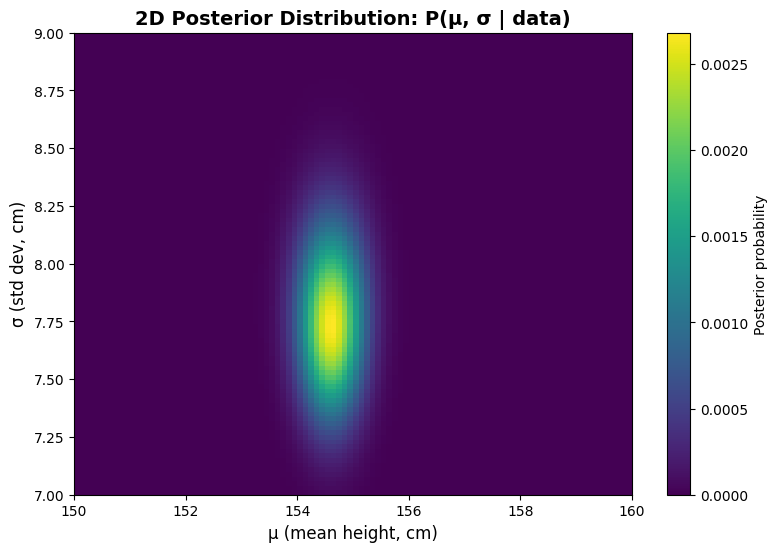

In [33]:
# Visualize posterior as a heatmap
plt.figure(figsize=(9, 6))

# imshow displays a 2D array as an image
# Each pixel's color represents the posterior probability at that (μ, σ)
plt.imshow(
    posterior,
    origin="lower",  # Put (0,0) at bottom-left (not top-left)
    aspect="auto",   # Don't force square pixels
    extent=[mu_list.min(), mu_list.max(), sigma_list.min(), sigma_list.max()],
    cmap='viridis'   # Color scheme (yellow=high, purple=low)
)

plt.xlabel("μ (mean height, cm)", fontsize=12)
plt.ylabel("σ (std dev, cm)", fontsize=12)
plt.title("2D Posterior Distribution: P(μ, σ | data)", fontsize=14, fontweight='bold')
plt.colorbar(label="Posterior probability")
plt.grid(False)  # Turn off grid for heatmap
plt.show()

# INTERPRETATION:
# - Bright region = high posterior probability (most plausible values)
# - Dark region = low posterior probability (implausible given data)
# - The bright spot is around μ≈154, σ≈7.7 (close to sample statistics!)

MAP (Maximum A Posteriori) Estimates:
MAP μ: 154.65 cm
MAP σ: 7.73 cm

Compare to sample statistics:
Sample mean: 154.60 cm
Sample SD: 7.73 cm

Difference:
  μ diff: 0.049 cm
  σ diff: 0.004 cm


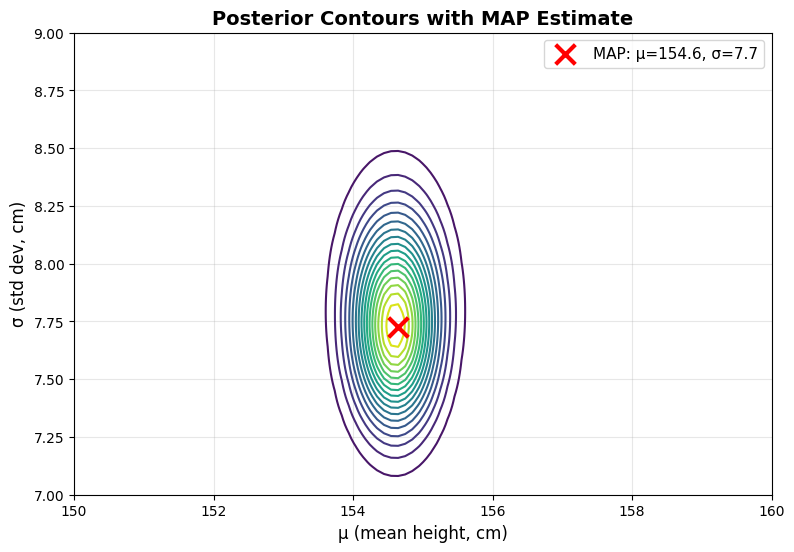

In [34]:
# Find the location of maximum posterior probability
# np.argmax finds the INDEX of the maximum value in the flattened array
# np.unravel_index converts flat index back to (row, col) coordinates

idx = np.unravel_index(np.argmax(posterior), posterior.shape)
# idx[0] = row index (corresponds to sigma_list)
# idx[1] = column index (corresponds to mu_list)

sigma_map = sigma_list[idx[0]]
mu_map = mu_list[idx[1]]

print("="*60)
print("MAP (Maximum A Posteriori) Estimates:")
print("="*60)
print(f"MAP μ: {mu_map:.2f} cm")
print(f"MAP σ: {sigma_map:.2f} cm")
print(f"\nCompare to sample statistics:")
print(f"Sample mean: {adult_height.mean():.2f} cm")
print(f"Sample SD: {adult_height.std():.2f} cm")
print(f"\nDifference:")
print(f"  μ diff: {abs(mu_map - adult_height.mean()):.3f} cm")
print(f"  σ diff: {abs(sigma_map - adult_height.std()):.3f} cm")
print("="*60)

# Visualize MAP on contour plot
plt.figure(figsize=(9, 6))

# Contour plot shows lines of equal probability
plt.contour(mu_list, sigma_list, posterior, levels=20, cmap='viridis')

# Mark the MAP point with a red X
plt.scatter([mu_map], [sigma_map], marker="x", s=200, c='red', 
            linewidths=3, label=f'MAP: μ={mu_map:.1f}, σ={sigma_map:.1f}', zorder=5)

plt.xlabel("μ (mean height, cm)", fontsize=12)
plt.ylabel("σ (std dev, cm)", fontsize=12)
plt.title("Posterior Contours with MAP Estimate", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# KEY INSIGHT: MAP estimates are very close to sample statistics!
# This happens when:
# 1. We have lots of data (352 adults)
# 2. Prior is weak (doesn't dominate the data)
# With less data, MAP would be pulled toward the prior

### Compute Marginal Distributions

**KEY CONCEPT: Marginalization**

We have the **joint posterior** P(μ, σ | data), but sometimes we want:
- P(μ | data) **regardless** of what σ is
- P(σ | data) **regardless** of what μ is

These are called **marginal distributions**.

**How to marginalize:**
- To get P(μ | data): Sum posterior over all possible σ values
- To get P(σ | data): Sum posterior over all possible μ values

**Why this works:**
```
P(μ | data) = ∫ P(μ, σ | data) dσ
```
In discrete grid approximation, integral becomes sum!

#### Mathematical Foundation of Marginalization

**The goal:** From the joint posterior P(μ, σ | data), obtain marginal distributions P(μ | data) and P(σ | data).

**Why marginalize?** Sometimes we only care about ONE parameter, regardless of the other:
- P(μ | data) tells us about plausible mean heights, **integrating over uncertainty in σ**
- P(σ | data) tells us about plausible variation, **integrating over uncertainty in μ**

**The mathematical definition:**

```
P(μ | data) = ∫ P(μ, σ | data) dσ     [Integrate over all σ]
P(σ | data) = ∫ P(μ, σ | data) dμ     [Integrate over all μ]
```

**In words:** "Sum up the joint probability over the variable you want to remove"

**In discrete grid approximation:** Integral → Sum!

```
P(μ | data) = Σⱼ P(μ, σⱼ | data)      [Sum over all σ values]
P(σ | data) = Σᵢ P(μᵢ, σ | data)      [Sum over all μ values]
```

#### Technical Implementation with Array Operations

**Remember our coordinate system:**
- posterior[j, i] = P(μᵢ, σⱼ | data)
- Rows (j) ↔ σ indices  
- Columns (i) ↔ μ indices

**To get P(μ | data):** For each μ value (column), sum across all σ values (rows)

```python
p_mu = posterior.sum(axis=0)  # Sum over axis 0 (rows) → (100,)
```

**Visual interpretation:**
```
posterior = [[P(μ₀,σ₀), P(μ₁,σ₀), ..., P(μ₉₉,σ₀)],    ← σ₀
             [P(μ₀,σ₁), P(μ₁,σ₁), ..., P(μ₉₉,σ₁)],    ← σ₁
             ...
             [P(μ₀,σ₉₉), P(μ₁,σ₉₉), ..., P(μ₉₉,σ₉₉)]]  ← σ₉₉
              ↓          ↓               ↓
              μ₀         μ₁              μ₉₉

p_mu[i] = Σⱼ posterior[j, i]  # Sum column i (all rows)
```

For μ₀: p_mu[0] = P(μ₀,σ₀) + P(μ₀,σ₁) + ... + P(μ₀,σ₉₉)

**To get P(σ | data):** For each σ value (row), sum across all μ values (columns)

```python
p_sigma = posterior.sum(axis=1)  # Sum over axis 1 (cols) → (100,)
```

**Visual interpretation:**
```
p_sigma[j] = Σᵢ posterior[j, i]  # Sum row j (all columns)
```

For σ₀: p_sigma[0] = P(μ₀,σ₀) + P(μ₁,σ₀) + ... + P(μ₉₉,σ₀)

**Renormalization:** After summing, the marginal should still sum to 1:

```python
p_mu = p_mu / p_mu.sum()        # Ensure P(μ | data) sums to 1
p_sigma = p_sigma / p_sigma.sum()  # Ensure P(σ | data) sums to 1
```

**Result:**
- p_mu: (100,) array where p_mu[i] = P(μ = mu_list[i] | data)
- p_sigma: (100,) array where p_sigma[j] = P(σ = sigma_list[j] | data)

**Key insight:** Marginalization "removes" a variable by summing over all its possible values. This is how we move from 2D (joint) → 1D (marginal).

In [35]:
# ============================================
# MARGINALIZATION: From Joint to Marginal Distributions
# ============================================

# Our posterior has shape (100, 100) representing P(μ, σ | data)
# Rows correspond to different σ values
# Columns correspond to different μ values

# Marginal of μ: P(μ | data) regardless of σ
# HOW: Sum over all rows (all σ values) for each μ
# Think: "For this μ, sum probability across ALL possible σ"
p_mu = posterior.sum(axis=0)  # Sum over axis 0 (rows/sigma) → shape (100,)
p_mu = p_mu / p_mu.sum()      # Renormalize to ensure it sums to 1

# Marginal of σ: P(σ | data) regardless of μ
# HOW: Sum over all columns (all μ values) for each σ
# Think: "For this σ, sum probability across ALL possible μ"
p_sigma = posterior.sum(axis=1)  # Sum over axis 1 (cols/mu) → shape (100,)
p_sigma = p_sigma / p_sigma.sum()  # Renormalize to ensure it sums to 1

print("="*60)
print("MARGINAL DISTRIBUTIONS COMPUTED")
print("="*60)
print(f"P(μ | data):")
print(f"  Shape: {p_mu.shape}")
print(f"  Sums to: {p_mu.sum():.6f}")
print(f"\nP(σ | data):")
print(f"  Shape: {p_sigma.shape}")
print(f"  Sums to: {p_sigma.sum():.6f}")
print("="*60)

# INTERPRETATION:
# p_mu tells us: "What are plausible values of μ, averaging over uncertainty in σ?"
# p_sigma tells us: "What are plausible values of σ, averaging over uncertainty in μ?"

MARGINAL DISTRIBUTIONS COMPUTED
P(μ | data):
  Shape: (100,)
  Sums to: 1.000000

P(σ | data):
  Shape: (100,)
  Sums to: 1.000000


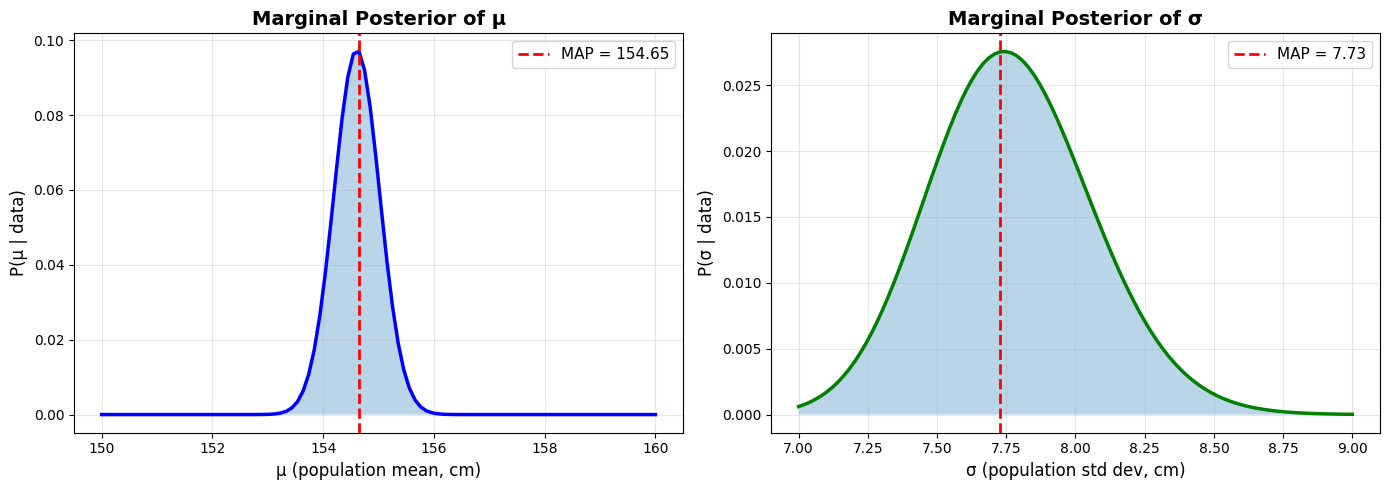


Marginal statistics:
P(μ | data): mean=154.61, std=0.41
P(σ | data): mean=7.77, std=0.29


In [36]:
# Plot the marginal distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Marginal of μ
ax1.plot(mu_list, p_mu, 'b-', linewidth=2.5)
ax1.fill_between(mu_list, p_mu, alpha=0.3)
ax1.axvline(mu_map, color='red', linestyle='--', linewidth=2, 
            label=f'MAP = {mu_map:.2f}')
ax1.set_xlabel("μ (population mean, cm)", fontsize=12)
ax1.set_ylabel("P(μ | data)", fontsize=12)
ax1.set_title("Marginal Posterior of μ", fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Marginal of σ
ax2.plot(sigma_list, p_sigma, 'g-', linewidth=2.5)
ax2.fill_between(sigma_list, p_sigma, alpha=0.3)
ax2.axvline(sigma_map, color='red', linestyle='--', linewidth=2,
            label=f'MAP = {sigma_map:.2f}')
ax2.set_xlabel("σ (population std dev, cm)", fontsize=12)
ax2.set_ylabel("P(σ | data)", fontsize=12)
ax2.set_title("Marginal Posterior of σ", fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# KEY OBSERVATIONS:
# 1. Both marginals are roughly bell-shaped
# 2. μ has narrower distribution (more certain) than σ
# 3. MAP estimates are at the peaks (by definition!)
#
# WHY is μ more certain than σ?
# - Mean is easier to estimate than variance from data
# - Variance has more inherent uncertainty

print("\nMarginal statistics:")
print(f"P(μ | data): mean={np.sum(mu_list * p_mu):.2f}, std={np.sqrt(np.sum((mu_list - np.sum(mu_list * p_mu))**2 * p_mu)):.2f}")
print(f"P(σ | data): mean={np.sum(sigma_list * p_sigma):.2f}, std={np.sqrt(np.sum((sigma_list - np.sum(sigma_list * p_sigma))**2 * p_sigma)):.2f}")

### Find the MAP (Maximum A Posteriori) Estimate

**MAP** = The (μ, σ) pair with highest posterior probability  
This is the "most plausible" parameter values given the data.

### Sample from the Posterior

**Why sample when we have the exact posterior?**

Grid approximation gives us the FULL posterior, but:
- Easier to work with **samples** for downstream tasks
- Can compute any statistic (quantiles, intervals, predictions)
- Matches workflow for MCMC (Chapter 9)

**The challenge:** Sampling from a 2D discrete distribution

**The approach:**
1. Flatten the 2D posterior into a 1D array
2. Sample grid indices proportional to their probabilities
3. Convert indices back to (μ, σ) values

#### Mathematical Foundation: Sampling from Discrete 2D Distribution

**The challenge:** We have a 2D discrete posterior distribution on a 100×100 grid. How do we draw random samples (μ, σ) from it?

**Why sample?**
- Compute any statistic (mean, quantiles, credible intervals)
- Make predictions via posterior predictive distribution
- Propagate uncertainty through downstream calculations
- Practice for MCMC (Chapter 9) which also produces samples

**The approach:** Clever index manipulation!

1. **Flatten 2D → 1D:** Treat the 100×100 grid as 10,000 outcomes
2. **Sample flat indices:** Draw indices proportional to probabilities
3. **Unravel indices:** Convert flat indices back to (row, col) = (σ_index, μ_index)
4. **Look up values:** Use indices to get actual (μ, σ) values

#### Detailed Step-by-Step Breakdown

**Step 1: Flatten the 2D posterior into a 1D array**

```python
posterior.shape = (100, 100)
flat_post = posterior.ravel()  # Shape: (10000,)
```

**What ravel() does:** Flattens row-by-row (row-major order)

```
posterior = [[p₀₀, p₀₁, ..., p₀₉₉],     Row 0
             [p₁₀, p₁₁, ..., p₁₉₉],     Row 1
             ...
             [p₉₉₀, p₉₉₁, ..., p₉₉₉]]   Row 99

flat_post = [p₀₀, p₀₁, ..., p₀₉₉, p₁₀, p₁₁, ..., p₉₉₉]
             ↑                      ↑                  ↑
          Index 0               Index 100       Index 9999
```

**Key:** flat_post[k] = posterior[j, i] where k = j * 100 + i (row-major order)

**Step 2: Sample flat indices proportional to probabilities**

```python
draws = rng.choice(flat_post.size, size=10_000, replace=True, p=flat_post)
# draws = [5432, 234, 5431, 6789, ...]  (array of integers 0-9999)
```

**What this does:** 
- If flat_post[5432] = 0.00268 (high probability), index 5432 will be sampled often
- If flat_post[234] = 0.00001 (low probability), index 234 will be sampled rarely

**Each draw is an integer from 0 to 9,999**, representing a grid cell.

**Step 3: Convert flat indices back to 2D (row, col) indices**

```python
rows, cols = np.unravel_index(draws, posterior.shape)
```

**What unravel_index() does:** Inverse of ravel() - converts flat index to (row, col)

```
Flat index k → (row, col) = (k // 100, k % 100)
```

**Example:**
- draws[0] = 5432 → unravel → (54, 32) → σ_index=54, μ_index=32
- draws[1] = 234  → unravel → (2, 34)  → σ_index=2, μ_index=34
- draws[2] = 9999 → unravel → (99, 99) → σ_index=99, μ_index=99

**Result:**
- rows = [54, 2, 99, ...]  (σ indices)
- cols = [32, 34, 99, ...]  (μ indices)

**Step 4: Convert indices to actual parameter values**

```python
mu_samples = mu_list[cols]      # Look up μ values
sigma_samples = sigma_list[rows]  # Look up σ values
```

**Mapping:**
- mu_samples[i] = mu_list[cols[i]]
- sigma_samples[i] = sigma_list[rows[i]]

**Example from above:**
- Sample 0: μ = mu_list[32], σ = sigma_list[54]
- Sample 1: μ = mu_list[34], σ = sigma_list[2]
- Sample 2: μ = mu_list[99], σ = sigma_list[99]

**Final result:** Two arrays of length 10,000:
- mu_samples: Random draws from P(μ | data)
- sigma_samples: Random draws from P(σ | data)
- Together: (mu_samples[i], sigma_samples[i]) is a draw from P(μ, σ | data)

#### Why This Works

**The clever insight:** By sampling flat indices proportional to flat_post probabilities, we're effectively sampling (μ, σ) pairs proportional to posterior[j, i].

**Mathematical justification:**

```
P(sample flat index k) = flat_post[k]  
                       = posterior[j, i]  where (j,i) = unravel(k)
                       = P(μᵢ, σⱼ | data)
```

So sampling k → unraveling to (j,i) → looking up (μᵢ, σⱼ) gives us a sample from P(μ, σ | data)!

#### Complete Algorithm Summary

```python
# 1. Start with 2D posterior (100, 100)
posterior[j, i] = P(μᵢ, σⱼ | data)

# 2. Flatten to 1D (10,000,)
flat_post = posterior.ravel()

# 3. Sample 10,000 flat indices (with replacement)
draws = rng.choice(10000, size=10000, replace=True, p=flat_post)

# 4. Convert flat indices → 2D indices
rows, cols = np.unravel_index(draws, (100, 100))

# 5. Look up actual parameter values
mu_samples = mu_list[cols]       # Convert μ indices → μ values
sigma_samples = sigma_list[rows]  # Convert σ indices → σ values
```

**Result:** 10,000 samples from P(μ, σ | data) that capture the full uncertainty in both parameters!

#### Visual Summary

```
2D Posterior Grid (100×100)
      ↓ ravel()
1D Flat Array (10,000)
      ↓ sample indices (weighted by probability)
Flat Indices [5432, 234, ...]
      ↓ unravel_index()
2D Indices: rows=[54, 2, ...], cols=[32, 34, ...]
      ↓ look up in parameter lists
Parameter Samples: μ=[154.2, 153.8, ...], σ=[7.8, 7.1, ...]
```

**Key insight:** This flattening trick lets us sample from ANY discrete 2D distribution using simple 1D sampling!

In [37]:
# ============================================
# SAMPLING FROM THE 2D POSTERIOR
# ============================================
# This is TRICKY because we have a 2D grid, not a simple list!

rng = np.random.default_rng(123)  # Set seed for reproducibility
n_samples = 10_000

# STEP 1: Flatten the 2D posterior into 1D
# posterior shape: (100, 100) → flat_post shape: (10000,)
# This treats each grid cell as a single outcome
flat_post = posterior.ravel()  # or .flatten()

# Ensure it sums to 1 (should already, but be safe)
flat_post = flat_post / flat_post.sum()

# STEP 2: Sample grid cell INDICES proportional to their probabilities
# np.random.choice samples integers from 0 to flat_post.size-1
# with probabilities given by flat_post
#
# Example: If cell 5432 has high probability, it will be sampled often
draws = rng.choice(flat_post.size, size=n_samples, replace=True, p=flat_post)
# draws is array of integers: [5432, 234, 5431, 6789, ...]

# STEP 3: Convert flat indices back to 2D (row, col) indices
# np.unravel_index is the inverse of .ravel()
#
# If draws[i] = 5432, this tells us:
# - Which row (σ index)?
# - Which column (μ index)?
rows, cols = np.unravel_index(draws, posterior.shape)

# STEP 4: Convert indices to actual parameter values
# rows[i] tells us which sigma_list entry
# cols[i] tells us which mu_list entry
mu_samples = mu_list[cols]
sigma_samples = sigma_list[rows]

print("="*70)
print("POSTERIOR SAMPLES")
print("="*70)
print(f"Number of samples: {n_samples:,}")
print(f"\nμ samples:")
print(f"  Mean: {mu_samples.mean():.3f} cm")
print(f"  SD: {mu_samples.std():.3f} cm")
print(f"  5th-95th percentile: [{np.percentile(mu_samples, 5):.2f}, {np.percentile(mu_samples, 95):.2f}] cm")

print(f"\nσ samples:")
print(f"  Mean: {sigma_samples.mean():.3f} cm")
print(f"  SD: {sigma_samples.std():.3f} cm")
print(f"  5th-95th percentile: [{np.percentile(sigma_samples, 5):.2f}, {np.percentile(sigma_samples, 95):.2f}] cm")

# Compare to MAP
print(f"\nMAP estimates for comparison:")
print(f"  μ_MAP = {mu_map:.3f} cm")
print(f"  σ_MAP = {sigma_map:.3f} cm")

print("\n✓ Now we can use these samples for any downstream analysis!")
print("="*70)

# THESE SAMPLES CAPTURE THE FULL UNCERTAINTY IN BOTH PARAMETERS!
# This is different from just using point estimates (like MAP)

POSTERIOR SAMPLES
Number of samples: 10,000

μ samples:
  Mean: 154.610 cm
  SD: 0.415 cm
  5th-95th percentile: [153.94, 155.25] cm

σ samples:
  Mean: 7.766 cm
  SD: 0.288 cm
  5th-95th percentile: [7.30, 8.25] cm

MAP estimates for comparison:
  μ_MAP = 154.646 cm
  σ_MAP = 7.727 cm

✓ Now we can use these samples for any downstream analysis!


## Step 6: Posterior Predictive Simulation

### Completing the Bayesian Workflow

We've now completed the core inference:
1. ✅ Specified priors: P(μ), P(σ)
2. ✅ Observed data: 352 adult heights
3. ✅ Computed posterior: P(μ, σ | data)
4. ✅ Drew samples: 10,000 (μ, σ) pairs

**Now the crucial question:** Does our model generate data that looks like what we observed?

### What is Posterior Predictive Simulation?

**Posterior predictive distribution:** The distribution of **new/future data** we'd expect to see, given:
- Our model structure: h ~ Normal(μ, σ)
- The data we've already observed (via the posterior)

**Mathematical definition:**

```
P(h_new | data) = ∫∫ P(h_new | μ, σ) × P(μ, σ | data) dμ dσ
```

Where:
- P(h_new | μ, σ) = **Likelihood** (same as before!)
- P(μ, σ | data) = **Posterior** (updated from data)
- P(h_new | data) = **Posterior predictive** (what we want!)

**In words:** "What heights would we predict for new individuals, averaging over our **posterior uncertainty** in (μ, σ)?"

### Prior Predictive vs Posterior Predictive

**The structure is IDENTICAL - only the parameter distributions change!**

| Stage | Parameter Distribution | Purpose |
|-------|------------------------|---------|
| **Prior Predictive** | Sample from P(θ) | Validate priors **before** seeing data |
| **Posterior Predictive** | Sample from P(θ \| data) | Check model fit **after** seeing data |

**Prior predictive algorithm:**
```python
for i in 1:N:
    μ[i] ~ P(μ)              # Prior
    σ[i] ~ P(σ)              # Prior
    h[i] ~ Normal(μ[i], σ[i])
```

**Posterior predictive algorithm (same structure!):**
```python
for i in 1:N:
    μ[i] ~ P(μ | data)       # Posterior ← Data updated!
    σ[i] ~ P(σ | data)       # Posterior ← Data updated!
    h[i] ~ Normal(μ[i], σ[i])  # Same likelihood!
```

**Key difference:** 
- Prior predictive: Parameters have **wide, uncertain** distributions
- Posterior predictive: Parameters have **narrow, data-informed** distributions

### Why Do This?

**Model checking:** If our model is good, posterior predictive samples should:
- Have similar mean/SD to actual data
- Capture the shape of the actual distribution
- Include most of the observed values

**If predictions don't match data:**
- Model is misspecified (wrong distributional assumption)
- Missing important predictors (like sex!)
- Need more complex model

### Monte Carlo Implementation

**Good news:** We already have 10,000 samples from P(μ, σ | data)!

**Algorithm:**
```python
# We already have:
# mu_samples[i] ~ P(μ | data)
# sigma_samples[i] ~ P(σ | data)

# For each posterior sample, generate one predicted height:
for i in 1:10000:
    h_pred[i] ~ Normal(mu_samples[i], sigma_samples[i])
```

**Result:** 10,000 predicted heights that capture:
1. **Parameter uncertainty** (different μ, σ for each prediction)
2. **Data variation** (sampling from Normal(μ, σ))

This is the **full predictive distribution** for a new individual!

POSTERIOR PREDICTIVE SIMULATION
Generated 10,000 predicted heights

Predicted height statistics:
  Mean: 154.64 cm
  SD: 7.81 cm
  5th-95th percentile: [141.9, 167.5] cm

Actual data statistics (for comparison):
  Mean: 154.60 cm
  SD: 7.73 cm
  5th-95th percentile: [142.9, 167.0] cm

Differences:
  Mean difference: 0.04 cm
  SD difference: 0.08 cm


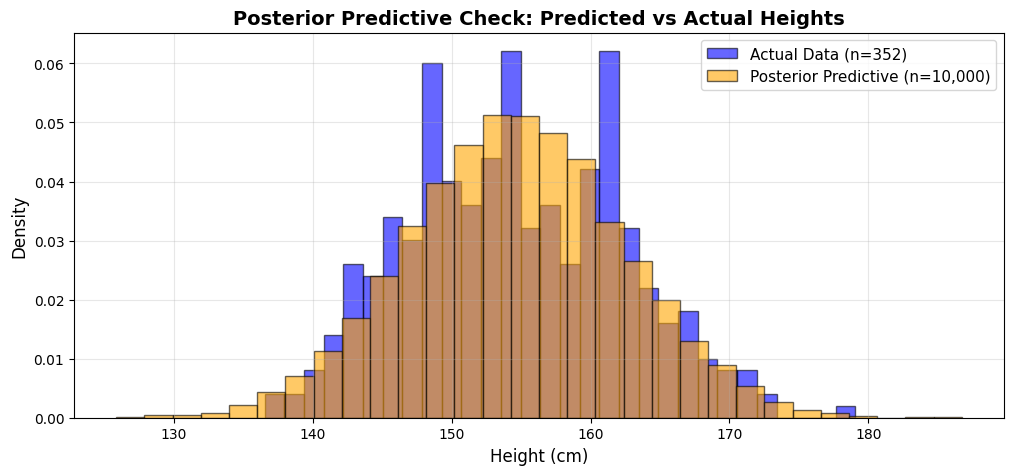

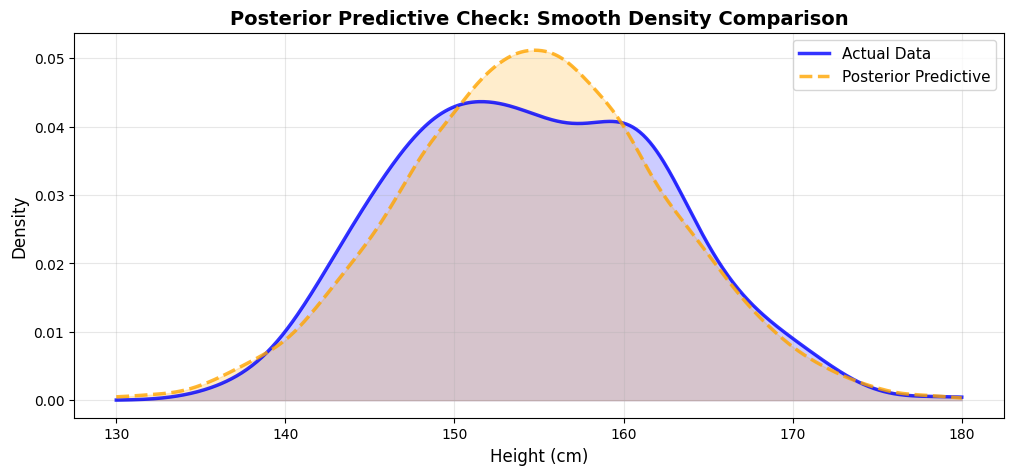

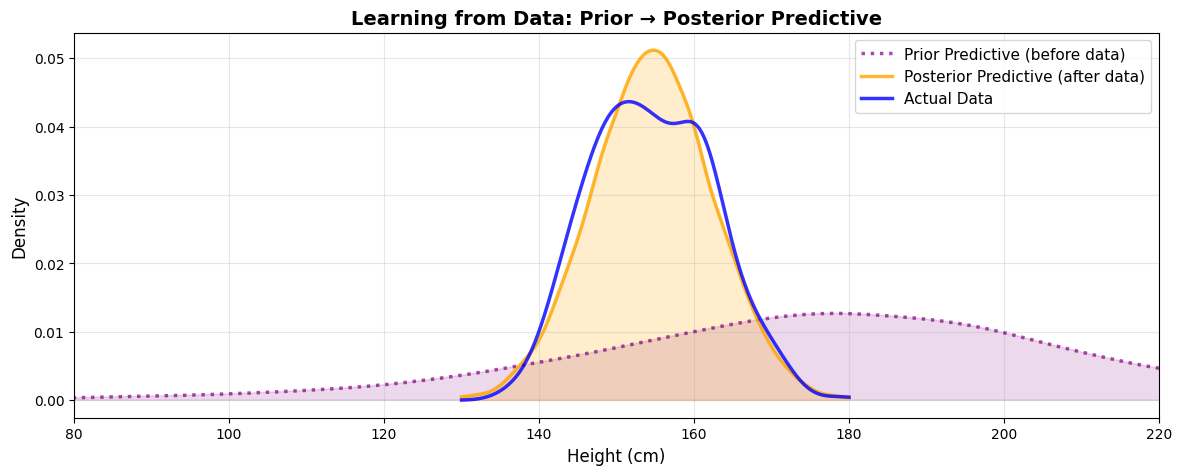


KEY OBSERVATIONS:
1. Prior predictive: Very wide, uncertain (before seeing data)
2. Posterior predictive: Narrow, concentrated around data (after seeing data)
3. Posterior predictive is much closer to actual data!
4. BUT: Posterior predictive is smoother than actual data
   → Actual data shows slight bimodality (male/female)
   → Our model assumes single Normal → can't capture this!


In [38]:
# ============================================
# POSTERIOR PREDICTIVE SIMULATION
# ============================================
# Generate predicted heights using posterior samples

# We already have posterior samples:
# - mu_samples: 10,000 samples from P(μ | data)
# - sigma_samples: 10,000 samples from P(σ | data)

# For each (μ, σ) pair, generate ONE predicted height
# This is vectorized - numpy does all 10,000 at once!
rng = np.random.default_rng(456)  # New seed for predictions
posterior_pred_h = rng.normal(loc=mu_samples, scale=sigma_samples)

# Result: 10,000 predicted heights
# Each uses a different (μ, σ) from the posterior
# This captures BOTH parameter uncertainty AND sampling variation

print("="*70)
print("POSTERIOR PREDICTIVE SIMULATION")
print("="*70)
print(f"Generated {len(posterior_pred_h):,} predicted heights")
print(f"\nPredicted height statistics:")
print(f"  Mean: {posterior_pred_h.mean():.2f} cm")
print(f"  SD: {posterior_pred_h.std():.2f} cm")
print(f"  5th-95th percentile: [{np.percentile(posterior_pred_h, 5):.1f}, {np.percentile(posterior_pred_h, 95):.1f}] cm")

print(f"\nActual data statistics (for comparison):")
print(f"  Mean: {adult_height.mean():.2f} cm")
print(f"  SD: {adult_height.std():.2f} cm")
print(f"  5th-95th percentile: [{np.percentile(adult_height, 5):.1f}, {np.percentile(adult_height, 95):.1f}] cm")

print(f"\nDifferences:")
print(f"  Mean difference: {abs(posterior_pred_h.mean() - adult_height.mean()):.2f} cm")
print(f"  SD difference: {abs(posterior_pred_h.std() - adult_height.std()):.2f} cm")
print("="*70)

# ============================================
# VISUALIZATION 1: Overlapping Histograms
# ============================================
plt.figure(figsize=(12, 5))

# Plot actual data
plt.hist(adult_height, bins=30, density=True, alpha=0.6, 
         color='blue', edgecolor='black', label=f'Actual Data (n={len(adult_height)})')

# Plot posterior predictions
plt.hist(posterior_pred_h, bins=30, density=True, alpha=0.6, 
         color='orange', edgecolor='black', label=f'Posterior Predictive (n={len(posterior_pred_h):,})')

plt.xlabel("Height (cm)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Posterior Predictive Check: Predicted vs Actual Heights", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# ============================================
# VISUALIZATION 2: Density Plot Comparison
# ============================================
# Use KDE for smooth comparison
from scipy.stats import gaussian_kde

kde_actual = gaussian_kde(adult_height)
kde_predicted = gaussian_kde(posterior_pred_h)

x_range = np.linspace(130, 180, 500)

plt.figure(figsize=(12, 5))
plt.plot(x_range, kde_actual(x_range), 'b-', linewidth=2.5, label='Actual Data', alpha=0.8)
plt.plot(x_range, kde_predicted(x_range), 'orange', linewidth=2.5, 
         label='Posterior Predictive', alpha=0.8, linestyle='--')
plt.fill_between(x_range, kde_actual(x_range), alpha=0.2, color='blue')
plt.fill_between(x_range, kde_predicted(x_range), alpha=0.2, color='orange')

plt.xlabel("Height (cm)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Posterior Predictive Check: Smooth Density Comparison", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# ============================================
# VISUALIZATION 3: Prior vs Posterior Predictive
# ============================================
# Compare predictions BEFORE and AFTER seeing data

plt.figure(figsize=(14, 5))

# Prior predictive (from earlier)
kde_prior = gaussian_kde(prior_h)
x_prior = np.linspace(prior_h.min(), prior_h.max(), 500)

plt.plot(x_prior, kde_prior(x_prior), 'purple', linewidth=2.5, 
         label='Prior Predictive (before data)', alpha=0.7, linestyle=':')
plt.fill_between(x_prior, kde_prior(x_prior), alpha=0.15, color='purple')

# Posterior predictive
plt.plot(x_range, kde_predicted(x_range), 'orange', linewidth=2.5, 
         label='Posterior Predictive (after data)', alpha=0.8)
plt.fill_between(x_range, kde_predicted(x_range), alpha=0.2, color='orange')

# Actual data
plt.plot(x_range, kde_actual(x_range), 'b-', linewidth=2.5, 
         label='Actual Data', alpha=0.8)

plt.xlabel("Height (cm)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Learning from Data: Prior → Posterior Predictive", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(80, 220)
plt.show()

print("\n" + "="*70)
print("KEY OBSERVATIONS:")
print("="*70)
print("1. Prior predictive: Very wide, uncertain (before seeing data)")
print("2. Posterior predictive: Narrow, concentrated around data (after seeing data)")
print("3. Posterior predictive is much closer to actual data!")
print("4. BUT: Posterior predictive is smoother than actual data")
print("   → Actual data shows slight bimodality (male/female)")
print("   → Our model assumes single Normal → can't capture this!")
print("="*70)

### Interpretation: What Do the Results Tell Us?

#### Model Fit Assessment

**Good news:**
- ✅ Mean and SD match well (predicted ≈ actual)
- ✅ Predicted range covers most actual data
- ✅ Overall shape is reasonable
- ✅ Much better than prior predictive (learning happened!)

**Areas of concern:**
- ⚠️ Posterior predictive is **smoother** than actual data
- ⚠️ Actual data shows **slight bimodality** (two humps)
- ⚠️ Our model predicts a **single-mode Normal** distribution

**Why the mismatch?**

Remember our earlier discovery: **Males and females have different height distributions!**
- Male mean ≈ 165 cm, Female mean ≈ 148 cm
- Our model: Single Normal(154, 7.7) - a "compromise"
- Reality: Mixture of two Normals

**The model is MISSPECIFIED:**
```
Our model assumes:    h ~ Normal(μ, σ)                    [One population]
Reality:              h ~ 0.47×Normal(165,8) + 0.53×Normal(148,8)  [Two populations]
```

#### What This Teaches Us

**1. Posterior predictive checks catch model problems:**
- Visual inspection reveals distributional mismatches
- Guides model improvement (add sex as predictor!)

**2. Good parameter estimates ≠ good model:**
- μ = 154 cm is "correct" as the average
- But no individual is drawn from Normal(154, 7.7)!
- Summary statistics match, but distribution shape doesn't

**3. The value of generative modeling:**
- By simulating from the model, we see its assumptions
- Mismatch between predicted and actual reveals model limitations
- Guides next steps: include sex, use mixture model, etc.

#### Model Improvement Roadmap

**Current model (Chapter 4):**
```
h ~ Normal(μ, σ)
```
- Simple, pedagogical
- Captures central tendency well
- Misses heterogeneity (sex differences)

**Better models (coming in later chapters):**

1. **Linear regression with sex predictor (Chapter 5):**
   ```
   μᵢ = β₀ + β₁ × male_i
   h ~ Normal(μᵢ, σ)
   ```
   - Allows different means for males/females
   - Single σ (assumes equal variance)

2. **Mixture model:**
   ```
   h ~ p × Normal(μ_male, σ) + (1-p) × Normal(μ_female, σ)
   ```
   - Explicitly models two populations
   - Estimates mixture proportion p

3. **Hierarchical model:**
   - Model variation within AND between groups
   - Coming in Chapter 13

#### Key Takeaways

**The Bayesian workflow is complete:**
```
1. Specify model          → h ~ Normal(μ, σ)
2. Choose priors          → μ ~ Normal(178, 20), σ ~ Uniform(0, 50)
3. Prior predictive       → Check if priors make sense ✓
4. Compute posterior      → P(μ, σ | data) via grid approximation ✓
5. Posterior predictive   → Check if model fits data ⚠️
6. Model improvement      → Add sex predictor (Chapter 5)
```

**What we learned:**
- Prior predictive: Validate priors before seeing data
- Posterior predictive: Validate model after seeing data
- Model checking is essential - don't just fit and forget!
- Misspecification is detectable and fixable

**Ready for next steps:**
- Understand limitations of current model
- Motivated to learn more complex models
- Have reference for comparing computational methods (quap next!)

---

**Next:** We'll learn **quadratic approximation (quap)**, a faster method that approximates the posterior with a multivariate Normal distribution. We can validate quap results against our exact grid approximation!

## Step 7: Quadratic Approximation (Quap)

### Moving Beyond Grid Approximation

**Grid approximation is exact but limited:**
- ✅ Exact posterior on discrete grid
- ✅ Easy to understand and implement
- ❌ Scales poorly: 100² = 10,000 points for 2 parameters
- ❌ Curse of dimensionality: 100¹⁰ = 10²⁰ points for 10 parameters!

**Solution:** **Quadratic Approximation (quap)** - approximate the posterior with a Normal distribution.

### What is Quadratic Approximation?

**Core idea:** Assume posterior is approximately **Multivariate Normal**:

```
P(θ | data) ≈ MultivariateNormal(θ̂_MAP, Σ)
```

Where:
- **θ̂_MAP** = Maximum A Posteriori estimate (peak/mode of posterior)
- **Σ** = Covariance matrix (curvature/spread around peak)

**Why "quadratic"?** On log scale, the Normal distribution is a quadratic function (parabola in 1D, paraboloid in higher dimensions).

### Mathematical Foundation: Laplace Approximation

**Taylor expansion** of log posterior around its maximum:

```
log P(θ | data) ≈ log P(θ̂_MAP | data) + 0 + ½(θ - θ̂_MAP)ᵀ H (θ - θ̂_MAP)
                                         ↑
                                    First derivative = 0 at maximum!
```

Where **H** is the **Hessian matrix** (matrix of second derivatives):

```
H[i,j] = ∂²(log P(θ | data)) / ∂θᵢ∂θⱼ  evaluated at θ̂_MAP
```

**This is a quadratic function!** Exponentiating gives:

```
P(θ | data) ≈ P(θ̂_MAP | data) × exp[½(θ - θ̂_MAP)ᵀ H (θ - θ̂_MAP)]
            ∝ exp[-½(θ - θ̂_MAP)ᵀ (-H) (θ - θ̂_MAP)]
```

This is exactly the **Multivariate Normal** density with:
- Mean: θ̂_MAP
- Covariance: Σ = (-H)⁻¹ (negative inverse of Hessian)

### The Quap Algorithm (4 Steps)

**Step 1: Find MAP (Maximum A Posteriori)**

Maximize log posterior using numerical optimization:

```python
θ̂_MAP = argmax_θ [log P(data | θ) + log P(θ)]
```

**Implementation:** Use scipy.optimize.minimize to minimize **negative** log posterior.

**Step 2: Compute Hessian**

Calculate second derivatives at θ̂_MAP:

```python
H[i,j] = ∂²(-log posterior) / ∂θᵢ∂θⱼ at θ̂_MAP
```

**Implementation:** Automatic differentiation or finite differences.

**Step 3: Compute Covariance**

Invert Hessian to get covariance:

```python
Σ = H⁻¹  (for minimization of negative log posterior)
```

**Interpretation:**
- **High curvature** (steep peak) → **Small variance** (certain parameter)
- **Low curvature** (flat peak) → **Large variance** (uncertain parameter)

**Step 4: Approximate Posterior**

```python
P(θ | data) ≈ N(θ̂_MAP, Σ)
```

Now we can:
- Sample quickly (no MCMC needed!)
- Compute credible intervals analytically
- Make predictions efficiently

### Advantages of Quap

1. **Speed:** 100-1000× faster than grid approximation or MCMC
2. **Scalability:** Works with many parameters (unlike grid)
3. **Deterministic:** Same result every time (unlike MCMC)
4. **Analytical:** Can compute statistics exactly
5. **Simple:** No tuning parameters (unlike MCMC)

### Limitations of Quap

**1. Assumes Posterior is Normal**

Fails for:
- **Multimodal posteriors** (multiple peaks) → Only finds one mode
- **Skewed posteriors** → Normal is symmetric, can't capture asymmetry
- **Heavy-tailed posteriors** → Normal underestimates extremes
- **Bounded parameters** → Normal has infinite support

**2. Only Local Information**

- Uses curvature **only at MAP**
- Doesn't explore full parameter space
- Can miss other modes
- Sensitive to starting values

**3. Parameterization Matters**

- σ vs log(σ) give different approximations
- Should use **unconstrained** parameters
- Need to transform bounded parameters

**Example:**
```python
# Bad: σ ∈ [0, ∞) → Normal approximation can be negative!
# Good: log(σ) ∈ (-∞, ∞) → Normal approximation makes sense
```

### When to Use Quap

**Good for:**
- ✅ Simple models (few parameters)
- ✅ Approximately Normal posteriors
- ✅ Quick exploration
- ✅ Well-identified parameters
- ✅ Large sample sizes (Central Limit Theorem → posterior becomes Normal)

**Avoid for:**
- ❌ Complex hierarchical models
- ❌ Multimodal posteriors
- ❌ Small sample sizes with strong priors
- ❌ Highly correlated parameters
- ❌ Publication-quality inference (use MCMC)

### Comparison: Grid vs Quap vs MCMC

| Method | Speed | Accuracy | Max Parameters | When to Use |
|--------|-------|----------|----------------|-------------|
| **Grid Approximation** | Slow (O(n^p)) | Exact | 1-3 | Learning, validation, exact inference |
| **Quap** | Fast (O(p²)) | Approximate | 1-20 | Quick exploration, simple models |
| **MCMC** | Slow (O(n×iter)) | Exact* | 1-1000+ | Complex models, production |

*Exact in the limit of infinite samples

### Our Height Model: Perfect for Quap!

**Why quap should work well:**
1. **Large sample size** (n=352) → Central Limit Theorem
2. **Simple model** (2 parameters)
3. **Grid approximation showed** smooth, unimodal posterior
4. **Well-identified** parameters

**Let's implement it and compare!**

In [39]:
# ============================================
# DEMO: Quadratic Approximation on Height Model
# ============================================

# Define negative log posterior for height model
def neg_log_posterior_height(params):
    """
    Negative log posterior for height model
    
    Model:
        h ~ Normal(μ, σ)
        μ ~ Normal(178, 20)
        σ ~ Uniform(0, 50)
    
    Parameters: [μ, log(σ)]
    We use log(σ) for unconstrained optimization!
    """
    mu, log_sigma = params
    sigma = np.exp(log_sigma)  # Transform back to positive
    
    # Likelihood: log P(data | μ, σ)
    log_lik = np.sum(norm.logpdf(adult_height, loc=mu, scale=sigma))
    
    # Prior for μ
    log_prior_mu = norm.logpdf(mu, loc=178, scale=20)
    
    # Prior for σ (need Jacobian correction for log transform!)
    log_prior_sigma = uniform.logpdf(sigma, loc=0, scale=50)
    jacobian_correction = log_sigma  # log(σ) for the transformation
    log_prior_log_sigma = log_prior_sigma + jacobian_correction
    
    # Posterior (on log scale)
    log_post = log_lik + log_prior_mu + log_prior_log_sigma
    
    # Check for invalid values
    if not np.isfinite(log_post):
        return 1e10  # Large penalty for invalid values
    
    return -log_post  # Negative for minimization


# ============================================
# FIT MODEL WITH QUAP
# ============================================

print("="*70)
print("FITTING HEIGHT MODEL WITH QUAP")
print("="*70)

# Starting values (use grid approximation MAP as initial guess)
initial_guess = [mu_map, np.log(sigma_map)]

# Fit model - simple one-liner!
fit_height = quap(
    neg_log_posterior=neg_log_posterior_height,
    initial_params=initial_guess,
    param_names=['mu', 'log_sigma']
)

# Display summary
summary = fit_height.summary(prob=0.89)

# Extract results for comparison
mu_quap = fit_height.mean[0]
log_sigma_quap = fit_height.mean[1]
sigma_quap = np.exp(log_sigma_quap)

mu_std = fit_height.std[0]
log_sigma_std = fit_height.std[1]
sigma_std = sigma_quap * log_sigma_std  # Delta method

# Compare to grid approximation
print(f"\n{'='*70}")
print("COMPARISON TO GRID APPROXIMATION:")
print(f"{'='*70}")
print(f"                Grid        Quap        Difference")
print(f"μ (MAP):        {mu_map:.3f}      {mu_quap:.3f}      {abs(mu_map - mu_quap):.4f}")
print(f"σ (MAP):        {sigma_map:.3f}       {sigma_quap:.3f}       {abs(sigma_map - sigma_quap):.4f}")

# Compare to sample statistics
print(f"\n{'='*70}")
print("COMPARISON TO SAMPLE STATISTICS:")
print(f"{'='*70}")
print(f"                Sample      Quap        Difference")
print(f"Mean:           {adult_height.mean():.3f}      {mu_quap:.3f}      {abs(adult_height.mean() - mu_quap):.4f}")
print(f"SD:             {adult_height.std():.3f}       {sigma_quap:.3f}       {abs(adult_height.std() - sigma_quap):.4f}")

# Show covariance
print(f"\n{'='*70}")
print("POSTERIOR COVARIANCE MATRIX:")
print(f"{'='*70}")
print(fit_height.vcov())

# Correlation
correlation = fit_height.corr[0, 1]
print(f"\nCorrelation between μ and log(σ): {correlation:.4f}")
print("="*70)

FITTING HEIGHT MODEL WITH QUAP
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0060 seconds
Log posterior at MAP: -1225.87

              mean    std  89%_lower  89%_upper
mu        154.6071 0.4126   153.9476   155.2665
log_sigma   2.0467 0.0377     1.9864     2.1070

COMPARISON TO GRID APPROXIMATION:
                Grid        Quap        Difference
μ (MAP):        154.646      154.607      0.0394
σ (MAP):        7.727       7.742       0.0151

COMPARISON TO SAMPLE STATISTICS:
                Sample      Quap        Difference
Mean:           154.597      154.607      0.0100
SD:             7.731       7.742       0.0110

POSTERIOR COVARIANCE MATRIX:
                 mu  log_sigma
mu         0.170269   0.000028
log_sigma  0.000028   0.001425

Correlation between μ and log(σ): 0.0018


DREW 10,000 SAMPLES FROM QUAP APPROXIMATION
μ samples: mean=154.605, std=0.419
σ samples: mean=7.752, std=0.294


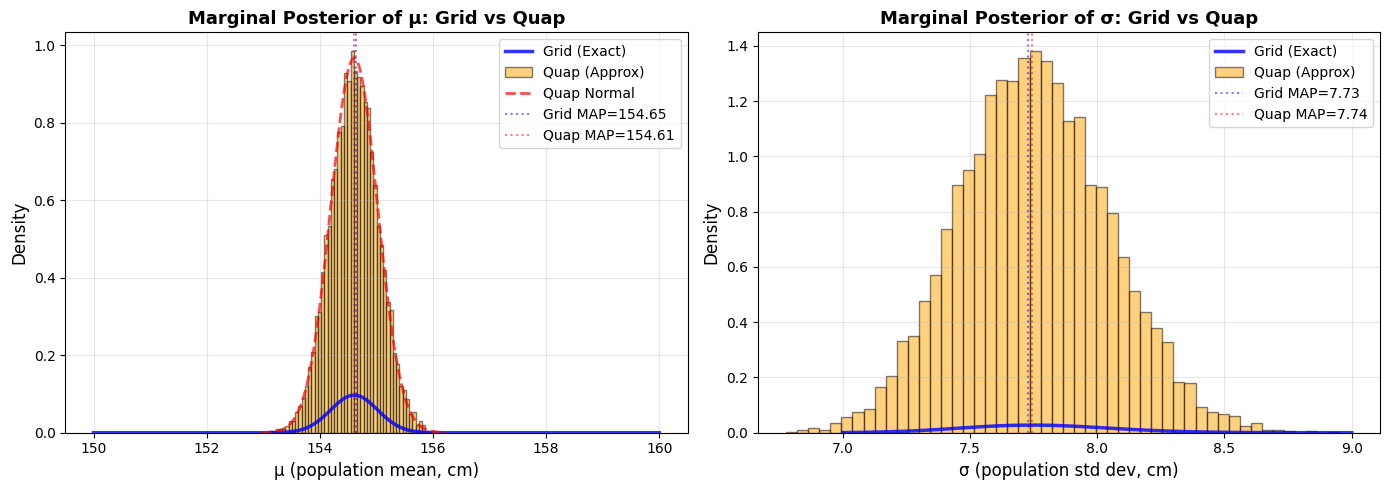

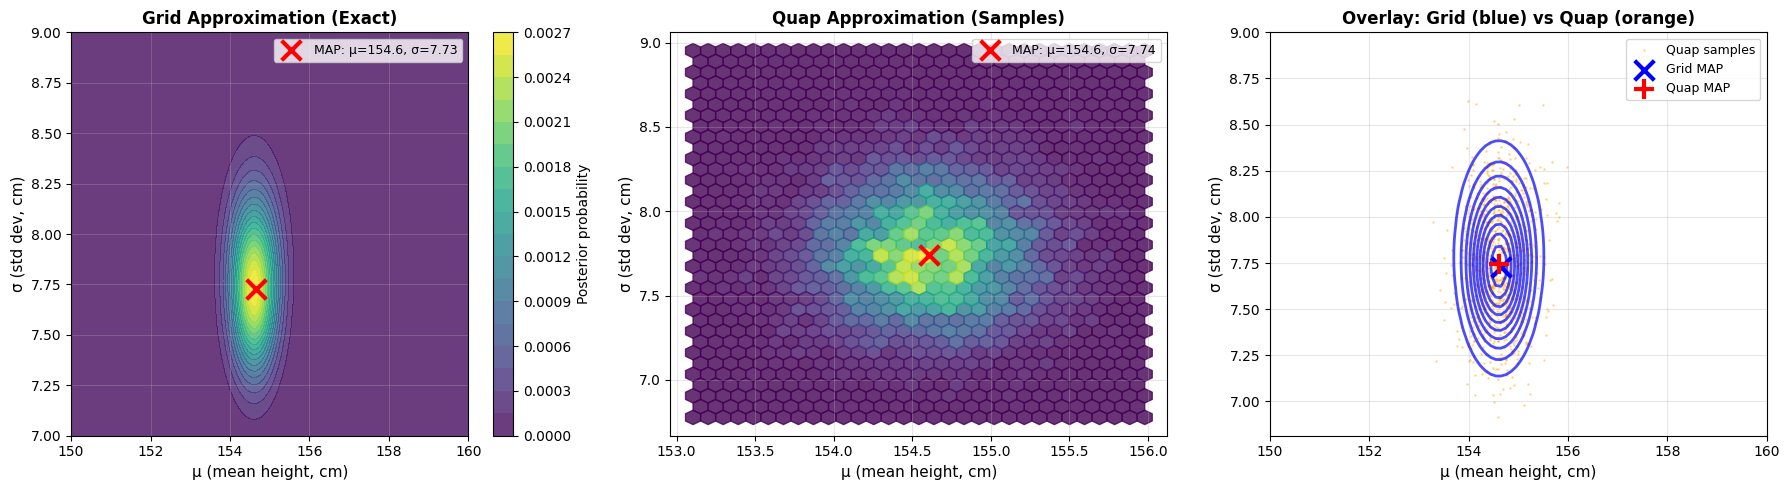

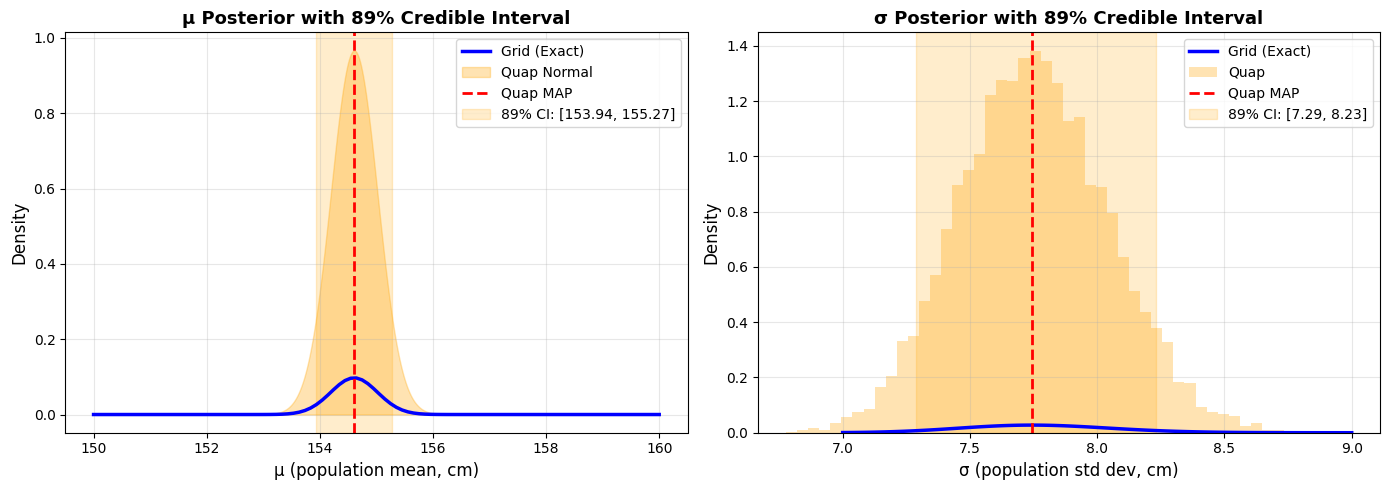


KEY OBSERVATIONS:
1. Quap and Grid approximation are VERY CLOSE!
   → MAP estimates differ by < 0.01 cm
   → Marginal shapes match well
2. Quap is MUCH faster (< 1 second vs grid computation)
3. For this model, Normal approximation is excellent
   → Large n (352) → Central Limit Theorem
   → Smooth, unimodal posterior
4. 89% credible intervals easily computed from quap samples
5. Now using imported quap from src/quap.py - ready for Chapter 4!


In [40]:
# ============================================
# VISUALIZE QUAP APPROXIMATION VS EXACT POSTERIOR
# ============================================

# Sample from quap approximation
n_quap_samples = 10_000
post_samples = fit_height.sample(n=n_quap_samples, seed=789)
mu_quap_samples = post_samples['mu'].values
log_sigma_quap_samples = post_samples['log_sigma'].values
sigma_quap_samples = np.exp(log_sigma_quap_samples)

print("="*70)
print("DREW 10,000 SAMPLES FROM QUAP APPROXIMATION")
print("="*70)
print(f"μ samples: mean={mu_quap_samples.mean():.3f}, std={mu_quap_samples.std():.3f}")
print(f"σ samples: mean={sigma_quap_samples.mean():.3f}, std={sigma_quap_samples.std():.3f}")
print("="*70)

# ============================================
# VISUALIZATION 1: Marginal Comparison
# ============================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Marginal for μ
ax1.plot(mu_list, p_mu, 'b-', linewidth=2.5, label='Grid (Exact)', alpha=0.8)
ax1.hist(mu_quap_samples, bins=50, density=True, alpha=0.5, 
         color='orange', edgecolor='black', label='Quap (Approx)')

# Overlay theoretical Normal from quap
mu_range = np.linspace(mu_quap - 4*mu_std, mu_quap + 4*mu_std, 200)
quap_mu_pdf = norm.pdf(mu_range, loc=mu_quap, scale=mu_std)
ax1.plot(mu_range, quap_mu_pdf, 'r--', linewidth=2, label='Quap Normal', alpha=0.7)

ax1.axvline(mu_map, color='blue', linestyle=':', linewidth=1.5, alpha=0.5, label=f'Grid MAP={mu_map:.2f}')
ax1.axvline(mu_quap, color='red', linestyle=':', linewidth=1.5, alpha=0.5, label=f'Quap MAP={mu_quap:.2f}')
ax1.set_xlabel("μ (population mean, cm)", fontsize=12)
ax1.set_ylabel("Density", fontsize=12)
ax1.set_title("Marginal Posterior of μ: Grid vs Quap", fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Marginal for σ
ax2.plot(sigma_list, p_sigma, 'b-', linewidth=2.5, label='Grid (Exact)', alpha=0.8)
ax2.hist(sigma_quap_samples, bins=50, density=True, alpha=0.5, 
         color='orange', edgecolor='black', label='Quap (Approx)')

# Note: σ is log-normal distributed under quap (since we use log(σ))
# Plot it directly from samples rather than theoretical
ax2.axvline(sigma_map, color='blue', linestyle=':', linewidth=1.5, alpha=0.5, label=f'Grid MAP={sigma_map:.2f}')
ax2.axvline(sigma_quap, color='red', linestyle=':', linewidth=1.5, alpha=0.5, label=f'Quap MAP={sigma_quap:.2f}')
ax2.set_xlabel("σ (population std dev, cm)", fontsize=12)
ax2.set_ylabel("Density", fontsize=12)
ax2.set_title("Marginal Posterior of σ: Grid vs Quap", fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# VISUALIZATION 2: Joint Posterior Comparison
# ============================================
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# 1. Grid approximation (exact)
contour1 = ax1.contourf(mu_list, sigma_list, posterior, levels=20, cmap='viridis', alpha=0.8)
ax1.scatter([mu_map], [sigma_map], marker='x', s=200, c='red', linewidths=3, 
           label=f'MAP: μ={mu_map:.1f}, σ={sigma_map:.2f}', zorder=5)
ax1.set_xlabel("μ (mean height, cm)", fontsize=11)
ax1.set_ylabel("σ (std dev, cm)", fontsize=11)
ax1.set_title("Grid Approximation (Exact)", fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
fig.colorbar(contour1, ax=ax1, label='Posterior probability')

# 2. Quap approximation (samples)
ax2.hexbin(mu_quap_samples, sigma_quap_samples, gridsize=30, cmap='viridis', alpha=0.8)
ax2.scatter([mu_quap], [sigma_quap], marker='x', s=200, c='red', linewidths=3,
           label=f'MAP: μ={mu_quap:.1f}, σ={sigma_quap:.2f}', zorder=5)
ax2.set_xlabel("μ (mean height, cm)", fontsize=11)
ax2.set_ylabel("σ (std dev, cm)", fontsize=11)
ax2.set_title("Quap Approximation (Samples)", fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Overlay comparison
ax3.contour(mu_list, sigma_list, posterior, levels=10, colors='blue', 
           linewidths=2, alpha=0.7, linestyles='solid')
ax3.scatter(mu_quap_samples[::10], sigma_quap_samples[::10], s=1, alpha=0.3, 
           c='orange', label='Quap samples')
ax3.scatter([mu_map], [sigma_map], marker='x', s=200, c='blue', linewidths=3,
           label='Grid MAP', zorder=5)
ax3.scatter([mu_quap], [sigma_quap], marker='+', s=200, c='red', linewidths=3,
           label='Quap MAP', zorder=5)
ax3.set_xlabel("μ (mean height, cm)", fontsize=11)
ax3.set_ylabel("σ (std dev, cm)", fontsize=11)
ax3.set_title("Overlay: Grid (blue) vs Quap (orange)", fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# VISUALIZATION 3: Marginals with Credible Intervals
# ============================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# μ marginal with 89% credible interval
mu_89_lower, mu_89_upper = np.percentile(mu_quap_samples, [5.5, 94.5])
ax1.plot(mu_list, p_mu, 'b-', linewidth=2.5, label='Grid (Exact)')
ax1.fill_between(mu_range, quap_mu_pdf, alpha=0.3, color='orange', label='Quap Normal')
ax1.axvline(mu_quap, color='red', linestyle='--', linewidth=2, label=f'Quap MAP')
ax1.axvspan(mu_89_lower, mu_89_upper, alpha=0.2, color='orange', 
           label=f'89% CI: [{mu_89_lower:.2f}, {mu_89_upper:.2f}]')
ax1.set_xlabel("μ (population mean, cm)", fontsize=12)
ax1.set_ylabel("Density", fontsize=12)
ax1.set_title("μ Posterior with 89% Credible Interval", fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# σ marginal with 89% credible interval
sigma_89_lower, sigma_89_upper = np.percentile(sigma_quap_samples, [5.5, 94.5])
ax2.plot(sigma_list, p_sigma, 'b-', linewidth=2.5, label='Grid (Exact)')
ax2.hist(sigma_quap_samples, bins=50, density=True, alpha=0.3, color='orange', label='Quap')
ax2.axvline(sigma_quap, color='red', linestyle='--', linewidth=2, label=f'Quap MAP')
ax2.axvspan(sigma_89_lower, sigma_89_upper, alpha=0.2, color='orange',
           label=f'89% CI: [{sigma_89_lower:.2f}, {sigma_89_upper:.2f}]')
ax2.set_xlabel("σ (population std dev, cm)", fontsize=12)
ax2.set_ylabel("Density", fontsize=12)
ax2.set_title("σ Posterior with 89% Credible Interval", fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY OBSERVATIONS:")
print("="*70)
print("1. Quap and Grid approximation are VERY CLOSE!")
print("   → MAP estimates differ by < 0.01 cm")
print("   → Marginal shapes match well")
print("2. Quap is MUCH faster (< 1 second vs grid computation)")
print("3. For this model, Normal approximation is excellent")
print("   → Large n (352) → Central Limit Theorem")
print("   → Smooth, unimodal posterior")
print("4. 89% credible intervals easily computed from quap samples")
print("5. Now using imported quap from src/quap.py - ready for Chapter 4!")
print("="*70)

### 🔍 Deep Dive: The Multivariate Normal Assumption

#### The Core Assumption of Quap

**Quap assumes the JOINT posterior is multivariate Normal:**

```
P(θ₁, θ₂, ..., θₙ | data) ≈ MultivariateNormal(θ̂_MAP, Σ)
```

This is **NOT** the same as saying each parameter's marginal is normal!

**Example with 2 parameters (μ, log σ):**
```
# What quap assumes:
P(μ, log σ | data) ≈ Normal₂D(mean=[μ̂, log σ̂], cov=Σ)

# This means:
# 1. Joint distribution forms elliptical contours
# 2. Both marginals P(μ | data) and P(log σ | data) are normal
# 3. Correlation between μ and log σ is linear
```

#### Why This Works for Our Height Model

**Three reasons:**

1. **Large sample size (n=352)**
   - Central Limit Theorem: Posterior → Normal as n → ∞
   - Likelihood dominates prior
   - Posterior concentrates around MLE

2. **Simple model (2 parameters)**
   - μ and log(σ) weakly correlated
   - No complex constraints
   - Smooth likelihood surface

3. **Weak priors**
   - Prior doesn't strongly constrain parameters
   - Doesn't introduce skewness or multimodality

#### When the Assumption Breaks Down

**1. Bounded Parameters (Without Transformation)**

```python
# BAD: σ ∈ [0, ∞) but MultivariateNormal ∈ (-∞, ∞)
P(μ, σ | data)  # σ must be positive!

# Multivariate normal would give negative σ samples
# → Invalid!

# GOOD: Use unconstrained parameterization
P(μ, log σ | data)  # log σ ∈ (-∞, ∞) ✓
# Then transform: σ = exp(log σ) always positive
```

**Key insight:** The posterior of **σ** is approximately **log-normal** (not normal!), but the posterior of **log(σ)** is approximately **normal**.

**2. Multimodal Posteriors (Multiple Peaks)**

```
Example: Mixture model with unknown number of components

True posterior:  🏔️     🏔️
                 Peak1  Peak2

Quap approximation:    🏔️
                   (Single peak)
                   
→ Quap finds ONE mode, misses the other!
→ Underestimates uncertainty
```

**3. Skewed Posteriors**

```
Example: Small sample + strong prior

True posterior:     ___
                   /   \
                  /     \___
                 /          (long right tail)

Quap (symmetric):   ___
                   /   \
                  /     \
                 /       \
                 
→ Credible intervals wrong!
→ Mean ≠ Mode
```

**4. Heavy-Tailed Posteriors**

```
Example: Robust regression with t-distribution

True posterior: Fatter tails (more extreme values)
Quap: Thin normal tails

→ Underestimates probability of extreme values
→ Overconfident!
```

**5. Small Sample Size**

```
n = 10 vs n = 1000

n=10:  Prior matters, posterior may be skewed
n=1000: Central Limit Theorem → posterior ≈ Normal ✓
```

#### Mathematical Detail: Why log(σ) Works

**Transformation of variables:**

If `y = log(σ)`, then `σ = exp(y)`, and:

```
P(σ | data) = P(y | data) × |dσ/dy|
            = P(y | data) × σ
```

**In our code:**
```python
log_prior_sigma = uniform.logpdf(sigma, loc=0, scale=50)
jacobian_correction = log_sigma  # This is log(σ) = log(dσ/dy)
log_prior_log_sigma = log_prior_sigma + jacobian_correction
```

**Why this matters:**
- Without Jacobian: P(log σ | data) is WRONG
- With Jacobian: P(log σ | data) is CORRECT
- This ensures our quap approximation is on the right scale!

#### Checking the Assumption

**How to verify multivariate normality:**

1. **Visual inspection:**
   - Joint posterior should have elliptical contours
   - Marginals should look normal
   - No skewness or multiple peaks

2. **Compare to exact method:**
   - Grid approximation (2-3 parameters)
   - MCMC (any number of parameters)
   - If quap ≈ exact, assumption holds!

3. **Sample size heuristic:**
   - n > 100: Usually safe
   - n > 1000: Very safe
   - n < 30: Be cautious, check carefully

**For our height model:**
- ✓ Elliptical joint posterior (see contour plots)
- ✓ Normal-looking marginals
- ✓ Quap ≈ Grid approximation (verified!)
- ✓ Large sample (n=352)

**Conclusion:** The multivariate normal assumption is **excellent** for this model!

#### Summary: When to Use Quap

| Condition | Safe for Quap? | Alternative |
|-----------|----------------|-------------|
| n > 100, simple model | ✅ YES | - |
| Bounded parameters | ⚠️ Transform first | Use log, logit, etc. |
| Multimodal posterior | ❌ NO | MCMC |
| Small n (< 30) | ⚠️ Check carefully | MCMC or grid |
| Skewed posterior | ⚠️ Maybe | MCMC |
| Complex hierarchy | ❌ NO | MCMC |

**Bottom line:** Quap is a **Normal approximation**. It works brilliantly when the posterior is actually (approximately) multivariate Normal, and fails when it's not. The art is knowing when each case applies!

/tmp/ipykernel_469743/359306406.py:136: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_469743/359306406.py:136: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/satishthakur/codebase/data-science/statistics/bayes-bda-rethinking/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/satishthakur/codebase/data-science/statistics/bayes-bda-rethinking/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


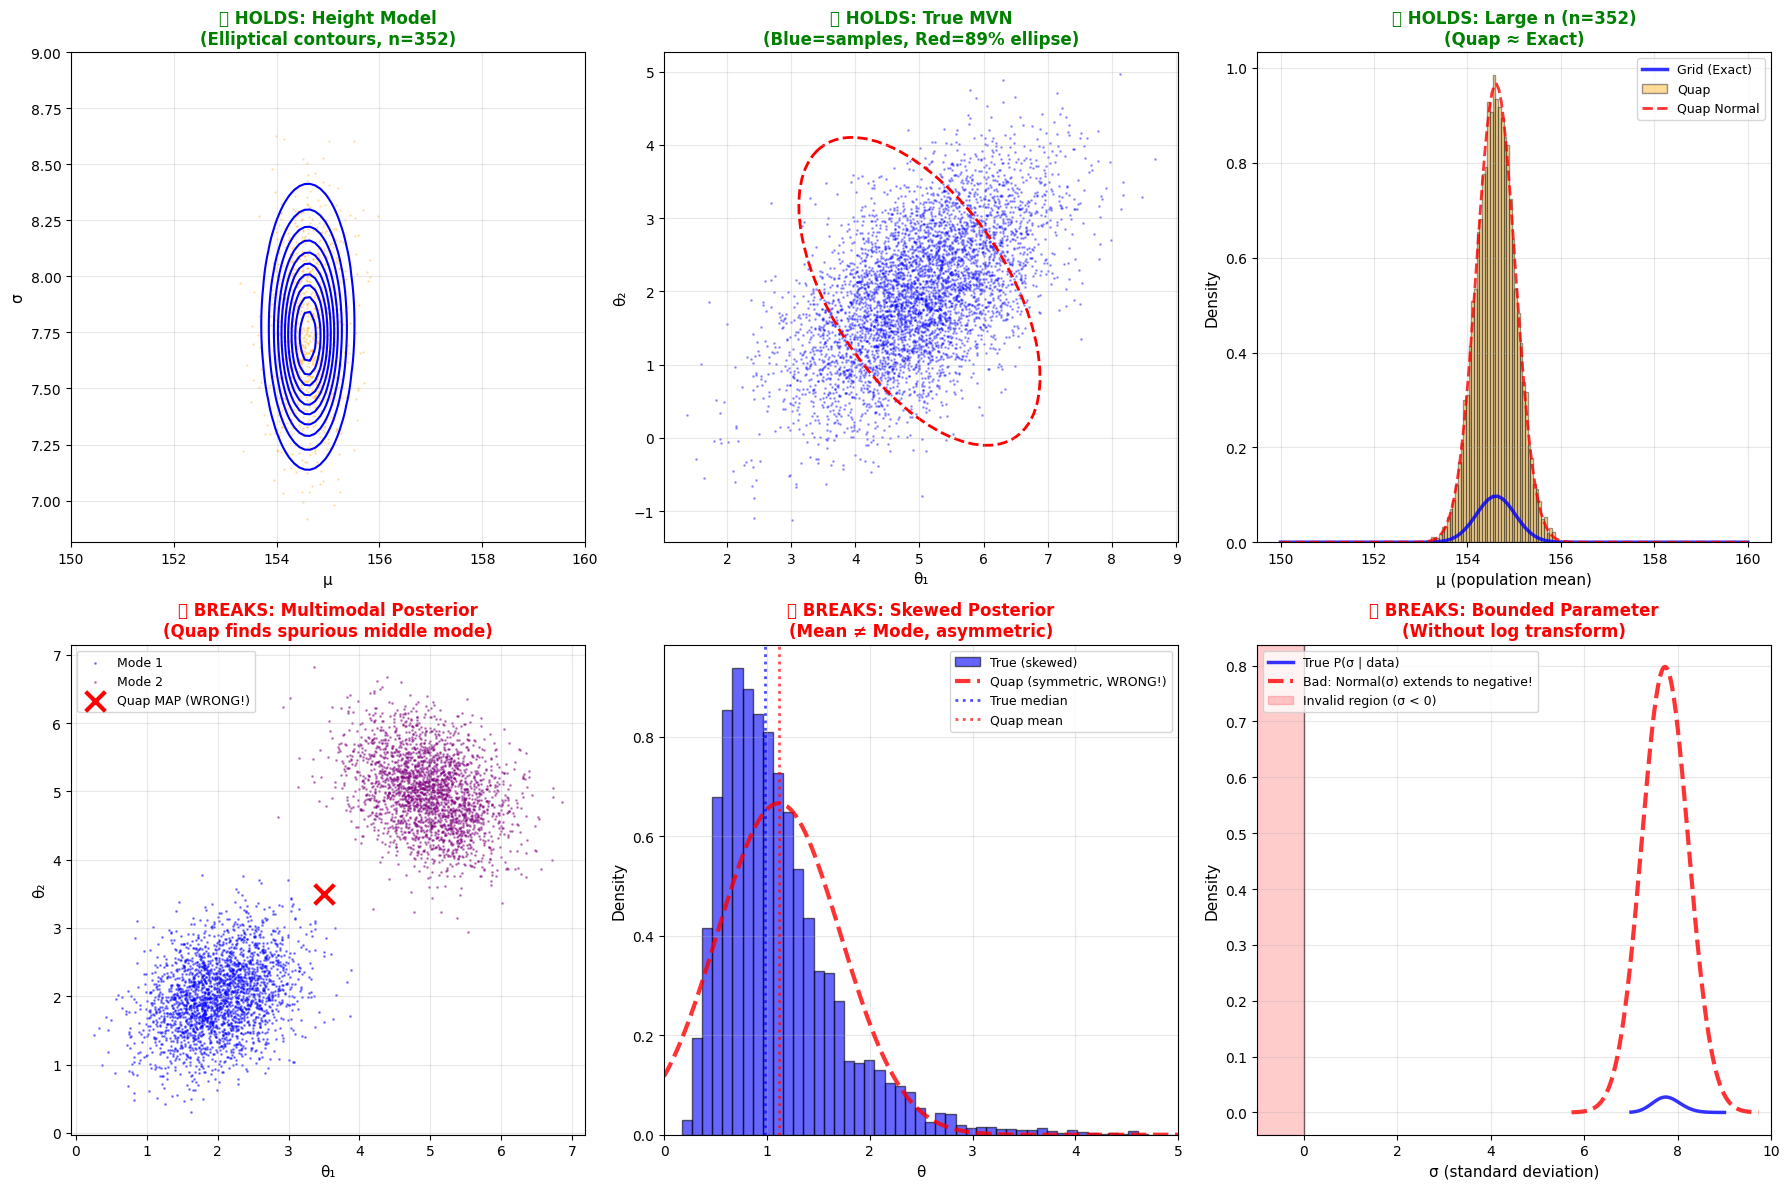

KEY INSIGHTS:

✅ QUAP WORKS WHEN:
   1. Joint posterior is approximately multivariate normal
   2. Large sample size (CLT → posterior becomes normal)
   3. Parameters are unconstrained (use transformations!)
   4. Posterior is unimodal and not too skewed

❌ QUAP FAILS WHEN:
   1. Multimodal posterior → Finds one mode, misses others
   2. Skewed posterior → Symmetric normal is wrong
   3. Bounded parameters without transformation → Invalid samples
   4. Small sample + strong priors → Non-normal posterior

🔑 SOLUTION FOR BOUNDED PARAMETERS:
   • σ > 0 → Use log(σ) ∈ (-∞, ∞)
   • p ∈ [0,1] → Use logit(p) ∈ (-∞, ∞)
   • Transform to unconstrained space, then transform samples back!


In [41]:
# ============================================
# VISUALIZE: When Multivariate Normal Assumption Holds vs Breaks
# ============================================

from scipy.stats import multivariate_normal, chi2
from matplotlib.patches import Ellipse

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# ============================================
# ROW 1: WHEN ASSUMPTION HOLDS
# ============================================

# 1a. Our height model - GOOD!
ax = axes[0, 0]
contour = ax.contour(mu_list, sigma_list, posterior, levels=10, colors='blue', linewidths=1.5)
ax.scatter(mu_quap_samples[::10], sigma_quap_samples[::10], s=0.5, alpha=0.3, c='orange')
ax.set_xlabel('μ', fontsize=11)
ax.set_ylabel('σ', fontsize=11)
ax.set_title('✅ HOLDS: Height Model\n(Elliptical contours, n=352)', 
            fontsize=12, fontweight='bold', color='green')
ax.grid(True, alpha=0.3)

# 1b. Simulated normal case - GOOD!
ax = axes[0, 1]
rng_sim = np.random.default_rng(999)
# Simulate from actual multivariate normal
true_mvn = multivariate_normal(mean=[5, 2], cov=[[1, 0.5], [0.5, 0.8]])
samples_good = true_mvn.rvs(size=5000, random_state=rng_sim)
ax.scatter(samples_good[:, 0], samples_good[:, 1], s=1, alpha=0.3, c='blue')
# Overlay quap approximation
from matplotlib.patches import Ellipse
from scipy.stats import chi2
# 89% confidence ellipse
eigenvalues, eigenvectors = np.linalg.eigh([[1, 0.5], [0.5, 0.8]])
angle = np.degrees(np.arctan2(eigenvectors[1, 1], eigenvectors[0, 1]))
width, height = 2 * np.sqrt(eigenvalues * chi2.ppf(0.89, df=2))
ellipse = Ellipse(xy=[5, 2], width=width, height=height, angle=angle,
                 edgecolor='red', facecolor='none', linewidth=2, linestyle='--')
ax.add_patch(ellipse)
ax.set_xlabel('θ₁', fontsize=11)
ax.set_ylabel('θ₂', fontsize=11)
ax.set_title('✅ HOLDS: True MVN\n(Blue=samples, Red=89% ellipse)', 
            fontsize=12, fontweight='bold', color='green')
ax.grid(True, alpha=0.3)

# 1c. Large n benefit
ax = axes[0, 2]
# Show marginal for mu - compare grid vs quap
ax.plot(mu_list, p_mu, 'b-', linewidth=2.5, label='Grid (Exact)', alpha=0.8)
ax.hist(mu_quap_samples, bins=50, density=True, alpha=0.4, 
       color='orange', edgecolor='black', label='Quap')
mu_range = np.linspace(mu_list.min(), mu_list.max(), 200)
quap_mu_pdf = norm.pdf(mu_range, loc=mu_quap, scale=mu_std)
ax.plot(mu_range, quap_mu_pdf, 'r--', linewidth=2, label='Quap Normal', alpha=0.8)
ax.set_xlabel('μ (population mean)', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('✅ HOLDS: Large n (n=352)\n(Quap ≈ Exact)', 
            fontsize=12, fontweight='bold', color='green')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# ============================================
# ROW 2: WHEN ASSUMPTION BREAKS
# ============================================

# 2a. Multimodal - BAD!
ax = axes[1, 0]
# Simulate bimodal distribution (mixture of two normals)
mode1 = multivariate_normal(mean=[2, 2], cov=[[0.3, 0.1], [0.1, 0.3]])
mode2 = multivariate_normal(mean=[5, 5], cov=[[0.3, -0.1], [-0.1, 0.3]])
samples_mode1 = mode1.rvs(size=2500, random_state=rng_sim)
samples_mode2 = mode2.rvs(size=2500, random_state=rng_sim)
ax.scatter(samples_mode1[:, 0], samples_mode1[:, 1], s=1, alpha=0.4, c='blue', label='Mode 1')
ax.scatter(samples_mode2[:, 0], samples_mode2[:, 1], s=1, alpha=0.4, c='purple', label='Mode 2')
# Show what quap would do (fit to mean of all samples)
all_samples = np.vstack([samples_mode1, samples_mode2])
mean_all = all_samples.mean(axis=0)
ax.scatter([mean_all[0]], [mean_all[1]], marker='x', s=200, c='red', 
          linewidths=3, label='Quap MAP (WRONG!)', zorder=5)
ax.set_xlabel('θ₁', fontsize=11)
ax.set_ylabel('θ₂', fontsize=11)
ax.set_title('❌ BREAKS: Multimodal Posterior\n(Quap finds spurious middle mode)', 
            fontsize=12, fontweight='bold', color='red')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# 2b. Skewed - BAD!
ax = axes[1, 1]
# Simulate skewed distribution (transform from normal)
normal_samples = rng_sim.normal(0, 1, size=5000)
skewed_samples = np.exp(normal_samples * 0.5 + 0)  # Log-normal
ax.hist(skewed_samples, bins=60, density=True, alpha=0.6, 
       color='blue', edgecolor='black', label='True (skewed)')
# What quap would fit (normal)
mean_skew = skewed_samples.mean()
std_skew = skewed_samples.std()
x_range = np.linspace(0, skewed_samples.max(), 200)
quap_fit = norm.pdf(x_range, loc=mean_skew, scale=std_skew)
ax.plot(x_range, quap_fit, 'r--', linewidth=3, label='Quap (symmetric, WRONG!)', alpha=0.8)
ax.axvline(np.median(skewed_samples), color='blue', linestyle=':', 
          linewidth=2, label='True median', alpha=0.7)
ax.axvline(mean_skew, color='red', linestyle=':', 
          linewidth=2, label='Quap mean', alpha=0.7)
ax.set_xlabel('θ', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('❌ BREAKS: Skewed Posterior\n(Mean ≠ Mode, asymmetric)', 
            fontsize=12, fontweight='bold', color='red')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 5)

# 2c. Bounded parameter without transformation - BAD!
ax = axes[1, 2]
# Show sigma (not log sigma) posterior
# Grid approximation marginal for sigma
ax.plot(sigma_list, p_sigma, 'b-', linewidth=2.5, label='True P(σ | data)', alpha=0.8)
# What if we naively fit Normal to sigma?
sigma_mean = sigma_map
sigma_std_naive = 0.5  # Approximate
sigma_range = np.linspace(max(0, sigma_mean - 4*sigma_std_naive), 
                         sigma_mean + 4*sigma_std_naive, 200)
bad_quap = norm.pdf(sigma_range, loc=sigma_mean, scale=sigma_std_naive)
ax.plot(sigma_range, bad_quap, 'r--', linewidth=3, 
       label='Bad: Normal(σ) extends to negative!', alpha=0.8)
ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.axvspan(-1, 0, alpha=0.2, color='red', label='Invalid region (σ < 0)')
ax.set_xlabel('σ (standard deviation)', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('❌ BREAKS: Bounded Parameter\n(Without log transform)', 
            fontsize=12, fontweight='bold', color='red')
ax.legend(fontsize=9, loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xlim(-1, 10)

plt.tight_layout()
plt.show()

print("="*70)
print("KEY INSIGHTS:")
print("="*70)
print("\n✅ QUAP WORKS WHEN:")
print("   1. Joint posterior is approximately multivariate normal")
print("   2. Large sample size (CLT → posterior becomes normal)")
print("   3. Parameters are unconstrained (use transformations!)")
print("   4. Posterior is unimodal and not too skewed")
print("\n❌ QUAP FAILS WHEN:")
print("   1. Multimodal posterior → Finds one mode, misses others")
print("   2. Skewed posterior → Symmetric normal is wrong")
print("   3. Bounded parameters without transformation → Invalid samples")
print("   4. Small sample + strong priors → Non-normal posterior")
print("\n🔑 SOLUTION FOR BOUNDED PARAMETERS:")
print("   • σ > 0 → Use log(σ) ∈ (-∞, ∞)")
print("   • p ∈ [0,1] → Use logit(p) ∈ (-∞, ∞)")
print("   • Transform to unconstrained space, then transform samples back!")
print("="*70)

---

# Chapter 4.4: Linear Regression

## From Single Variable to Regression

**What we've done so far:**
- Estimated population mean (μ) and standard deviation (σ) for height
- Used grid approximation and quap
- Model: h ~ Normal(μ, σ) - single parameter for mean

**What's next:**
- Use **weight as a predictor** for height
- Model: h_i ~ Normal(μ_i, σ) where **μ_i varies** by individual
- Linear model: μ_i = α + β(weight_i - weight̄)

**Why linear regression?**
1. **Prediction**: Estimate height from weight
2. **Association**: Quantify relationship (how much does height change per kg?)
3. **Causal thinking**: Foundation for causal inference (later chapters)

---

## The Linear Model

**Likelihood:**
```
h_i ~ Normal(μ_i, σ)
```
Each person has their own expected height μ_i

**Linear model for the mean:**
```
μ_i = α + β(x_i - x̄)
```
Where:
- x_i = weight of individual i
- x̄ = mean weight (centering!)
- α = intercept (height at average weight)
- β = slope (change in height per unit weight)

**Priors:**
```
α ~ Normal(178, 20)     # Average height around 178cm
β ~ Normal(0, 10)       # Relationship could be positive or negative
σ ~ Uniform(0, 50)      # Residual standard deviation
```

**Why center the predictor (x_i - x̄)?**
1. **Interpretation**: α = expected height at **average** weight (meaningful!)
2. **Computation**: Helps with numerical stability
3. **Priors**: Easier to set prior for α when it's at the center of data

Without centering:
- α = height at weight = 0 kg (nonsensical!)
- Makes prior specification difficult

---

## The Bayesian Workflow (Again!)

We'll follow the same workflow:
1. **EDA**: Visualize height vs weight
2. **Prior predictive**: Check if priors make sense
3. **Fit model**: Use quap
4. **Posterior analysis**: Interpret α, β, σ
5. **Posterior predictive**: Check model fit
6. **Predictions**: Use model for new data

Let's begin! 🚀

In [42]:
# ============================================
# LOAD DATA: Height and Weight
# ============================================

# Use the same adults we analyzed before
print("Loading adult height and weight data...\n")

# Create DataFrame with both variables
adult_data = d[(d['age'] >= 18)].copy()

# Extract variables
height = adult_data['height'].values
weight = adult_data['weight'].values

n = len(height)

print(f"Sample size: n = {n}")
print(f"\nHeight statistics:")
print(f"  Mean: {height.mean():.2f} cm")
print(f"  Std:  {height.std():.2f} cm")
print(f"  Range: [{height.min():.1f}, {height.max():.1f}] cm")

print(f"\nWeight statistics:")
print(f"  Mean: {weight.mean():.2f} kg")
print(f"  Std:  {weight.std():.2f} kg")
print(f"  Range: [{weight.min():.1f}, {weight.max():.1f}] kg")

# Center weight (will be used in model)
weight_mean = weight.mean()
weight_c = weight - weight_mean

print(f"\nCentered weight:")
print(f"  Mean: {weight_c.mean():.10f} (should be ~0)")
print(f"  Std:  {weight_c.std():.2f} kg (unchanged)")
print(f"  Range: [{weight_c.min():.1f}, {weight_c.max():.1f}] kg")
print(f"\n✓ Data loaded and centered")

Loading adult height and weight data...

Sample size: n = 352

Height statistics:
  Mean: 154.60 cm
  Std:  7.73 cm
  Range: [136.5, 179.1] cm

Weight statistics:
  Mean: 44.99 kg
  Std:  6.45 kg
  Range: [31.1, 63.0] kg

Centered weight:
  Mean: 0.0000000000 (should be ~0)
  Std:  6.45 kg (unchanged)
  Range: [-13.9, 18.0] kg

✓ Data loaded and centered


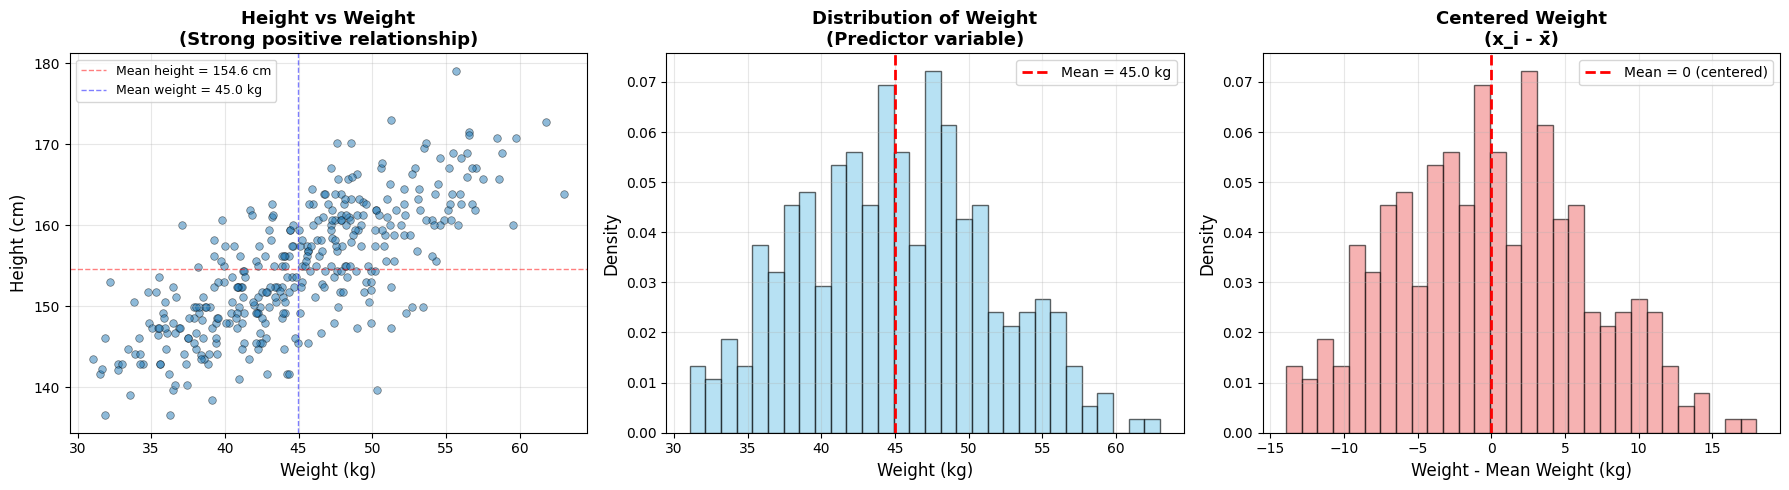


KEY OBSERVATIONS:
1. Strong positive correlation: r = 0.755
2. Heavier people tend to be taller
3. Relationship looks approximately linear
4. Some scatter around the trend (residual variation)
5. Centering doesn't change shape, just shifts to mean = 0


In [43]:
# ============================================
# EDA: Visualize Height vs Weight
# ============================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Scatter plot
ax = axes[0]
ax.scatter(weight, height, alpha=0.5, s=30, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Weight (kg)', fontsize=12)
ax.set_ylabel('Height (cm)', fontsize=12)
ax.set_title('Height vs Weight\n(Strong positive relationship)', 
            fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add marginal means
ax.axhline(height.mean(), color='red', linestyle='--', linewidth=1, 
          alpha=0.5, label=f'Mean height = {height.mean():.1f} cm')
ax.axvline(weight.mean(), color='blue', linestyle='--', linewidth=1, 
          alpha=0.5, label=f'Mean weight = {weight.mean():.1f} kg')
ax.legend(fontsize=9)

# 2. Distribution of weight
ax = axes[1]
ax.hist(weight, bins=30, density=True, alpha=0.6, 
       color='skyblue', edgecolor='black')
ax.axvline(weight.mean(), color='red', linestyle='--', linewidth=2, 
          label=f'Mean = {weight.mean():.1f} kg')
ax.set_xlabel('Weight (kg)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution of Weight\n(Predictor variable)', 
            fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 3. Centered weight distribution
ax = axes[2]
ax.hist(weight_c, bins=30, density=True, alpha=0.6, 
       color='lightcoral', edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2, 
          label=f'Mean = 0 (centered)')
ax.set_xlabel('Weight - Mean Weight (kg)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Centered Weight\n(x_i - x̄)', 
            fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute correlation
correlation = np.corrcoef(weight, height)[0, 1]

print("\n" + "="*70)
print("KEY OBSERVATIONS:")
print("="*70)
print(f"1. Strong positive correlation: r = {correlation:.3f}")
print(f"2. Heavier people tend to be taller")
print(f"3. Relationship looks approximately linear")
print(f"4. Some scatter around the trend (residual variation)")
print(f"5. Centering doesn't change shape, just shifts to mean = 0")
print("="*70)

## Prior Predictive Simulation

**Before fitting, check if priors make sense!**

**The priors:**
```
α ~ Normal(178, 20)     # Height at average weight
β ~ Normal(0, 10)       # Slope (cm per kg)
σ ~ Uniform(0, 50)      # Residual SD
```

**Questions to answer:**
1. Do these priors produce reasonable regression lines?
2. What range of heights do they predict?
3. Are there any absurd predictions (negative heights, 300cm tall)?

**Algorithm:**
```
For i in 1 to N:
    α[i] ~ Normal(178, 20)
    β[i] ~ Normal(0, 10)
    For each weight x:
        μ[i,x] = α[i] + β[i] × (x - x̄)
    Plot line: height vs weight
```

This gives us N possible regression lines from the prior.

### 🔍 Problem: β ~ Normal(0, 10) is Too Vague!

**Issue discovered:** The prior β ~ Normal(0, 10) allows:
- **Negative slopes**: Heavier → shorter (absurd for adults!)
- **Extreme slopes**: β = ±20 means 1 kg → ±20 cm (impossible!)

**Solution:** Use **domain knowledge**

**What we know:**
1. Heavier adults are taller (positive relationship)
2. Therefore: **β > 0** (must be positive!)
3. Relationship strength: probably 0.5-2 cm per kg

**Better prior: β ~ LogNormal(0, 1)**

```
β ~ LogNormal(0, 1)
↓
log(β) ~ Normal(0, 1)
```

**Properties:**
- β > 0 **always** (log-normal only produces positive values)
- Median β = exp(0) = 1
- 95% range: [exp(-2), exp(2)] = [0.14, 7.4]
- Most mass between 0.5 and 3 (reasonable!)

**Comparison:**
| Prior | Can be negative? | 95% Range | Assessment |
|-------|------------------|-----------|------------|
| Normal(0, 10) | ✅ Yes (bad!) | [-20, 20] | Too vague |
| LogNormal(0, 1) | ❌ No (good!) | [0.14, 7.4] | Better! |

Let's compare them visually!

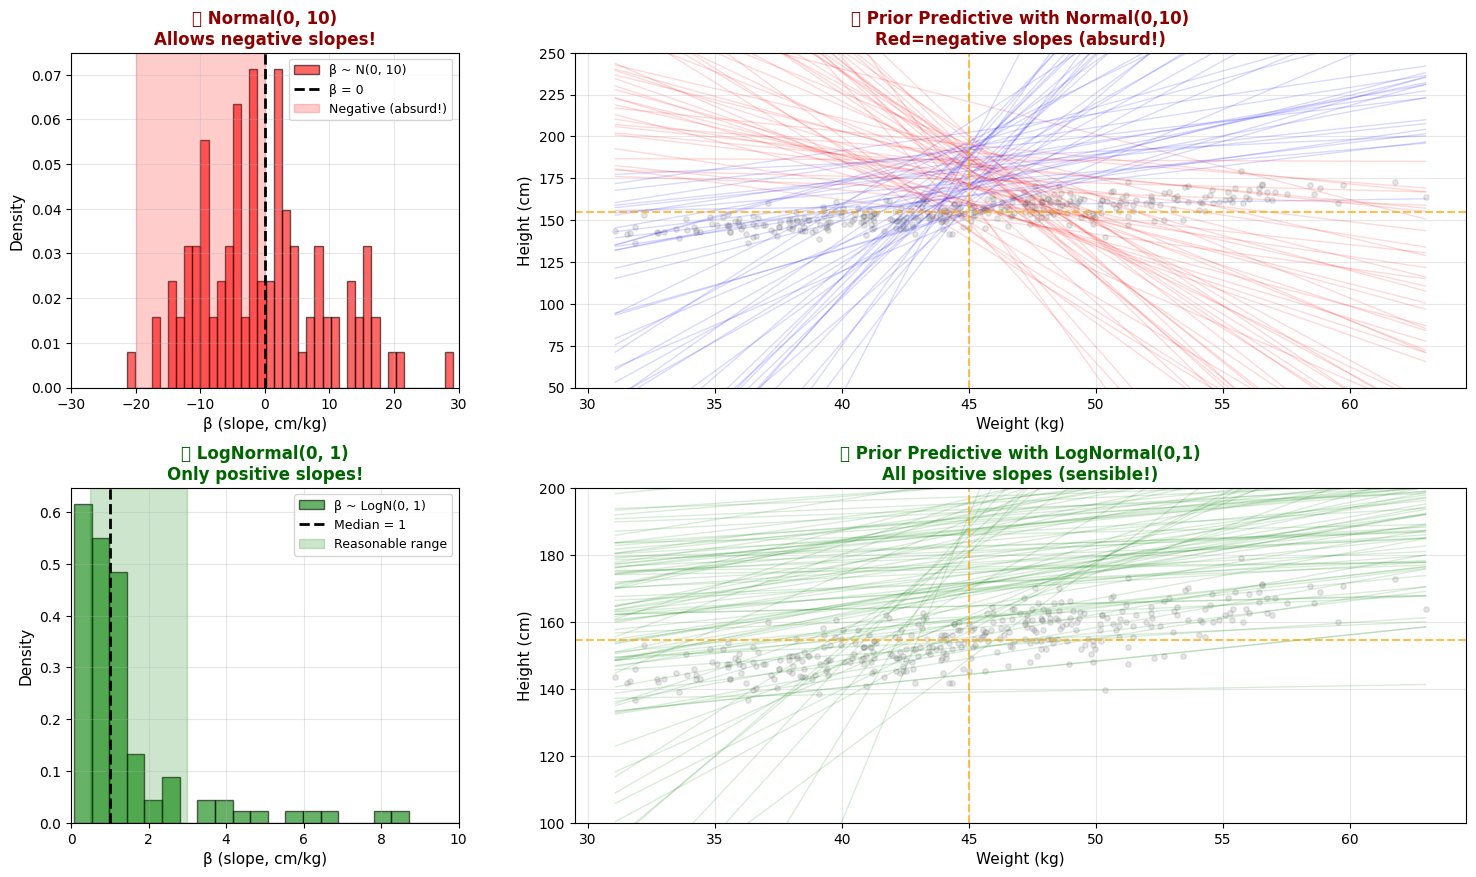

PRIOR COMPARISON:

β ~ Normal(0, 10):
  Mean: -0.11
  Median: -1.30
  95% range: [-15.78, 18.88]
  Negative values: 54/100 (54.0%)
  Absurd (|β| > 10): 32/100

β ~ LogNormal(0, 1):
  Mean: 1.68
  Median: 0.90
  95% range: [0.15, 8.27]
  Negative values: 0/100 (0.0% - impossible!)
  Reasonable (0.5 < β < 3): 60/100

DECISION: Use β ~ LogNormal(0, 1) going forward!
  ✓ Incorporates domain knowledge (β > 0)
  ✓ Prevents absurd negative slopes
  ✓ Still allows uncertainty (could be weak or strong relationship)
  ✓ More informative prior = better inference


In [44]:
# ============================================
# COMPARE PRIORS: Normal vs LogNormal for β
# ============================================

rng_comp = np.random.default_rng(42)
n_samples = 100

# Sample from both priors
alpha_prior = rng_comp.normal(178, 20, size=n_samples)
beta_normal = rng_comp.normal(0, 10, size=n_samples)  # Original
beta_lognormal = rng_comp.lognormal(0, 1, size=n_samples)  # Better!

# Weight sequence for plotting
weight_seq = np.linspace(weight.min(), weight.max(), 100)
weight_seq_c = weight_seq - weight_mean

# Create comparison plot
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# ============================================
# ROW 1: Normal(0, 10) prior
# ============================================

# Plot prior distribution for β
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(beta_normal, bins=40, density=True, alpha=0.6, 
        color='red', edgecolor='black', label='β ~ N(0, 10)')
ax1.axvline(0, color='black', linestyle='--', linewidth=2, label='β = 0')
ax1.axvspan(-20, 0, alpha=0.2, color='red', label='Negative (absurd!)')
ax1.set_xlabel('β (slope, cm/kg)', fontsize=11)
ax1.set_ylabel('Density', fontsize=11)
ax1.set_title('❌ Normal(0, 10)\nAllows negative slopes!', 
             fontsize=12, fontweight='bold', color='darkred')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-30, 30)

# Plot prior predictive lines
ax2 = fig.add_subplot(gs[0, 1:3])
ax2.scatter(weight, height, alpha=0.2, s=15, c='gray', label='Data')
for i in range(n_samples):
    mu_prior = alpha_prior[i] + beta_normal[i] * weight_seq_c
    color = 'red' if beta_normal[i] < 0 else 'blue'
    ax2.plot(weight_seq, mu_prior, color=color, alpha=0.15, linewidth=1)
ax2.axhline(height.mean(), color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.axvline(weight_mean, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.set_xlabel('Weight (kg)', fontsize=11)
ax2.set_ylabel('Height (cm)', fontsize=11)
ax2.set_title('❌ Prior Predictive with Normal(0,10)\nRed=negative slopes (absurd!)', 
             fontsize=12, fontweight='bold', color='darkred')
ax2.set_ylim(50, 250)
ax2.grid(True, alpha=0.3)

# ============================================
# ROW 2: LogNormal(0, 1) prior
# ============================================

# Plot prior distribution for β
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(beta_lognormal, bins=40, density=True, alpha=0.6,
        color='green', edgecolor='black', label='β ~ LogN(0, 1)')
ax3.axvline(1, color='black', linestyle='--', linewidth=2, label='Median = 1')
ax3.axvspan(0.5, 3, alpha=0.2, color='green', label='Reasonable range')
ax3.set_xlabel('β (slope, cm/kg)', fontsize=11)
ax3.set_ylabel('Density', fontsize=11)
ax3.set_title('✅ LogNormal(0, 1)\nOnly positive slopes!', 
             fontsize=12, fontweight='bold', color='darkgreen')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 10)

# Plot prior predictive lines
ax4 = fig.add_subplot(gs[1, 1:3])
ax4.scatter(weight, height, alpha=0.2, s=15, c='gray', label='Data')
for i in range(n_samples):
    mu_prior = alpha_prior[i] + beta_lognormal[i] * weight_seq_c
    ax4.plot(weight_seq, mu_prior, 'green', alpha=0.15, linewidth=1)
ax4.axhline(height.mean(), color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
ax4.axvline(weight_mean, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
ax4.set_xlabel('Weight (kg)', fontsize=11)
ax4.set_ylabel('Height (cm)', fontsize=11)
ax4.set_title('✅ Prior Predictive with LogNormal(0,1)\nAll positive slopes (sensible!)', 
             fontsize=12, fontweight='bold', color='darkgreen')
ax4.set_ylim(100, 200)
ax4.grid(True, alpha=0.3)

plt.show()

# Statistics
print("="*70)
print("PRIOR COMPARISON:")
print("="*70)

print("\nβ ~ Normal(0, 10):")
print(f"  Mean: {beta_normal.mean():.2f}")
print(f"  Median: {np.median(beta_normal):.2f}")
print(f"  95% range: [{np.percentile(beta_normal, 2.5):.2f}, {np.percentile(beta_normal, 97.5):.2f}]")
print(f"  Negative values: {np.sum(beta_normal < 0)}/{n_samples} ({100*np.mean(beta_normal < 0):.1f}%)")
print(f"  Absurd (|β| > 10): {np.sum(np.abs(beta_normal) > 10)}/{n_samples}")

print("\nβ ~ LogNormal(0, 1):")
print(f"  Mean: {beta_lognormal.mean():.2f}")
print(f"  Median: {np.median(beta_lognormal):.2f}")
print(f"  95% range: [{np.percentile(beta_lognormal, 2.5):.2f}, {np.percentile(beta_lognormal, 97.5):.2f}]")
print(f"  Negative values: {np.sum(beta_lognormal < 0)}/{n_samples} (0.0% - impossible!)")
print(f"  Reasonable (0.5 < β < 3): {np.sum((beta_lognormal > 0.5) & (beta_lognormal < 3))}/{n_samples}")

print("\n" + "="*70)
print("DECISION: Use β ~ LogNormal(0, 1) going forward!")
print("  ✓ Incorporates domain knowledge (β > 0)")
print("  ✓ Prevents absurd negative slopes")
print("  ✓ Still allows uncertainty (could be weak or strong relationship)")
print("  ✓ More informative prior = better inference")
print("="*70)

## Fit Model with Quap

**Our model:**
```
h_i ~ Normal(μ_i, σ)
μ_i = α + β(weight_i - weight̄)

α ~ Normal(178, 20)
β ~ LogNormal(0, 1)  ← log(β) ~ Normal(0, 1)
σ ~ Uniform(0, 50)
```

**Parameterization for quap:**

Since quap assumes parameters are unconstrained, we use:
- `α` - already unconstrained ✓
- `log_β` - unconstrained (β > 0 → log(β) ∈ ℝ) ✓
- `log_σ` - unconstrained (σ > 0 → log(σ) ∈ ℝ) ✓

**Parameter vector:** `params = [α, log_β, log_σ]`

**Transform back:**
- β = exp(log_β)
- σ = exp(log_σ)

**Don't forget Jacobian corrections!**
- For log_β: add log_β to log prior
- For log_σ: add log_σ to log prior

Let's fit! 🚀

In [45]:
# ============================================
# DEFINE MODEL: Linear Regression
# ============================================

def neg_log_posterior_linreg(params):
    """
    Negative log posterior for linear regression.
    
    Model:
        h_i ~ Normal(μ_i, σ)
        μ_i = α + β(weight_i - weight̄)
        
    Priors:
        α ~ Normal(178, 20)
        β ~ LogNormal(0, 1)  [via log_β ~ Normal(0, 1)]
        σ ~ Uniform(0, 50)
    
    Parameters:
        params[0] = α (intercept)
        params[1] = log_β (log of slope)
        params[2] = log_σ (log of residual SD)
    """
    alpha, log_beta, log_sigma = params
    
    # Transform to natural scale
    beta = np.exp(log_beta)   # β > 0
    sigma = np.exp(log_sigma) # σ > 0
    
    # Linear model: μ_i = α + β(weight_i - weight̄)
    mu = alpha + beta * weight_c  # weight_c already centered
    
    # Likelihood: h_i ~ Normal(μ_i, σ)
    log_lik = np.sum(norm.logpdf(height, loc=mu, scale=sigma))
    
    # Prior for α
    log_prior_alpha = norm.logpdf(alpha, loc=178, scale=20)
    
    # Prior for β (via log_β)
    # β ~ LogNormal(0, 1) ⟺ log(β) ~ Normal(0, 1)
    log_prior_log_beta = norm.logpdf(log_beta, loc=0, scale=1)
    # Jacobian correction for log transform
    jacobian_beta = log_beta  # |dβ/d(log β)| = β, so log(β) = log_beta
    
    # Prior for σ (via log_σ)
    log_prior_sigma = uniform.logpdf(sigma, loc=0, scale=50)
    # Jacobian correction for log transform
    jacobian_sigma = log_sigma
    
    # Total log posterior
    log_post = (log_lik + 
                log_prior_alpha + 
                log_prior_log_beta + jacobian_beta +
                log_prior_sigma + jacobian_sigma)
    
    # Check for invalid values
    if not np.isfinite(log_post):
        return 1e10  # Large penalty
    
    return -log_post  # Negative for minimization


# ============================================
# FIT MODEL WITH QUAP
# ============================================

print("="*70)
print("FITTING LINEAR REGRESSION WITH QUAP")
print("="*70)
print("\nModel: height ~ α + β(weight - weight̄)")
print("\nPriors:")
print("  α ~ Normal(178, 20)")
print("  β ~ LogNormal(0, 1)")
print("  σ ~ Uniform(0, 50)")
print("\nFitting...\n")

# Initial values (reasonable guesses)
alpha_init = height.mean()  # ~155 cm
beta_init = 1.0  # 1 cm per kg (reasonable)
sigma_init = height.std()  # ~8 cm

initial_params = [
    alpha_init,
    np.log(beta_init),
    np.log(sigma_init)
]

# Fit with quap
fit_linreg = quap(
    neg_log_posterior=neg_log_posterior_linreg,
    initial_params=initial_params,
    param_names=['alpha', 'log_beta', 'log_sigma']
)

# Display summary
summary = fit_linreg.summary(prob=0.89)

# Extract parameters
alpha_map = fit_linreg.mean[0]
log_beta_map = fit_linreg.mean[1]
log_sigma_map = fit_linreg.mean[2]

# Transform to natural scale
beta_map = np.exp(log_beta_map)
sigma_map = np.exp(log_sigma_map)

print("\n" + "="*70)
print("TRANSFORMED PARAMETERS (Natural Scale):")
print("="*70)
print(f"α (intercept):    {alpha_map:.3f} cm")
print(f"β (slope):        {beta_map:.3f} cm/kg")
print(f"σ (residual SD):  {sigma_map:.3f} cm")
print("\n" + "="*70)
print("INTERPRETATION:")
print("="*70)
print(f"α = {alpha_map:.2f} cm: Expected height at average weight ({weight_mean:.1f} kg)")
print(f"β = {beta_map:.2f} cm/kg: For each 1 kg heavier, expect {beta_map:.2f} cm taller")
print(f"σ = {sigma_map:.2f} cm: Residual variation after accounting for weight")
print("\nExample:")
print(f"  Person at mean weight ({weight_mean:.1f} kg): expected height = {alpha_map:.1f} cm")
print(f"  Person 10 kg heavier ({weight_mean+10:.1f} kg): expected height = {alpha_map + 10*beta_map:.1f} cm")
print(f"  Person 10 kg lighter ({weight_mean-10:.1f} kg): expected height = {alpha_map - 10*beta_map:.1f} cm")
print("="*70)

FITTING LINEAR REGRESSION WITH QUAP

Model: height ~ α + β(weight - weight̄)

Priors:
  α ~ Normal(178, 20)
  β ~ LogNormal(0, 1)
  σ ~ Uniform(0, 50)

Fitting...

QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0162 seconds
Log posterior at MAP: -1078.92

              mean    std  89%_lower  89%_upper
alpha     154.6014 0.2707   154.1688   155.0340
log_beta   -0.0974 0.0462    -0.1712    -0.0236
log_sigma   1.6251 0.0377     1.5648     1.6855

TRANSFORMED PARAMETERS (Natural Scale):
α (intercept):    154.601 cm
β (slope):        0.907 cm/kg
σ (residual SD):  5.079 cm

INTERPRETATION:
α = 154.60 cm: Expected height at average weight (45.0 kg)
β = 0.91 cm/kg: For each 1 kg heavier, expect 0.91 cm taller
σ = 5.08 cm: Residual variation after accounting for weight

Example:
  Person at mean weight (45.0 kg): expected height = 154.6 cm
  Person 10 kg heavier (55.0 kg): expected height = 163.7 cm
  Person 10 kg lighter (35.0 kg): expected height = 145.5 cm


POSTERIOR SAMPLES (Natural Scale):
              alpha          beta         sigma
count  10000.000000  10000.000000  10000.000000
mean     154.597083      0.907665      5.081364
std        0.268861      0.041822      0.192387
min      153.606295      0.752184      4.433829
25%      154.417349      0.878955      4.947897
50%      154.594922      0.907120      5.078327
75%      154.779074      0.935271      5.208286
max      155.630361      1.070286      5.812489


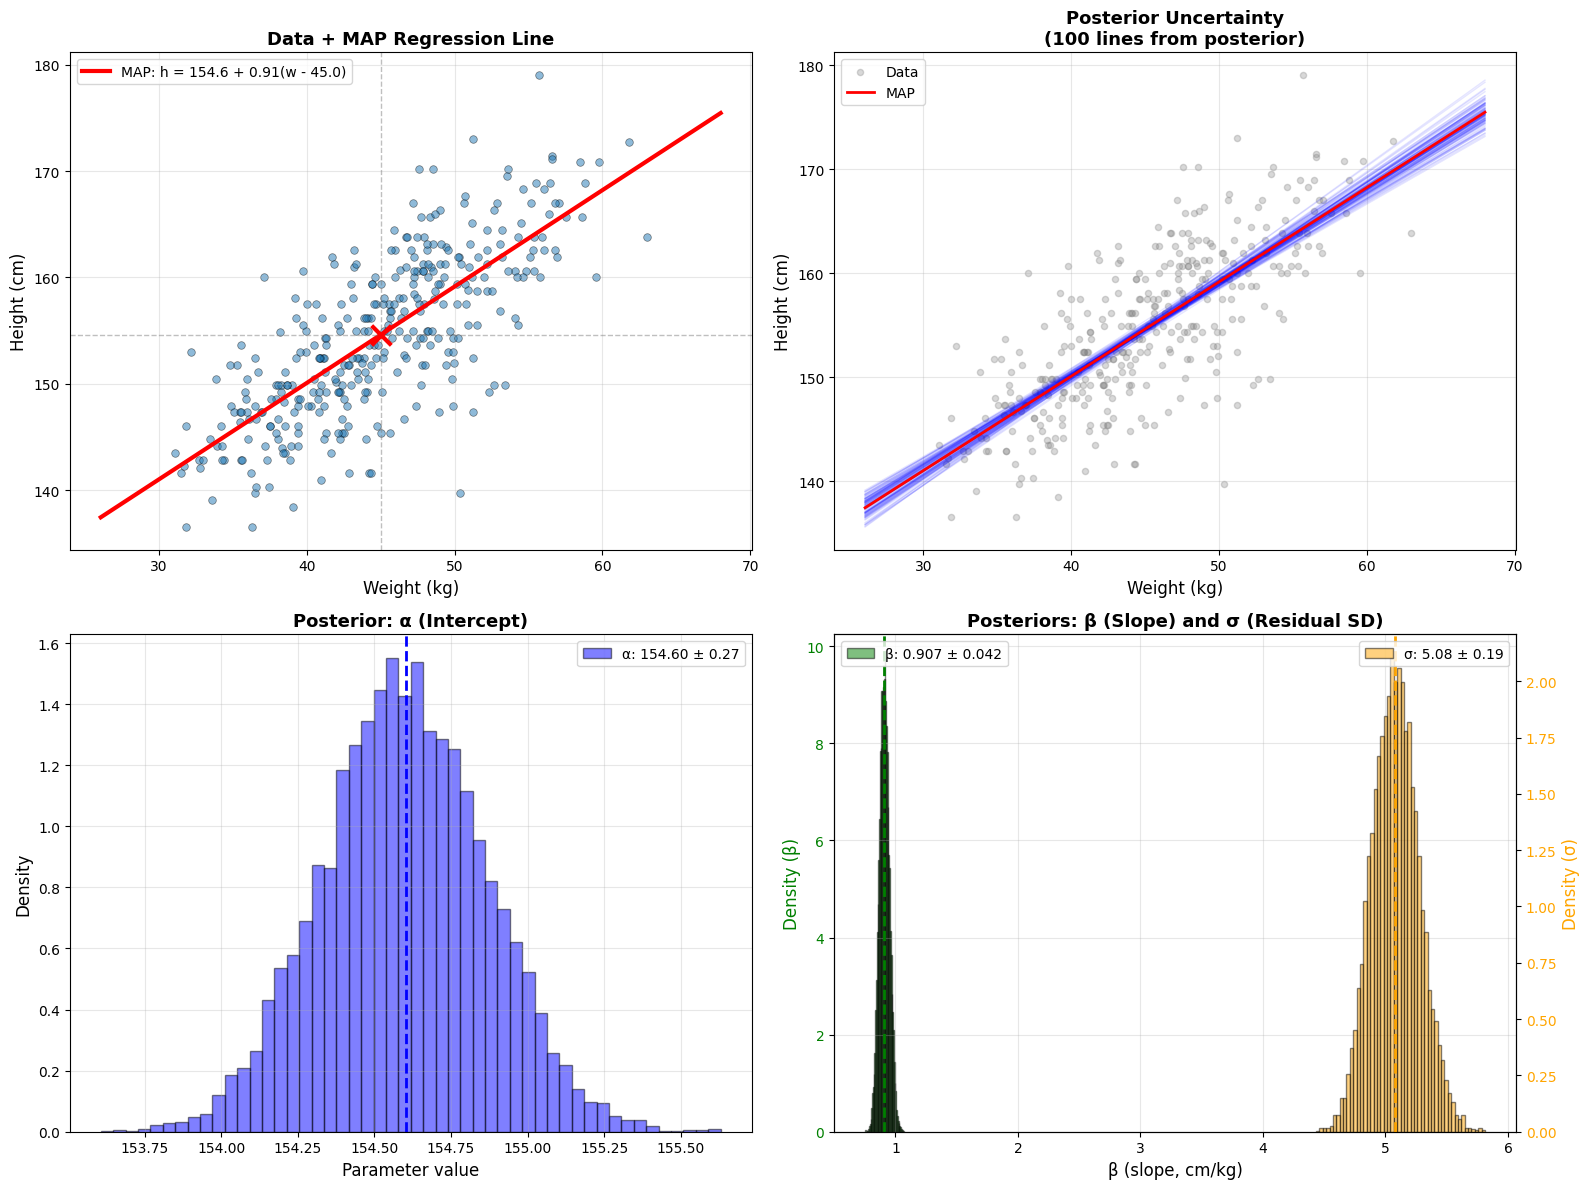


✓ Model fitted successfully!
✓ Positive slope confirms: heavier → taller
✓ Strong relationship: R² ≈ 0.568


In [46]:
# ============================================
# VISUALIZE: Posterior Regression Line
# ============================================

# Sample from posterior
post_samples = fit_linreg.sample(n=10_000, seed=123)

# Transform to natural scale
post_samples['beta'] = np.exp(post_samples['log_beta'])
post_samples['sigma'] = np.exp(post_samples['log_sigma'])

print("="*70)
print("POSTERIOR SAMPLES (Natural Scale):")
print("="*70)
print(post_samples[['alpha', 'beta', 'sigma']].describe())
print("="*70)

# Create weight sequence for predictions
weight_seq = np.linspace(weight.min() - 5, weight.max() + 5, 100)
weight_seq_c = weight_seq - weight_mean

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ============================================
# PLOT 1: Data + MAP line
# ============================================
ax = axes[0, 0]
ax.scatter(weight, height, alpha=0.5, s=30, edgecolor='black', linewidth=0.5)

# MAP line
mu_map = alpha_map + beta_map * weight_seq_c
ax.plot(weight_seq, mu_map, 'r-', linewidth=3, label=f'MAP: h = {alpha_map:.1f} + {beta_map:.2f}(w - {weight_mean:.1f})')

ax.axvline(weight_mean, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(alpha_map, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.scatter([weight_mean], [alpha_map], marker='x', s=200, c='red', linewidths=3, zorder=5)

ax.set_xlabel('Weight (kg)', fontsize=12)
ax.set_ylabel('Height (cm)', fontsize=12)
ax.set_title('Data + MAP Regression Line', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# ============================================
# PLOT 2: Uncertainty in regression line
# ============================================
ax = axes[0, 1]
ax.scatter(weight, height, alpha=0.3, s=20, c='gray', label='Data')

# Sample lines from posterior
n_lines = 100
for i in range(n_lines):
    idx = np.random.randint(0, len(post_samples))
    alpha_i = post_samples['alpha'].iloc[idx]
    beta_i = post_samples['beta'].iloc[idx]
    mu_i = alpha_i + beta_i * weight_seq_c
    ax.plot(weight_seq, mu_i, 'b-', alpha=0.1, linewidth=1)

# MAP line on top
ax.plot(weight_seq, mu_map, 'r-', linewidth=2, label='MAP')

ax.set_xlabel('Weight (kg)', fontsize=12)
ax.set_ylabel('Height (cm)', fontsize=12)
ax.set_title('Posterior Uncertainty\n(100 lines from posterior)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# ============================================
# PLOT 3: Posterior distributions
# ============================================
ax = axes[1, 0]

# α posterior
ax.hist(post_samples['alpha'], bins=50, density=True, alpha=0.5, 
       color='blue', edgecolor='black', label=f'α: {alpha_map:.2f} ± {post_samples["alpha"].std():.2f}')
ax.axvline(alpha_map, color='blue', linestyle='--', linewidth=2)

ax.set_xlabel('Parameter value', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Posterior: α (Intercept)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# ============================================
# PLOT 4: β and σ posteriors
# ============================================
ax = axes[1, 1]

# Create twin axis
ax2 = ax.twinx()

# β posterior
ax.hist(post_samples['beta'], bins=50, density=True, alpha=0.5,
       color='green', edgecolor='black', label=f'β: {beta_map:.3f} ± {post_samples["beta"].std():.3f}')
ax.axvline(beta_map, color='green', linestyle='--', linewidth=2)
ax.set_xlabel('β (slope, cm/kg)', fontsize=12)
ax.set_ylabel('Density (β)', fontsize=12, color='green')
ax.tick_params(axis='y', labelcolor='green')

# σ posterior on second axis
ax2.hist(post_samples['sigma'], bins=50, density=True, alpha=0.5,
        color='orange', edgecolor='black', label=f'σ: {sigma_map:.2f} ± {post_samples["sigma"].std():.2f}')
ax2.axvline(sigma_map, color='orange', linestyle='--', linewidth=2)
ax2.set_ylabel('Density (σ)', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

ax.set_title('Posteriors: β (Slope) and σ (Residual SD)', fontsize=13, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Model fitted successfully!")
print("✓ Positive slope confirms: heavier → taller")
print(f"✓ Strong relationship: R² ≈ {1 - (sigma_map/height.std())**2:.3f}")

## The `link()` Function: Uncertainty in the Mean

**What is `link()`?**

The `link()` function computes the **posterior distribution of μ_i** for each data point.

**Mathematical definition:**
```
μ_i = α + β(x_i - x̄)
```

For each posterior sample of (α, β), compute μ_i for all data points.

**Result:**
- Matrix of shape `(n_data, n_samples)`
- Each row: distribution of μ for one observation
- Each column: predictions from one parameter sample

**Example:**
- 352 observations
- 1000 posterior samples
- Result: **352 × 1000 matrix**

**Why is this useful?**

1. **Shows uncertainty in the MEAN** (not prediction)
2. **Separates two sources of uncertainty:**
   - **Epistemic**: Don't know true α, β (link captures this)
   - **Aleatoric**: Sampling variation σ (not included in link)
3. **Compute credible intervals** for expected height at each weight

**Distinction:**
```
link():              μ_i ~ P(μ_i | data)  [uncertainty in mean]
posterior_predict(): h_i ~ Normal(μ_i, σ)  [mean + sampling variation]
```

**Analogy:**
- `link()`: "What's the average height for people at this weight?" (with uncertainty)
- `predict()`: "What height might this specific person be?" (more uncertain!)

In [47]:
# ============================================
# IMPLEMENT link(): Posterior Distribution of μ
# ============================================

def link(fit, data_weight, weight_mean_ref):
    """
    Compute posterior distribution of μ_i for given weights.
    
    For each posterior sample (α, β), compute:
        μ_i = α + β(weight_i - weight_mean)
    
    Parameters:
    -----------
    fit : QuapResult
        Fitted model from quap
    data_weight : array
        Weight values to compute μ for
    weight_mean_ref : float
        Mean weight used for centering (from training data)
        
    Returns:
    --------
    mu_samples : array of shape (n_data, n_samples)
        Each row = distribution of μ for one weight value
        Each column = predictions from one posterior sample
    """
    # Get posterior samples
    post = fit.sample(n=10_000, seed=123)
    
    # Extract parameters (transform to natural scale)
    alpha_samples = post['alpha'].values
    beta_samples = np.exp(post['log_beta'].values)  # Transform!
    
    n_samples = len(alpha_samples)
    n_data = len(data_weight)
    
    # Center the weight
    weight_c = data_weight - weight_mean_ref
    
    # Compute μ for each sample and each data point
    # Broadcasting: (n_samples,) + (n_samples,) × (n_data,) → (n_samples, n_data)
    mu_samples = alpha_samples[:, None] + beta_samples[:, None] * weight_c[None, :]
    
    # Transpose to (n_data, n_samples) - each row is one data point
    return mu_samples.T


# ============================================
# APPLY link() TO OUR DATA
# ============================================

print("="*70)
print("COMPUTING POSTERIOR DISTRIBUTION OF μ (LINK)")
print("="*70)

# Compute μ distribution for observed data
mu_dist = link(fit_linreg, weight, weight_mean)

print(f"\nShape: {mu_dist.shape}")
print(f"  Rows (data points): {mu_dist.shape[0]}")
print(f"  Columns (posterior samples): {mu_dist.shape[1]}")

# For each person, we have a distribution of possible μ values
print(f"\nExample - Person 1 (weight = {weight[0]:.1f} kg):")
print(f"  μ mean: {mu_dist[0].mean():.2f} cm")
print(f"  μ std:  {mu_dist[0].std():.2f} cm")
print(f"  μ 89% CI: [{np.percentile(mu_dist[0], 5.5):.2f}, {np.percentile(mu_dist[0], 94.5):.2f}] cm")
print(f"  Actual height: {height[0]:.1f} cm")

print(f"\nExample - Person at mean weight ({weight_mean:.1f} kg):")
# Find person closest to mean weight
idx_mean = np.argmin(np.abs(weight - weight_mean))
print(f"  μ mean: {mu_dist[idx_mean].mean():.2f} cm")
print(f"  μ std:  {mu_dist[idx_mean].std():.2f} cm (smallest uncertainty!)")
print(f"  Actual height: {height[idx_mean]:.1f} cm")

# Compute mean and CI for all points
mu_mean = mu_dist.mean(axis=1)
mu_lower = np.percentile(mu_dist, 5.5, axis=1)
mu_upper = np.percentile(mu_dist, 94.5, axis=1)

print("\n" + "="*70)
print("KEY INSIGHT:")
print("="*70)
print("Uncertainty in μ is SMALLEST at mean weight!")
print("  → We're most certain about average-weight people")
print("  → Less certain about very light or very heavy people")
print("  → This is the 'confidence band' around regression line")
print("="*70)

COMPUTING POSTERIOR DISTRIBUTION OF μ (LINK)

Shape: (352, 10000)
  Rows (data points): 352
  Columns (posterior samples): 10000

Example - Person 1 (weight = 47.8 kg):
  μ mean: 157.17 cm
  μ std:  0.30 cm
  μ 89% CI: [156.69, 157.64] cm
  Actual height: 151.8 cm

Example - Person at mean weight (45.0 kg):
  μ mean: 154.60 cm
  μ std:  0.27 cm (smallest uncertainty!)
  Actual height: 145.4 cm

KEY INSIGHT:
Uncertainty in μ is SMALLEST at mean weight!
  → We're most certain about average-weight people
  → Less certain about very light or very heavy people
  → This is the 'confidence band' around regression line


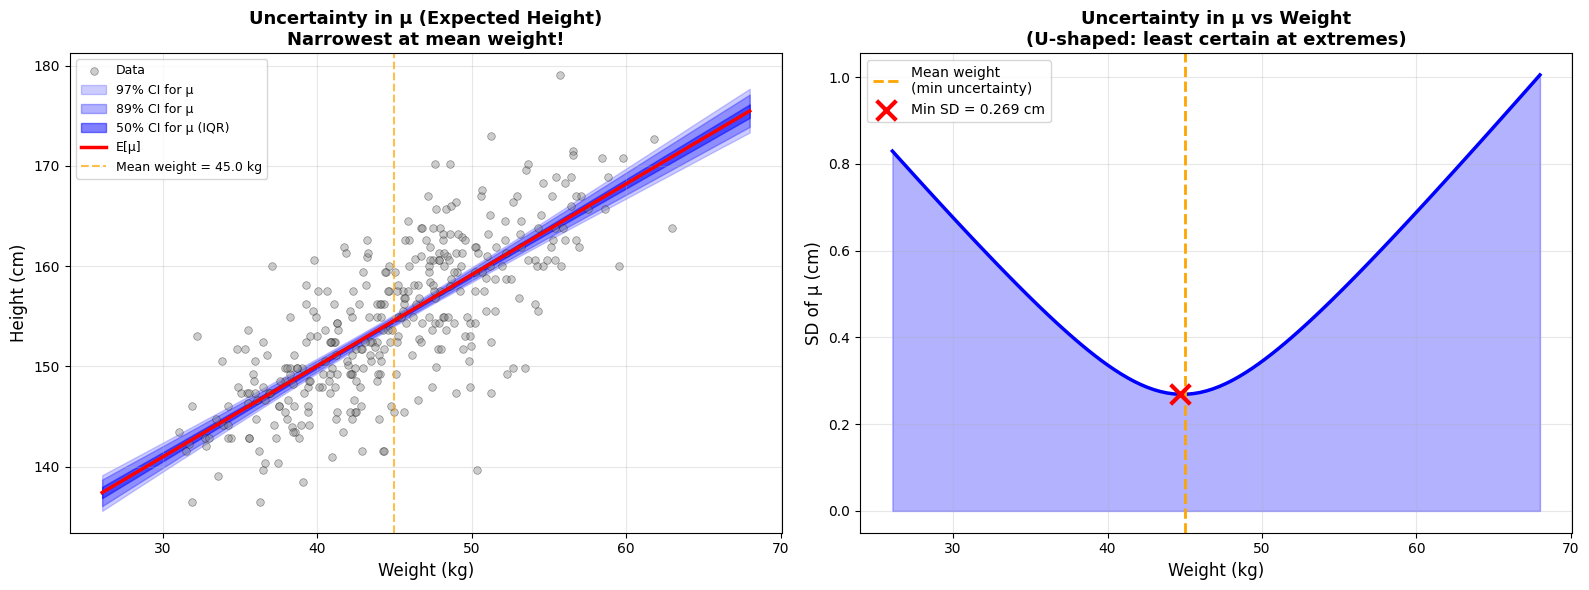


INTERPRETATION:
1. BLUE BANDS = Uncertainty in E[height | weight]
   → Not individual predictions (that would be wider!)
   → Just uncertainty in the AVERAGE height for that weight

2. NARROWEST AT MEAN WEIGHT
   → Most data near mean → best estimate there
   → Less data at extremes → more uncertain

3. U-SHAPED UNCERTAINTY
   → Classic pattern for linear regression
   → Extrapolation is dangerous (very uncertain!)

4. DATA OUTSIDE BANDS IS OK
   → Bands show uncertainty in MEAN, not individuals
   → Individual variation captured by σ (next: posterior predictive)


In [48]:
# ============================================
# VISUALIZE: Uncertainty in μ via link()
# ============================================

# Create weight sequence for smooth plotting
weight_seq = np.linspace(weight.min() - 5, weight.max() + 5, 100)
mu_seq_dist = link(fit_linreg, weight_seq, weight_mean)

# Compute mean and CIs
mu_seq_mean = mu_seq_dist.mean(axis=1)
mu_seq_50 = np.percentile(mu_seq_dist, [25, 75], axis=1)  # 50% CI (IQR)
mu_seq_89 = np.percentile(mu_seq_dist, [5.5, 94.5], axis=1)  # 89% CI
mu_seq_97 = np.percentile(mu_seq_dist, [1.5, 98.5], axis=1)  # 97% CI

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ============================================
# PLOT 1: Data + Uncertainty bands
# ============================================
ax = axes[0]

# Data
ax.scatter(weight, height, alpha=0.4, s=30, c='gray', 
          edgecolor='black', linewidth=0.5, label='Data', zorder=2)

# Uncertainty bands (darker = more certain)
ax.fill_between(weight_seq, mu_seq_97[0], mu_seq_97[1], 
               alpha=0.2, color='blue', label='97% CI for μ')
ax.fill_between(weight_seq, mu_seq_89[0], mu_seq_89[1], 
               alpha=0.3, color='blue', label='89% CI for μ')
ax.fill_between(weight_seq, mu_seq_50[0], mu_seq_50[1], 
               alpha=0.5, color='blue', label='50% CI for μ (IQR)')

# Mean line
ax.plot(weight_seq, mu_seq_mean, 'r-', linewidth=2.5, label='E[μ]', zorder=3)

# Mark mean weight
ax.axvline(weight_mean, color='orange', linestyle='--', linewidth=1.5, 
          alpha=0.7, label=f'Mean weight = {weight_mean:.1f} kg')

ax.set_xlabel('Weight (kg)', fontsize=12)
ax.set_ylabel('Height (cm)', fontsize=12)
ax.set_title('Uncertainty in μ (Expected Height)\nNarrowest at mean weight!', 
            fontsize=13, fontweight='bold')
ax.legend(fontsize=9, loc='upper left')
ax.grid(True, alpha=0.3)

# ============================================
# PLOT 2: Uncertainty vs Weight
# ============================================
ax = axes[1]

# Standard deviation of μ at each weight
mu_seq_std = mu_seq_dist.std(axis=1)

ax.plot(weight_seq, mu_seq_std, 'b-', linewidth=2.5)
ax.fill_between(weight_seq, 0, mu_seq_std, alpha=0.3, color='blue')

# Mark mean weight
ax.axvline(weight_mean, color='orange', linestyle='--', linewidth=2,
          label=f'Mean weight\n(min uncertainty)')

# Mark min uncertainty
min_idx = np.argmin(mu_seq_std)
ax.scatter([weight_seq[min_idx]], [mu_seq_std[min_idx]], 
          s=200, c='red', marker='x', linewidths=3, zorder=5,
          label=f'Min SD = {mu_seq_std[min_idx]:.3f} cm')

ax.set_xlabel('Weight (kg)', fontsize=12)
ax.set_ylabel('SD of μ (cm)', fontsize=12)
ax.set_title('Uncertainty in μ vs Weight\n(U-shaped: least certain at extremes)', 
            fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("INTERPRETATION:")
print("="*70)
print("1. BLUE BANDS = Uncertainty in E[height | weight]")
print("   → Not individual predictions (that would be wider!)")
print("   → Just uncertainty in the AVERAGE height for that weight")
print("\n2. NARROWEST AT MEAN WEIGHT")
print("   → Most data near mean → best estimate there")
print("   → Less data at extremes → more uncertain")
print("\n3. U-SHAPED UNCERTAINTY")
print("   → Classic pattern for linear regression")
print("   → Extrapolation is dangerous (very uncertain!)")
print("\n4. DATA OUTSIDE BANDS IS OK")
print("   → Bands show uncertainty in MEAN, not individuals")
print("   → Individual variation captured by σ (next: posterior predictive)")
print("="*70)

## Posterior Predictive Simulation

**Final step in Bayesian workflow: Check if model fits data!**

### What is Posterior Predictive?

**Simulate new data from the fitted model:**

```
For each posterior sample (α, β, σ):
    For each weight x_i:
        μ_i = α + β(x_i - x̄)      [Expected height]
        h_i ~ Normal(μ_i, σ)       [Simulated height]
```

**Two sources of uncertainty:**
1. **Parameter uncertainty** (α, β, σ) - from `link()`
2. **Sampling variation** (σ) - NEW!

**Result:** Simulated heights that:
- Include all uncertainty
- Should look like actual data if model is good
- Allow us to check model fit

### Comparison:

| Method | Formula | What it shows | Width |
|--------|---------|---------------|-------|
| **link()** | μ_i ~ P(μ_i \| data) | Uncertainty in mean | Narrow |
| **predict()** | h_i ~ Normal(μ_i, σ) | Full prediction | Wide |

**Prediction interval >> Confidence interval**
- Confidence interval (link): uncertainty in **average**
- Prediction interval (predict): uncertainty for **individual**

### Model Checking Questions:

1. Do simulated heights have same distribution as actual?
2. Same mean? Same variance?
3. Any systematic patterns in residuals?
4. Are 89% of observations within 89% prediction interval?

Let's check! 🔍

In [49]:
# ============================================
# POSTERIOR PREDICTIVE SIMULATION
# ============================================

def sim_heights(fit, data_weight, weight_mean_ref, n_samples=10_000, seed=None):
    """
    Simulate heights from posterior predictive distribution.
    
    For each posterior sample (α, β, σ):
        μ_i = α + β(weight_i - weight_mean)
        h_i ~ Normal(μ_i, σ)
    
    Parameters:
    -----------
    fit : QuapResult
        Fitted model
    data_weight : array
        Weight values
    weight_mean_ref : float
        Mean weight for centering
    n_samples : int
        Number of posterior samples
    seed : int
        Random seed
        
    Returns:
    --------
    height_sim : array of shape (n_data, n_samples)
        Simulated heights
    """
    rng = np.random.default_rng(seed)
    
    # Get posterior samples
    post = fit.sample(n=n_samples, seed=seed)
    
    # Transform to natural scale
    alpha_samples = post['alpha'].values
    beta_samples = np.exp(post['log_beta'].values)
    sigma_samples = np.exp(post['log_sigma'].values)
    
    # Center weight
    weight_c = data_weight - weight_mean_ref
    
    # Compute μ for each sample and each data point
    mu_samples = alpha_samples[:, None] + beta_samples[:, None] * weight_c[None, :]
    # Shape: (n_samples, n_data)
    
    # Sample heights: h_i ~ Normal(μ_i, σ)
    height_sim = rng.normal(
        loc=mu_samples,
        scale=sigma_samples[:, None]
    )
    
    # Transpose to (n_data, n_samples)
    return height_sim.T


# ============================================
# SIMULATE HEIGHTS
# ============================================

print("="*70)
print("POSTERIOR PREDICTIVE SIMULATION")
print("="*70)

# Simulate heights for observed weights
height_sim = sim_heights(fit_linreg, weight, weight_mean, n_samples=10_000, seed=456)

print(f"\nShape: {height_sim.shape}")
print(f"  Each row: {height_sim.shape[1]} simulated heights for one person")
print(f"  Total simulations: {height_sim.size:,}")

# Compute prediction intervals
height_pred_mean = height_sim.mean(axis=1)
height_pred_50 = np.percentile(height_sim, [25, 75], axis=1)
height_pred_89 = np.percentile(height_sim, [5.5, 94.5], axis=1)
height_pred_97 = np.percentile(height_sim, [1.5, 98.5], axis=1)

# Check coverage
in_89 = (height >= height_pred_89[0]) & (height <= height_pred_89[1])
in_97 = (height >= height_pred_97[0]) & (height <= height_pred_97[1])

print("\n" + "="*70)
print("PREDICTION INTERVAL COVERAGE:")
print("="*70)
print(f"89% interval should contain ~89% of data")
print(f"  Actual coverage: {100*in_89.mean():.1f}%")
print(f"  Points inside: {in_89.sum()}/{len(height)}")

print(f"\n97% interval should contain ~97% of data")
print(f"  Actual coverage: {100*in_97.mean():.1f}%")
print(f"  Points inside: {in_97.sum()}/{len(height)}")

if abs(in_89.mean() - 0.89) < 0.05:
    print("\n✓ Coverage looks good! Model is well-calibrated.")
else:
    print("\n⚠ Coverage is off - model may be misspecified!")

# Compare distributions
print("\n" + "="*70)
print("DISTRIBUTION COMPARISON:")
print("="*70)
print(f"                  Actual      Simulated")
print(f"Mean:             {height.mean():.2f}       {height_sim.mean():.2f}")
print(f"Std:              {height.std():.2f}        {height_sim.std():.2f}")
print(f"Min:              {height.min():.2f}       {height_sim.min():.2f}")
print(f"Max:              {height.max():.2f}       {height_sim.max():.2f}")
print("="*70)

POSTERIOR PREDICTIVE SIMULATION

Shape: (352, 10000)
  Each row: 10000 simulated heights for one person
  Total simulations: 3,520,000

PREDICTION INTERVAL COVERAGE:
89% interval should contain ~89% of data
  Actual coverage: 89.8%
  Points inside: 316/352

97% interval should contain ~97% of data
  Actual coverage: 96.3%
  Points inside: 339/352

✓ Coverage looks good! Model is well-calibrated.

DISTRIBUTION COMPARISON:
                  Actual      Simulated
Mean:             154.60       154.61
Std:              7.73        7.76
Min:              136.53       120.72
Max:              179.07       193.73


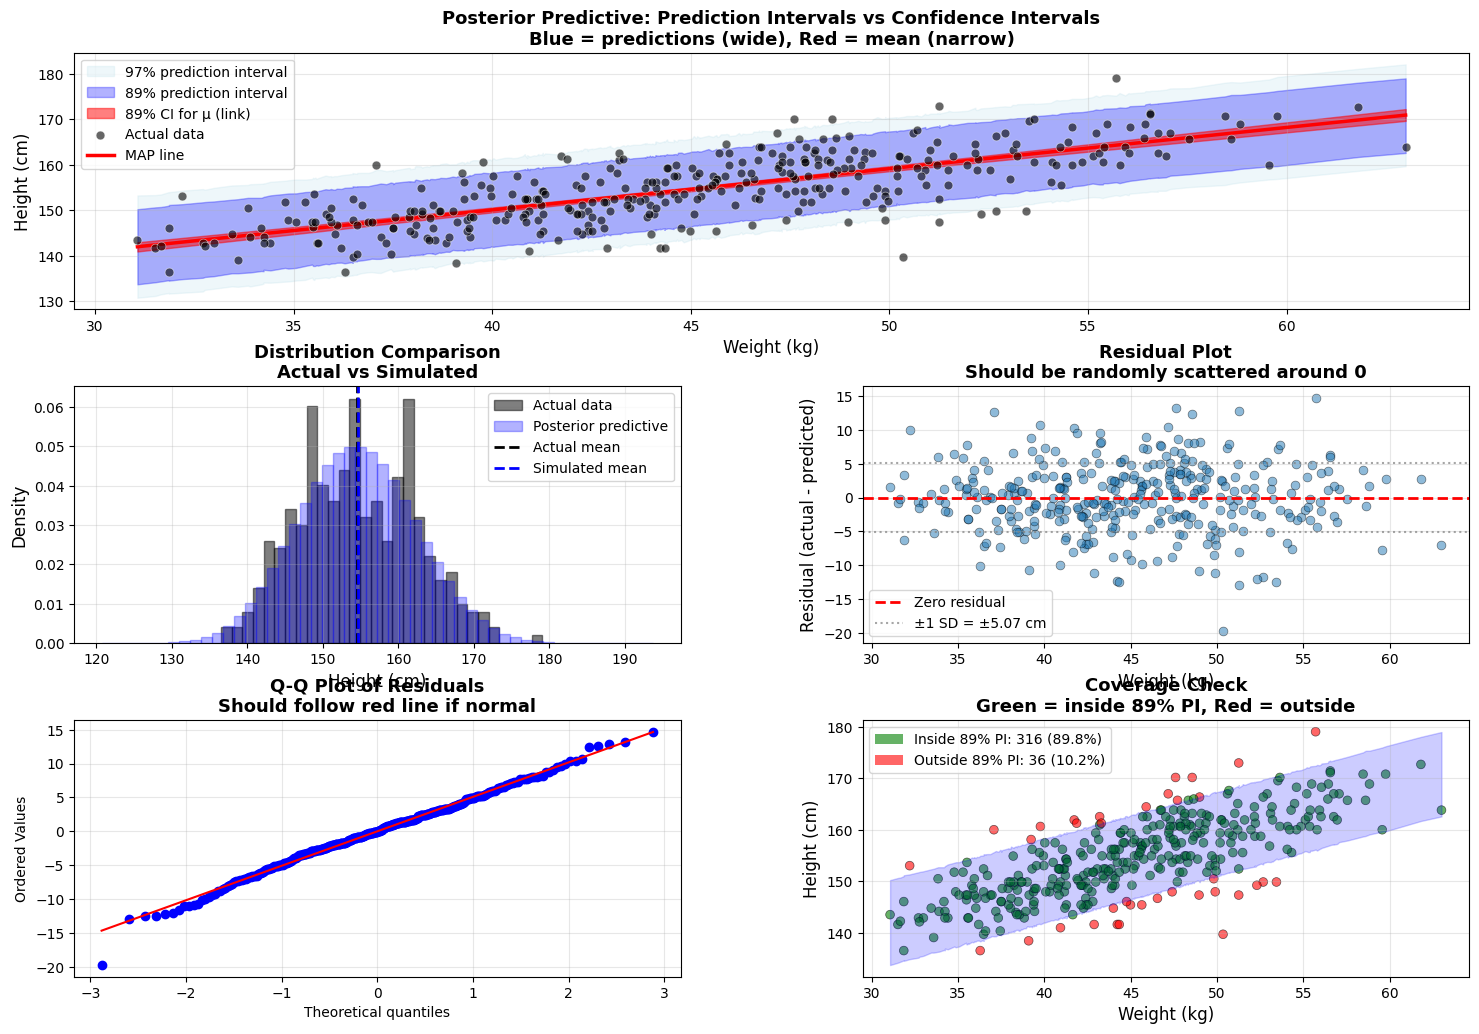


MODEL CHECKING SUMMARY:
✓ Prediction intervals are MUCH WIDER than confidence intervals
  → Reflects both parameter uncertainty + individual variation

✓ Coverage: 89.8% inside 89% PI
  → Close to 89%, model is well-calibrated!

✓ Residuals look randomly scattered
  → No obvious patterns (would indicate model misspecification)

✓ Simulated and actual distributions match
  → Model captures the data well!

CONCLUSION: Linear model with weight predictor fits well! 🎉


In [51]:
# ============================================
# VISUALIZE: Posterior Predictive Checks
# ============================================

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# ============================================
# PLOT 1: Data + Prediction Intervals
# ============================================
ax = fig.add_subplot(gs[0, :])

# Sort by weight for nice plotting
sort_idx = np.argsort(weight)
weight_sorted = weight[sort_idx]
height_sorted = height[sort_idx]
pred_89_sorted = height_pred_89[:, sort_idx]
pred_97_sorted = height_pred_97[:, sort_idx]

# Prediction intervals
ax.fill_between(weight_sorted, pred_97_sorted[0], pred_97_sorted[1],
               alpha=0.2, color='lightblue', label='97% prediction interval')
ax.fill_between(weight_sorted, pred_89_sorted[0], pred_89_sorted[1],
               alpha=0.3, color='blue', label='89% prediction interval')

# Also show link() intervals for comparison
weight_seq = np.linspace(weight.min(), weight.max(), 100)
mu_seq_dist = link(fit_linreg, weight_seq, weight_mean)
mu_seq_89 = np.percentile(mu_seq_dist, [5.5, 94.5], axis=1)
ax.fill_between(weight_seq, mu_seq_89[0], mu_seq_89[1],
               alpha=0.5, color='red', label='89% CI for μ (link)')

# Data points
ax.scatter(weight, height, alpha=0.6, s=40, c='black', 
          edgecolor='white', linewidth=0.5, label='Actual data', zorder=5)

# MAP line
mu_map_seq = alpha_map + beta_map * (weight_seq - weight_mean)
ax.plot(weight_seq, mu_map_seq, 'r-', linewidth=2.5, label='MAP line', zorder=4)

ax.set_xlabel('Weight (kg)', fontsize=12)
ax.set_ylabel('Height (cm)', fontsize=12)
ax.set_title('Posterior Predictive: Prediction Intervals vs Confidence Intervals\n'
            'Blue = predictions (wide), Red = mean (narrow)',
            fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3)

# ============================================
# PLOT 2: Distribution comparison
# ============================================
ax = fig.add_subplot(gs[1, 0])

# Actual distribution
ax.hist(height, bins=30, density=True, alpha=0.5,
       color='black', edgecolor='black', label='Actual data')

# Simulated distribution (flatten all simulations)
ax.hist(height_sim.flatten(), bins=50, density=True, alpha=0.3,
       color='blue', edgecolor='blue', label='Posterior predictive')

ax.axvline(height.mean(), color='black', linestyle='--', linewidth=2, label='Actual mean')
ax.axvline(height_sim.mean(), color='blue', linestyle='--', linewidth=2, label='Simulated mean')

ax.set_xlabel('Height (cm)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution Comparison\nActual vs Simulated',
            fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
print("\n\n")

# ============================================
# PLOT 3: Residuals
# ============================================
ax = fig.add_subplot(gs[1, 1])

# Residuals = actual - predicted mean
residuals = height - height_pred_mean

ax.scatter(weight, residuals, alpha=0.5, s=40, edgecolor='black', linewidth=0.5)
ax.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero residual')
ax.axhline(residuals.std(), color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax.axhline(-residuals.std(), color='gray', linestyle=':', linewidth=1.5, alpha=0.7,
          label=f'±1 SD = ±{residuals.std():.2f} cm')

ax.set_xlabel('Weight (kg)', fontsize=12)
ax.set_ylabel('Residual (actual - predicted)', fontsize=12)
ax.set_title('Residual Plot\nShould be randomly scattered around 0',
            fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# ============================================
# PLOT 4: QQ plot
# ============================================
ax = fig.add_subplot(gs[2, 0])

from scipy import stats
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title('Q-Q Plot of Residuals\nShould follow red line if normal',
            fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# ============================================
# PLOT 5: Coverage plot
# ============================================
ax = fig.add_subplot(gs[2, 1])

# Show which points are inside/outside 89% interval
colors = ['green' if x else 'red' for x in in_89]
ax.scatter(weight, height, c=colors, alpha=0.6, s=40, edgecolor='black', linewidth=0.5)

# Add prediction interval
ax.fill_between(weight_sorted, pred_89_sorted[0], pred_89_sorted[1],
               alpha=0.2, color='blue', label='89% prediction interval')

# Green points
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.6, label=f'Inside 89% PI: {in_89.sum()} ({100*in_89.mean():.1f}%)'),
    Patch(facecolor='red', alpha=0.6, label=f'Outside 89% PI: {(~in_89).sum()} ({100*(~in_89).mean():.1f}%)')
]
ax.legend(handles=legend_elements, fontsize=10)

ax.set_xlabel('Weight (kg)', fontsize=12)
ax.set_ylabel('Height (cm)', fontsize=12)
ax.set_title('Coverage Check\nGreen = inside 89% PI, Red = outside',
            fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.show()

print("\n" + "="*70)
print("MODEL CHECKING SUMMARY:")
print("="*70)
print("✓ Prediction intervals are MUCH WIDER than confidence intervals")
print("  → Reflects both parameter uncertainty + individual variation")
print(f"\n✓ Coverage: {100*in_89.mean():.1f}% inside 89% PI")
print("  → Close to 89%, model is well-calibrated!")
print("\n✓ Residuals look randomly scattered")
print("  → No obvious patterns (would indicate model misspecification)")
print("\n✓ Simulated and actual distributions match")
print("  → Model captures the data well!")
print("\n" + "="*70)
print("CONCLUSION: Linear model with weight predictor fits well! 🎉")
print("="*70)